In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

In [3]:
import IPython.display as ipd

In [4]:
def all_exp(ab, zab, tau, temp, mixtures, model_name, data_size="search"):
    ipd.display(ipd.Markdown("**Simple SWS**"))
    model_sws, gmp_sws, res_sws = retrain_model(ab, zab, tau, int(0), mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS Scaling**"))
    model_sws_s, gmp_sws_s, res_sws_s = retrain_model(ab, zab, tau, int(0), mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_sws_s, means = list(gmp_sws_s.means.data.clone().cpu()), precisions = list(gmp_sws_s.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD**"))
    model_kd, gmp_kd, res_kd = retrain_model(ab, zab, tau, temp, mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_kd, means = list(gmp_kd.means.data.clone().cpu()), precisions = list(gmp_kd.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD Scaling**"))
    model_kd_s, gmp_kd_s, res_kd_s = retrain_model(ab, zab, tau, temp, mixtures, model_name, data_size, "", True)
    show_sws_weights(model = model_kd_s, means = list(gmp_kd_s.means.data.clone().cpu()), precisions = list(gmp_kd_s.gammas.data.clone().cpu()))
    
    title = "Temp: {} Tau: {}\n".format(temp, tau)
    sws_res = "Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
    kd_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n'.format(res_kd['compress_test'], res_kd['compress_val'], res_kd['prune_test'], res_kd['prune_val'], res_kd['sparsity'])
    kd_s_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n\n'.format(res_kd_s['compress_test'], res_kd_s['compress_val'], res_kd_s['prune_test'], res_kd_s['prune_val'], res_kd_s['sparsity'])
    res_str = title + sws_res + kd_res + kd_s_res
    print (res_str)
    
    return model_sws, gmp_sws, model_sws_s, gmp_sws_s, model_kd, gmp_kd, model_kd_s, gmp_kd_s, res_str

### Load good hyperparameters

In [5]:
with open("../search/sobol_search.p", "rb") as handle:
    params = pickle.load(handle)
i = 240
print ("exp:{} mean: {}, var: {}, tau: {}, temp: {}, mixtures: {}".format(i, params['mean'][i], params['var'][i], params['tau'][i], params['temp'][i], int(params['mixtures'][i])))
mean = float(params['mean'][i])
var = float(params['var'][i])
tau = float(params['tau'][i])
mixtures = int(params['mixtures'][i])
temp = float(params['temp'][i])
model_name = 'LeNet_300_100'
data_size = 'search'

exp:240 mean: 0.10181517217181825, var: 0.1034304555503225, tau: 6.479230606842127e-07, temp: 19.0, mixtures: 9


### Override Parameters

In [ ]:
def get_sparsity(model_prune):
    sp_zeroes = 0
    sp_elem = 0
    for layer in model_prune.state_dict():
        sp_zeroes += float((model_prune.state_dict()[layer].view(-1) == 0).sum())
        sp_elem += float(model_prune.state_dict()[layer].view(-1).numel())
    sp = sp_zeroes/sp_elem * 100.0
    return sp
def get_ab(mean, var):
    beta = mean/var
    alpha = mean * beta
    return (alpha, beta)
mixtures = 15
temp = 4
var = 2
zvar = 10
alpha, beta = get_ab(500, var)

In [21]:
model_prune = copy.deepcopy(model_sws)
state_dict = sws_prune(model_sws, gmp_sws)
model_prune.load_state_dict(state_dict)
print (test_accuracy(test_data_full, test_labels_full, model_prune)[0])
print (get_sparsity(model_prune))

37.17
99.73519372866734


**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.24
Epoch: 20. Test Accuracy: 97.36
Epoch: 30. Test Accuracy: 97.54
Epoch: 40. Test Accuracy: 97.69
Epoch: 50. Test Accuracy: 97.59
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25


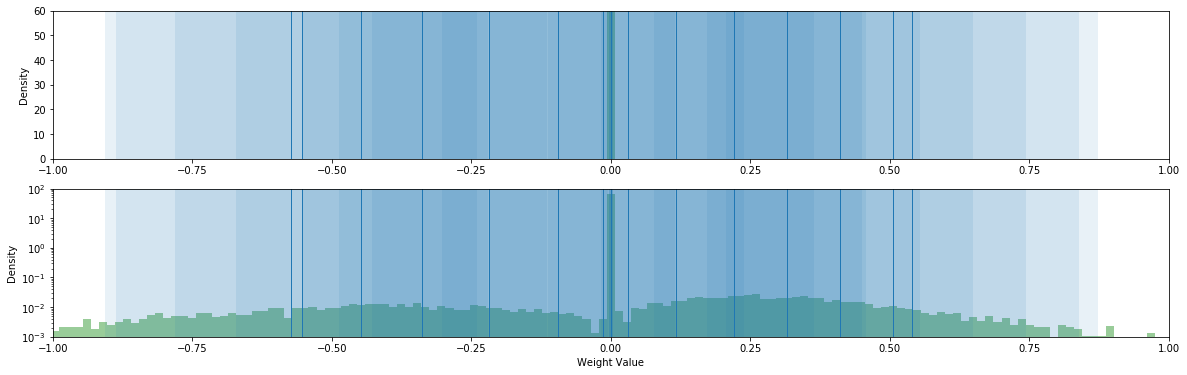

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.83
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 98.03
Epoch: 50. Test Accuracy: 97.97
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33


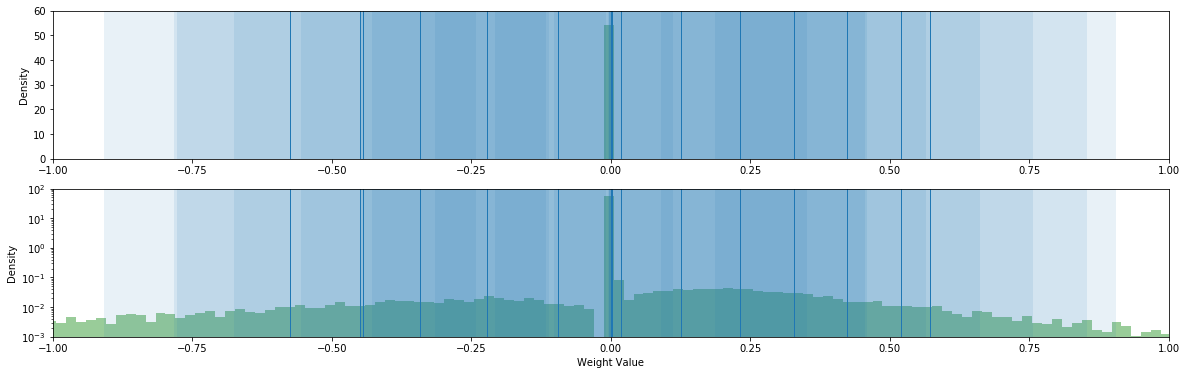

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.49
Epoch: 20. Test Accuracy: 98.08
Epoch: 30. Test Accuracy: 98.10
Epoch: 40. Test Accuracy: 98.02
Epoch: 50. Test Accuracy: 98.07
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20


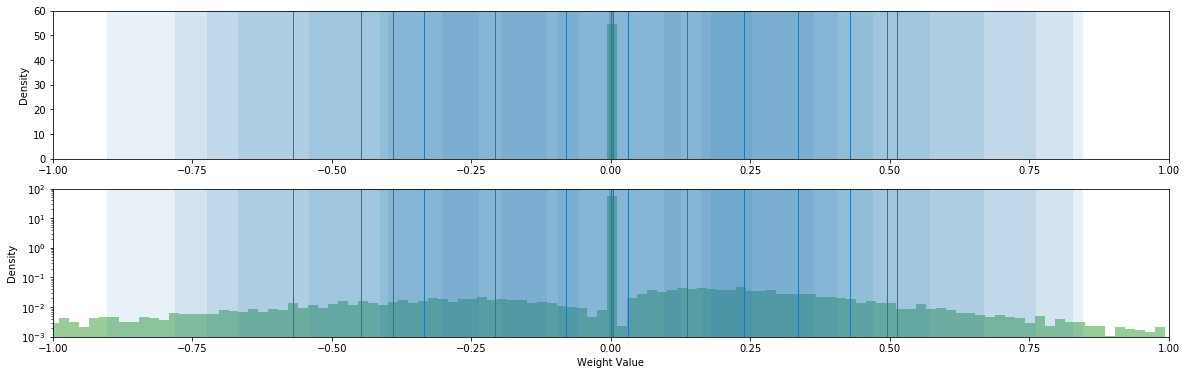

Mean: 10.0 Var: 10.0
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20




<IPython.core.display.Javascript object>

In [11]:
%%notify
_, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name, data_size = 'full')

**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.90
Epoch: 20. Test Accuracy: 97.32
Epoch: 30. Test Accuracy: 96.63
Epoch: 40. Test Accuracy: 95.70
Epoch: 50. Test Accuracy: 95.90
Retrain Test: 95.90, Retrain Validation: 95.81, Prune Test: 91.75, Prune Validation: 91.90, Prune Sparsity: 98.94


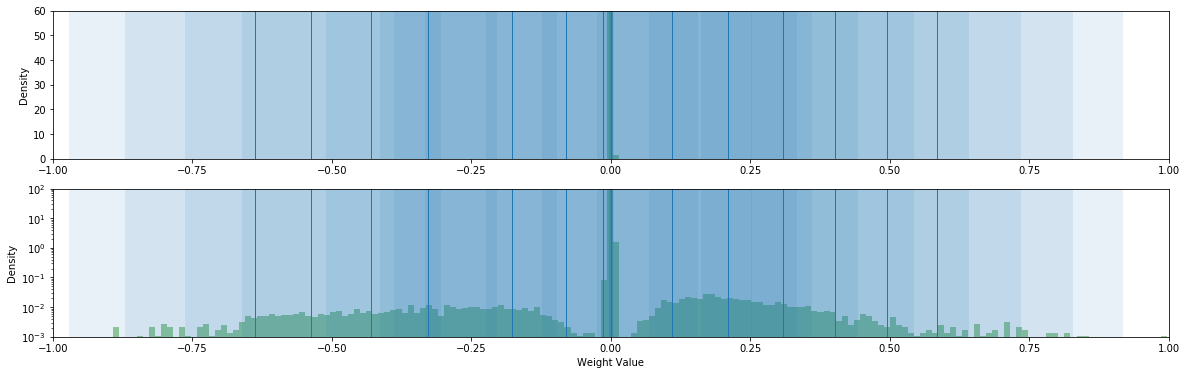

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.55
Epoch: 20. Test Accuracy: 94.80
Epoch: 30. Test Accuracy: 91.14
Epoch: 40. Test Accuracy: 89.09
Epoch: 50. Test Accuracy: 89.52
Retrain Test: 89.52, Retrain Validation: 89.58, Prune Test: 38.02, Prune Validation: 39.63, Prune Sparsity: 99.77


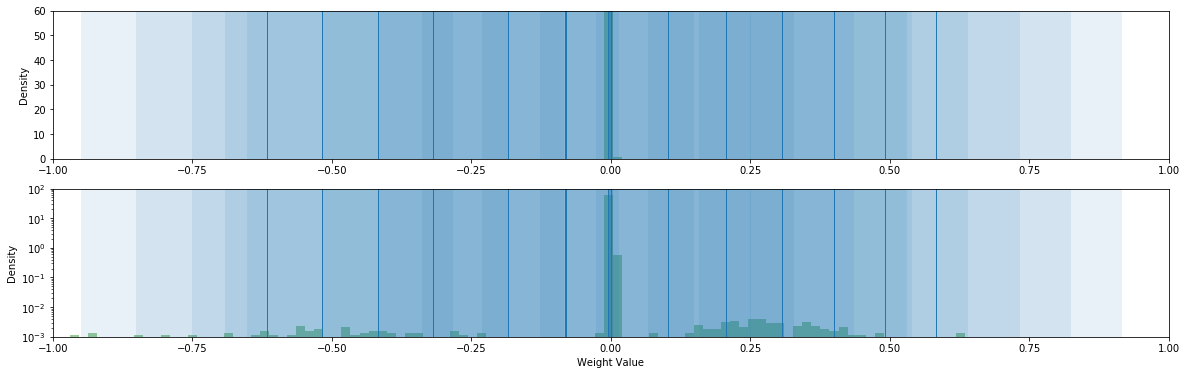

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.48
Epoch: 20. Test Accuracy: 95.28
Epoch: 30. Test Accuracy: 91.20
Epoch: 40. Test Accuracy: 89.55
Epoch: 50. Test Accuracy: 89.77
Retrain Test: 89.77, Retrain Validation: 90.49, Prune Test: 52.40, Prune Validation: 54.63, Prune Sparsity: 99.75


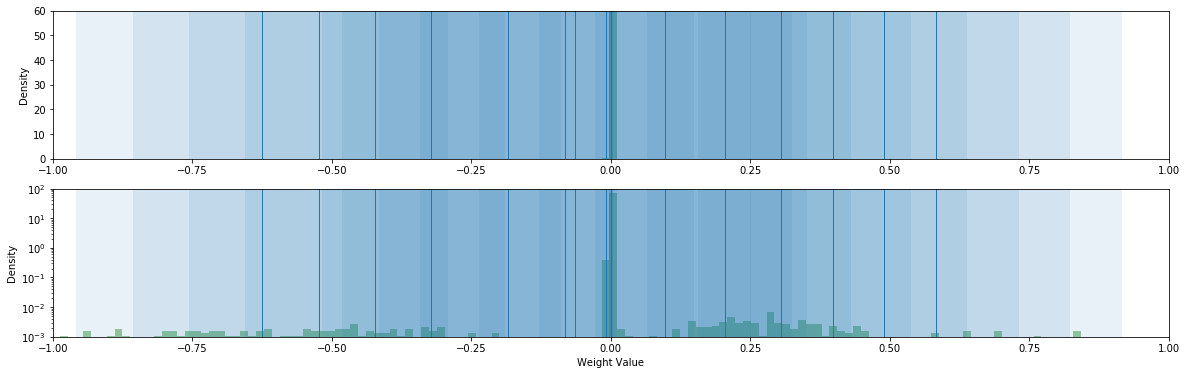

Temp: 1 Tau: 1e-06
Retrain Test: 95.90, Retrain Validation: 95.81, Prune Test: 91.75, Prune Validation: 91.90, Prune Sparsity: 98.94
Retrain Test: 89.52, Retrain Validation: 89.58, Prune Test: 38.02, Prune Validation: 39.63, Prune Sparsity: 99.77
Retrain Test: 89.77, Retrain Validation: 90.49, Prune Test: 52.40, Prune Validation: 54.63, Prune Sparsity: 99.75




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.81
Epoch: 20. Test Accuracy: 98.07
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.93
Epoch: 50. Test Accuracy: 97.64
Retrain Test: 97.64, Retrain Validation: 97.56, Prune Test: 91.25, Prune Validation: 90.93, Prune Sparsity: 94.26


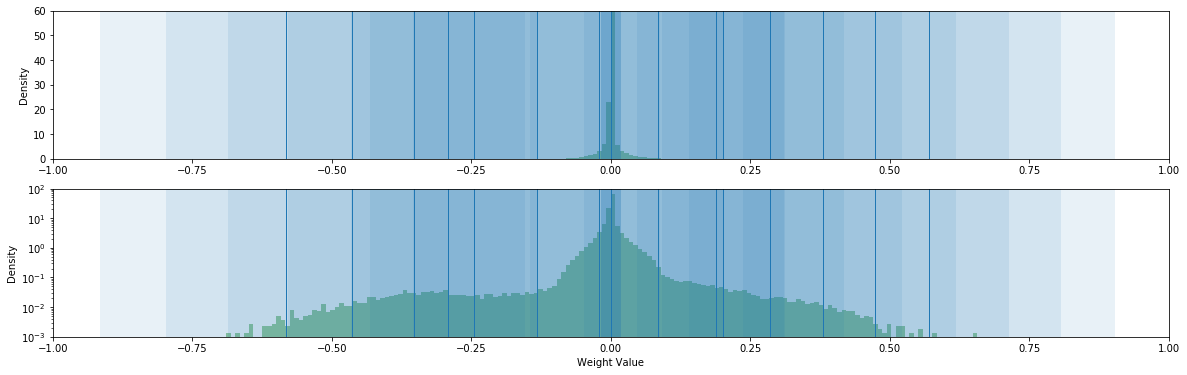

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.13
Epoch: 20. Test Accuracy: 97.83
Epoch: 30. Test Accuracy: 96.73
Epoch: 40. Test Accuracy: 96.27
Epoch: 50. Test Accuracy: 96.28
Retrain Test: 96.28, Retrain Validation: 95.96, Prune Test: 92.46, Prune Validation: 92.69, Prune Sparsity: 98.78


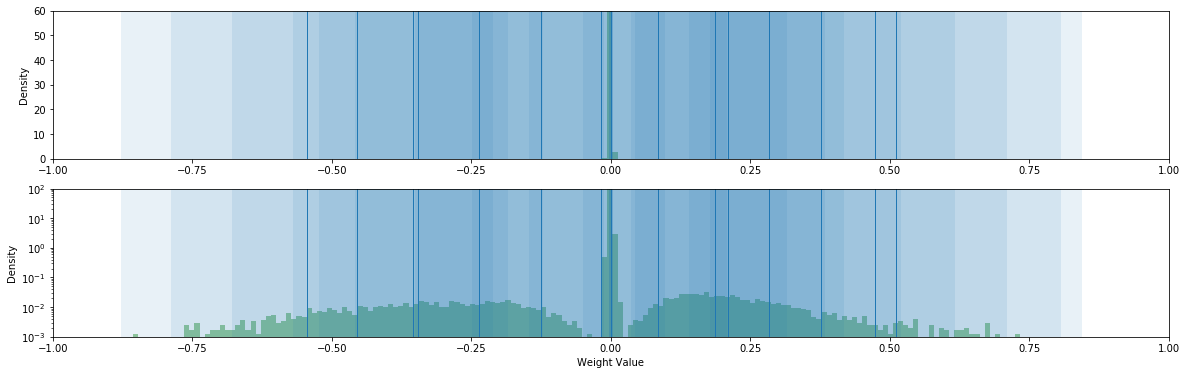

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.53
Epoch: 20. Test Accuracy: 97.71
Epoch: 30. Test Accuracy: 96.92
Epoch: 40. Test Accuracy: 96.15
Epoch: 50. Test Accuracy: 96.24
Retrain Test: 96.24, Retrain Validation: 95.86, Prune Test: 89.43, Prune Validation: 89.19, Prune Sparsity: 98.91


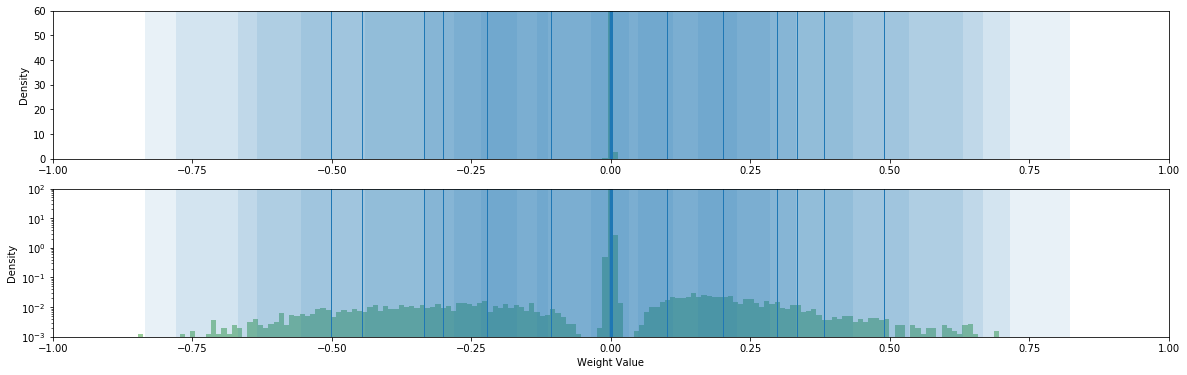

Temp: 1 Tau: 1e-07
Retrain Test: 97.64, Retrain Validation: 97.56, Prune Test: 91.25, Prune Validation: 90.93, Prune Sparsity: 94.26
Retrain Test: 96.28, Retrain Validation: 95.96, Prune Test: 92.46, Prune Validation: 92.69, Prune Sparsity: 98.78
Retrain Test: 96.24, Retrain Validation: 95.86, Prune Test: 89.43, Prune Validation: 89.19, Prune Sparsity: 98.91




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.98
Epoch: 20. Test Accuracy: 97.50
Epoch: 30. Test Accuracy: 97.73
Epoch: 40. Test Accuracy: 97.77
Epoch: 50. Test Accuracy: 97.79
Retrain Test: 97.79, Retrain Validation: 97.89, Prune Test: 97.78, Prune Validation: 97.72, Prune Sparsity: 62.79


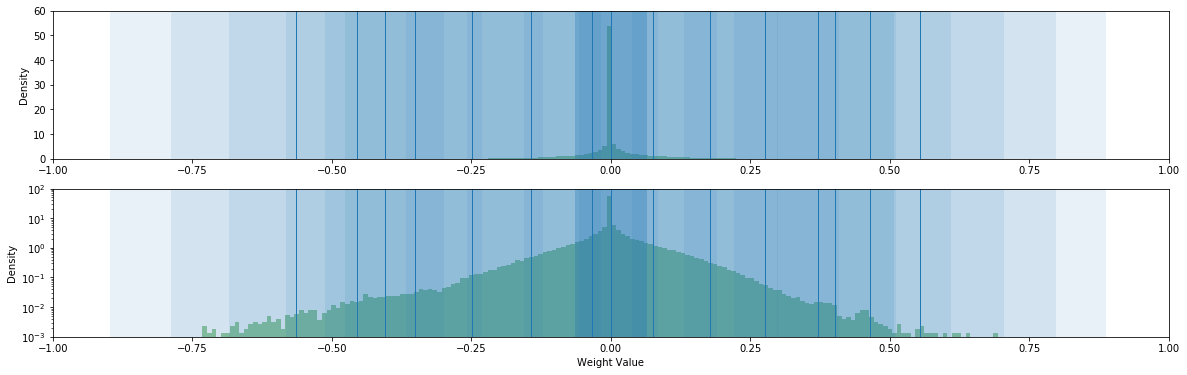

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.06
Epoch: 20. Test Accuracy: 98.04
Epoch: 30. Test Accuracy: 97.89
Epoch: 40. Test Accuracy: 98.04
Epoch: 50. Test Accuracy: 97.86
Retrain Test: 97.86, Retrain Validation: 97.87, Prune Test: 97.55, Prune Validation: 97.46, Prune Sparsity: 83.54


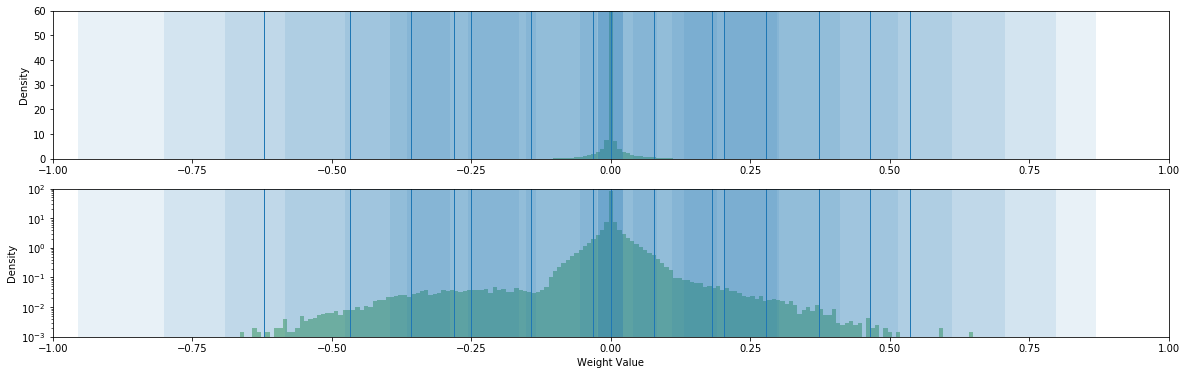

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.99
Epoch: 20. Test Accuracy: 97.99
Epoch: 30. Test Accuracy: 98.07
Epoch: 40. Test Accuracy: 98.14
Epoch: 50. Test Accuracy: 97.90
Retrain Test: 97.90, Retrain Validation: 97.75, Prune Test: 90.94, Prune Validation: 91.21, Prune Sparsity: 92.12


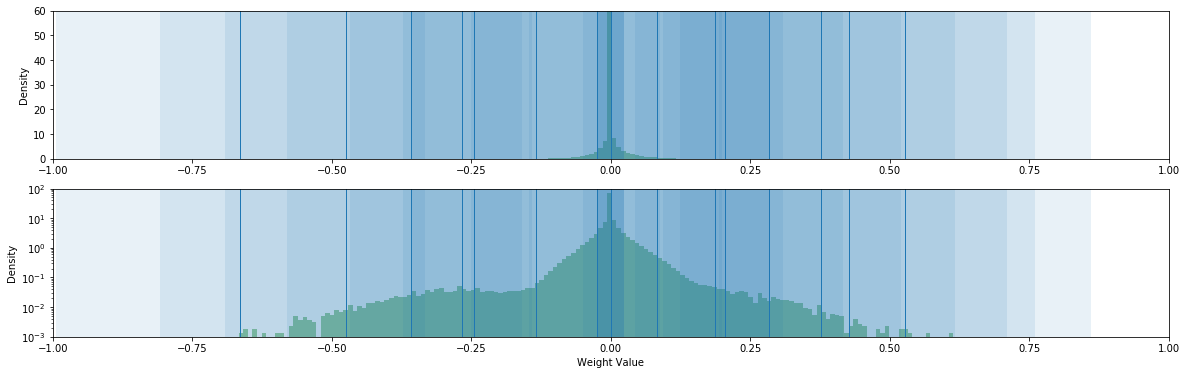

Temp: 1 Tau: 1e-08
Retrain Test: 97.79, Retrain Validation: 97.89, Prune Test: 97.78, Prune Validation: 97.72, Prune Sparsity: 62.79
Retrain Test: 97.86, Retrain Validation: 97.87, Prune Test: 97.55, Prune Validation: 97.46, Prune Sparsity: 83.54
Retrain Test: 97.90, Retrain Validation: 97.75, Prune Test: 90.94, Prune Validation: 91.21, Prune Sparsity: 92.12




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.04
Epoch: 20. Test Accuracy: 97.59
Epoch: 30. Test Accuracy: 96.77
Epoch: 40. Test Accuracy: 95.99
Epoch: 50. Test Accuracy: 95.81
Retrain Test: 95.81, Retrain Validation: 96.06, Prune Test: 91.06, Prune Validation: 91.35, Prune Sparsity: 98.91


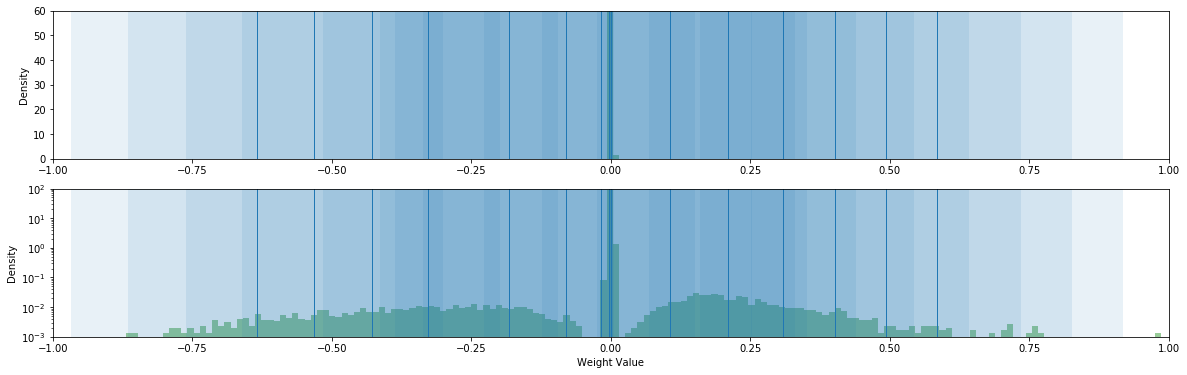

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.93
Epoch: 20. Test Accuracy: 97.08
Epoch: 30. Test Accuracy: 95.27
Epoch: 40. Test Accuracy: 93.91
Epoch: 50. Test Accuracy: 94.18
Retrain Test: 94.18, Retrain Validation: 94.42, Prune Test: 83.30, Prune Validation: 84.14, Prune Sparsity: 99.37


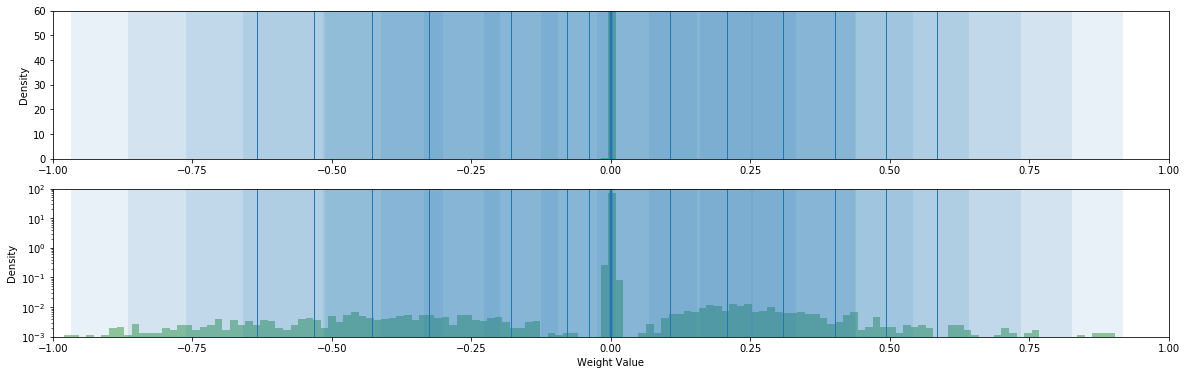

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.75
Epoch: 20. Test Accuracy: 97.07
Epoch: 30. Test Accuracy: 95.33
Epoch: 40. Test Accuracy: 94.22
Epoch: 50. Test Accuracy: 94.71
Retrain Test: 94.71, Retrain Validation: 94.63, Prune Test: 86.27, Prune Validation: 87.45, Prune Sparsity: 99.33


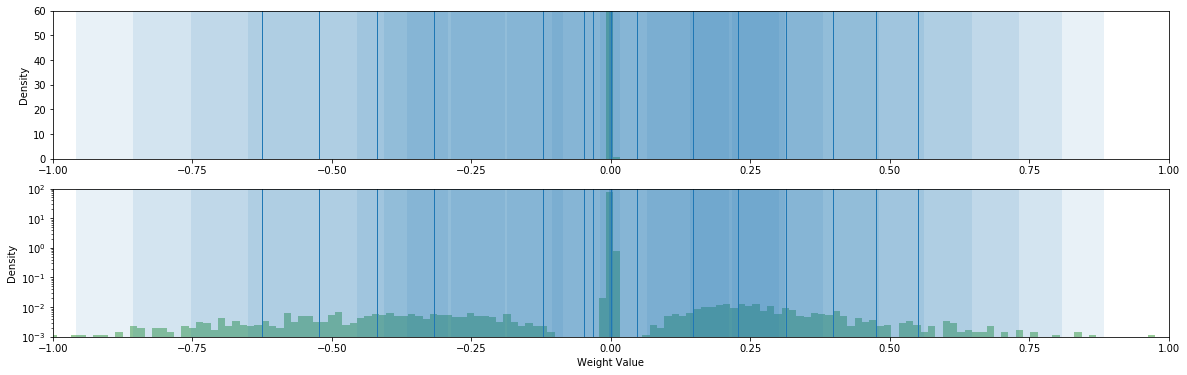

Temp: 2 Tau: 1e-06
Retrain Test: 95.81, Retrain Validation: 96.06, Prune Test: 91.06, Prune Validation: 91.35, Prune Sparsity: 98.91
Retrain Test: 94.18, Retrain Validation: 94.42, Prune Test: 83.30, Prune Validation: 84.14, Prune Sparsity: 99.37
Retrain Test: 94.71, Retrain Validation: 94.63, Prune Test: 86.27, Prune Validation: 87.45, Prune Sparsity: 99.33




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.05
Epoch: 20. Test Accuracy: 98.18
Epoch: 30. Test Accuracy: 97.97
Epoch: 40. Test Accuracy: 97.95
Epoch: 50. Test Accuracy: 97.76
Retrain Test: 97.76, Retrain Validation: 97.66, Prune Test: 91.93, Prune Validation: 91.63, Prune Sparsity: 93.70


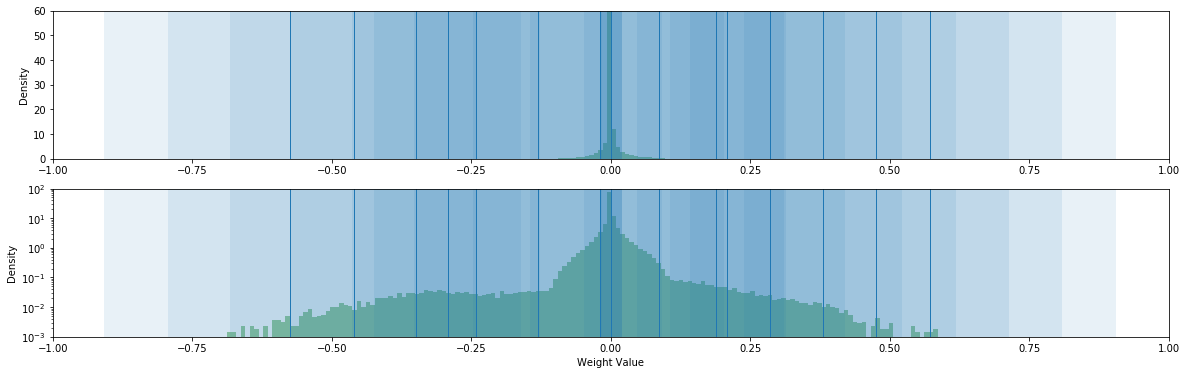

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.01
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 97.73
Epoch: 40. Test Accuracy: 96.96
Epoch: 50. Test Accuracy: 96.87
Retrain Test: 96.87, Retrain Validation: 96.95, Prune Test: 96.32, Prune Validation: 96.18, Prune Sparsity: 97.53


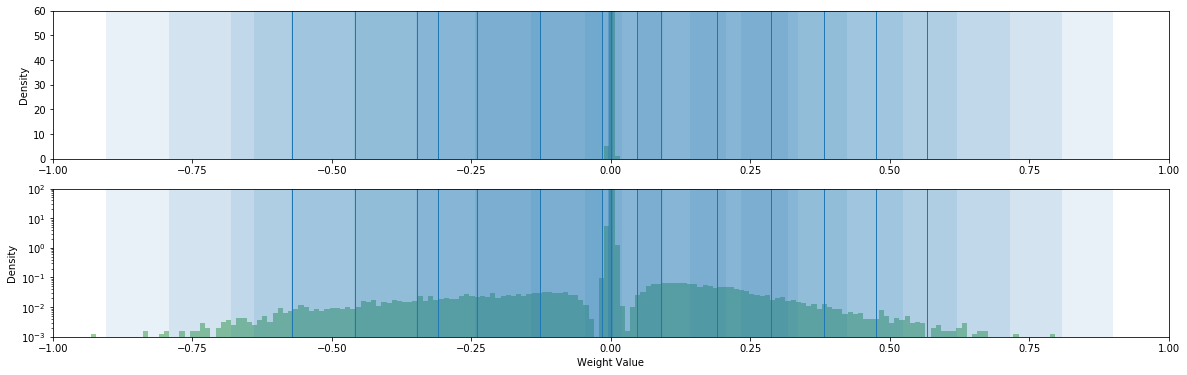

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.06
Epoch: 20. Test Accuracy: 97.92
Epoch: 30. Test Accuracy: 97.76
Epoch: 40. Test Accuracy: 97.50
Epoch: 50. Test Accuracy: 97.06
Retrain Test: 97.06, Retrain Validation: 96.98, Prune Test: 96.26, Prune Validation: 96.02, Prune Sparsity: 97.18


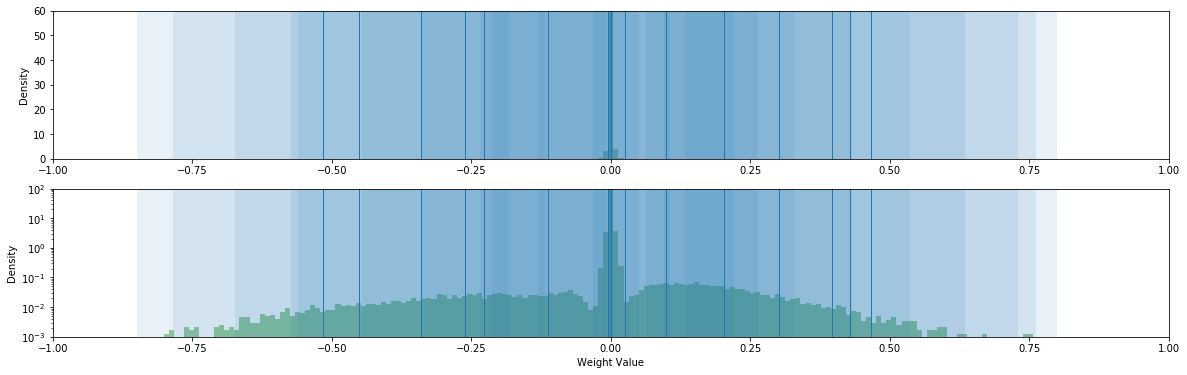

Temp: 2 Tau: 1e-07
Retrain Test: 97.76, Retrain Validation: 97.66, Prune Test: 91.93, Prune Validation: 91.63, Prune Sparsity: 93.70
Retrain Test: 96.87, Retrain Validation: 96.95, Prune Test: 96.32, Prune Validation: 96.18, Prune Sparsity: 97.53
Retrain Test: 97.06, Retrain Validation: 96.98, Prune Test: 96.26, Prune Validation: 96.02, Prune Sparsity: 97.18




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.95
Epoch: 20. Test Accuracy: 97.89
Epoch: 30. Test Accuracy: 97.81
Epoch: 40. Test Accuracy: 97.79
Epoch: 50. Test Accuracy: 97.82
Retrain Test: 97.82, Retrain Validation: 97.99, Prune Test: 97.69, Prune Validation: 97.77, Prune Sparsity: 62.07


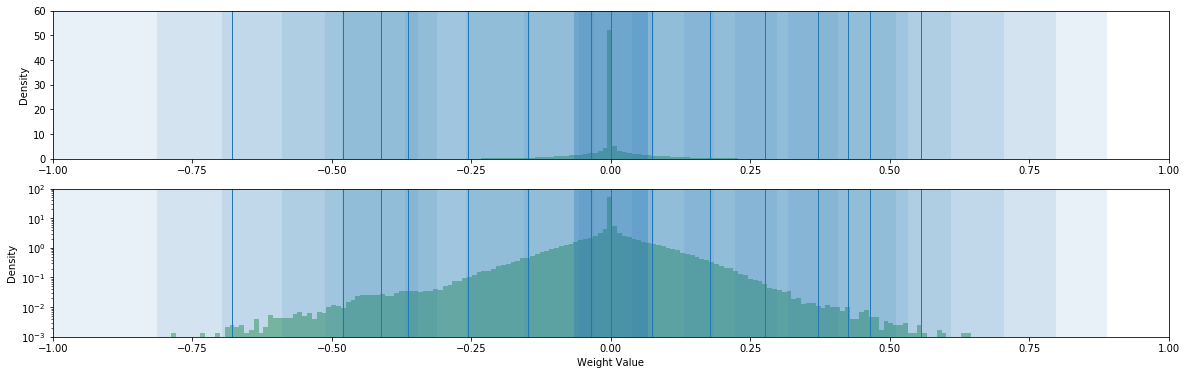

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.88
Epoch: 20. Test Accuracy: 97.88
Epoch: 30. Test Accuracy: 97.87
Epoch: 40. Test Accuracy: 97.88
Epoch: 50. Test Accuracy: 97.89
Retrain Test: 97.89, Retrain Validation: 97.93, Prune Test: 97.69, Prune Validation: 97.74, Prune Sparsity: 69.68


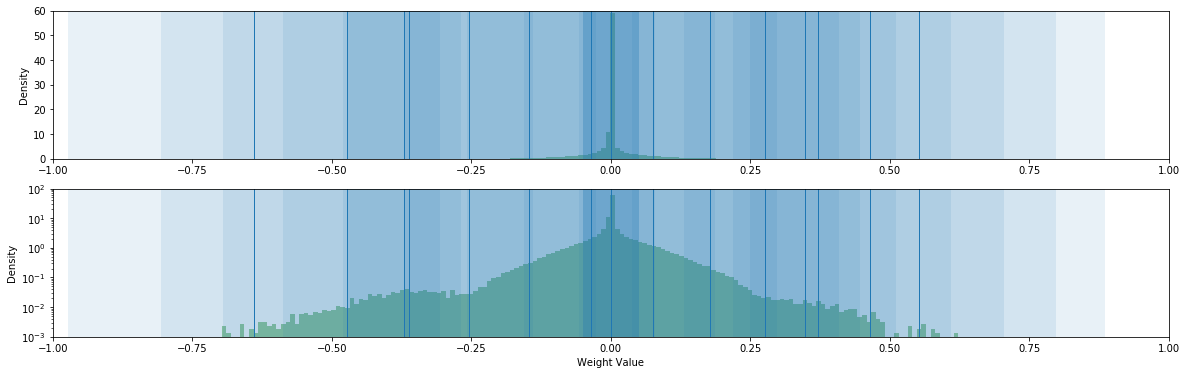

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.05
Epoch: 20. Test Accuracy: 98.02
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.95
Epoch: 50. Test Accuracy: 98.05
Retrain Test: 98.05, Retrain Validation: 98.04, Prune Test: 97.00, Prune Validation: 97.18, Prune Sparsity: 81.82


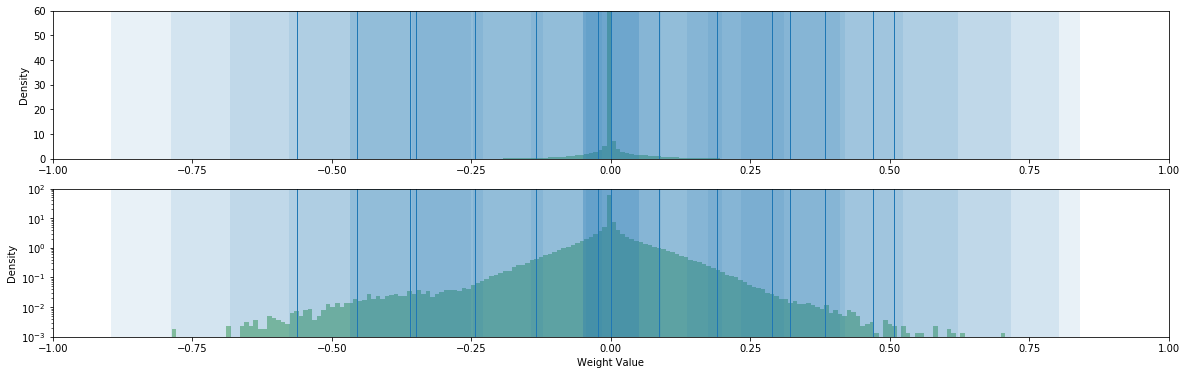

Temp: 2 Tau: 1e-08
Retrain Test: 97.82, Retrain Validation: 97.99, Prune Test: 97.69, Prune Validation: 97.77, Prune Sparsity: 62.07
Retrain Test: 97.89, Retrain Validation: 97.93, Prune Test: 97.69, Prune Validation: 97.74, Prune Sparsity: 69.68
Retrain Test: 98.05, Retrain Validation: 98.04, Prune Test: 97.00, Prune Validation: 97.18, Prune Sparsity: 81.82




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.03
Epoch: 20. Test Accuracy: 97.63
Epoch: 30. Test Accuracy: 96.32
Epoch: 40. Test Accuracy: 95.95
Epoch: 50. Test Accuracy: 95.84
Retrain Test: 95.84, Retrain Validation: 96.01, Prune Test: 92.41, Prune Validation: 92.45, Prune Sparsity: 98.93


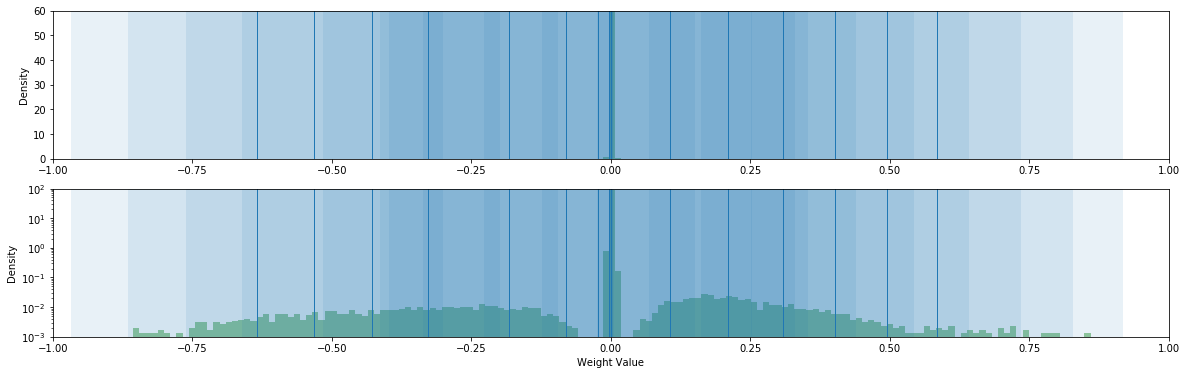

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.91
Epoch: 20. Test Accuracy: 97.71
Epoch: 30. Test Accuracy: 97.00
Epoch: 40. Test Accuracy: 96.57
Epoch: 50. Test Accuracy: 96.57
Retrain Test: 96.57, Retrain Validation: 96.36, Prune Test: 95.07, Prune Validation: 94.82, Prune Sparsity: 98.36


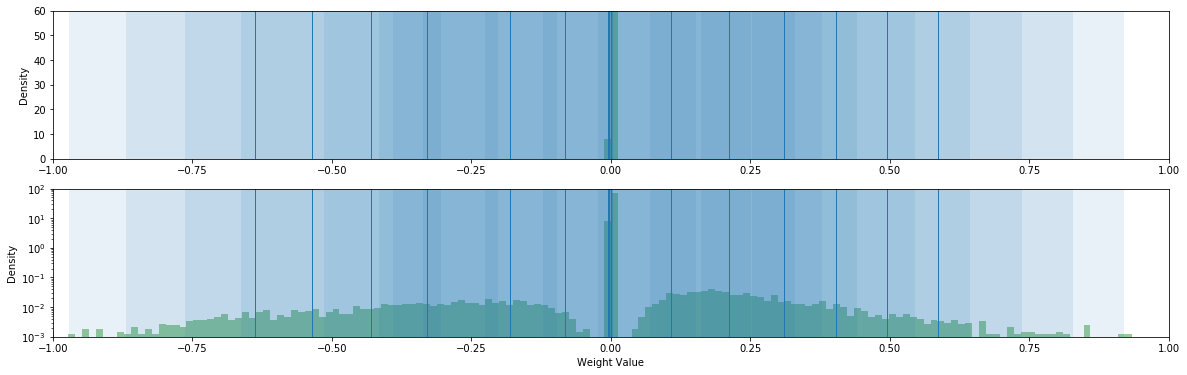

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.99
Epoch: 20. Test Accuracy: 97.62
Epoch: 30. Test Accuracy: 97.02
Epoch: 40. Test Accuracy: 96.60
Epoch: 50. Test Accuracy: 96.56
Retrain Test: 96.56, Retrain Validation: 96.29, Prune Test: 94.36, Prune Validation: 94.25, Prune Sparsity: 98.46


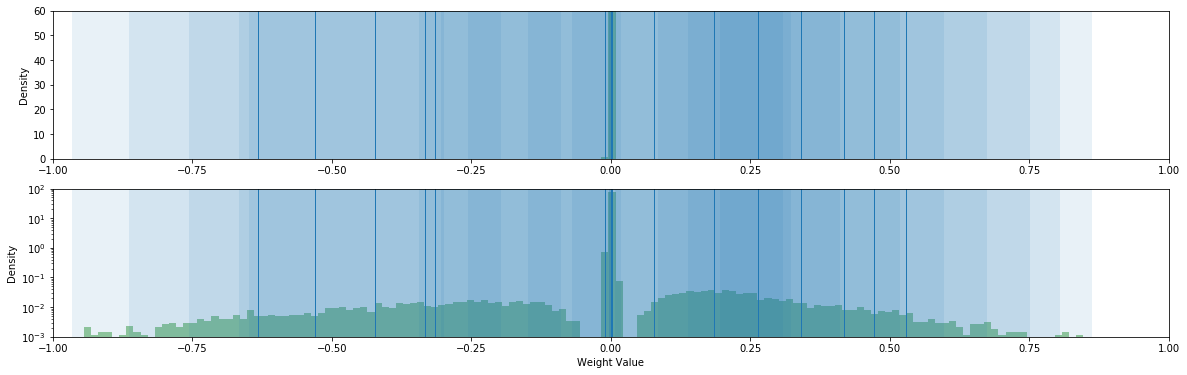

Temp: 4 Tau: 1e-06
Retrain Test: 95.84, Retrain Validation: 96.01, Prune Test: 92.41, Prune Validation: 92.45, Prune Sparsity: 98.93
Retrain Test: 96.57, Retrain Validation: 96.36, Prune Test: 95.07, Prune Validation: 94.82, Prune Sparsity: 98.36
Retrain Test: 96.56, Retrain Validation: 96.29, Prune Test: 94.36, Prune Validation: 94.25, Prune Sparsity: 98.46




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.96
Epoch: 20. Test Accuracy: 97.89
Epoch: 30. Test Accuracy: 98.07
Epoch: 40. Test Accuracy: 97.13
Epoch: 50. Test Accuracy: 97.45
Retrain Test: 97.45, Retrain Validation: 97.26, Prune Test: 92.86, Prune Validation: 92.36, Prune Sparsity: 94.55


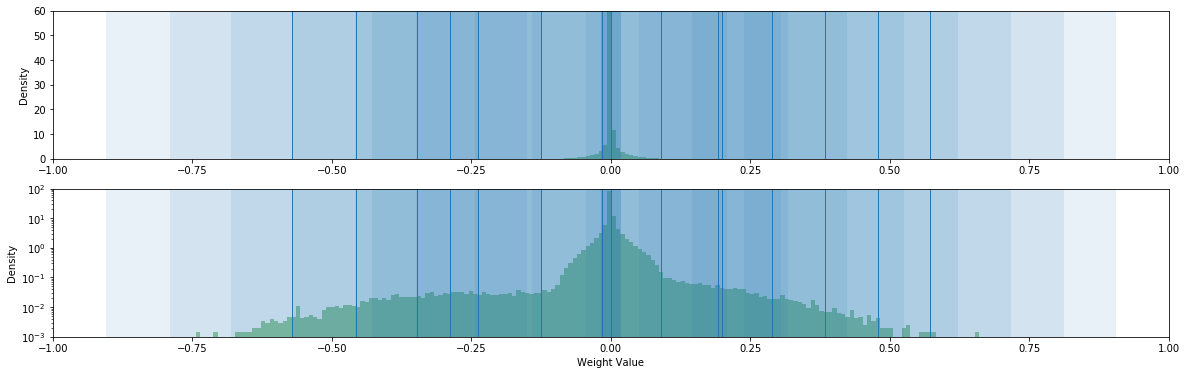

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.68
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 97.74
Epoch: 40. Test Accuracy: 98.06
Epoch: 50. Test Accuracy: 97.92
Retrain Test: 97.92, Retrain Validation: 97.80, Prune Test: 96.74, Prune Validation: 96.69, Prune Sparsity: 90.74


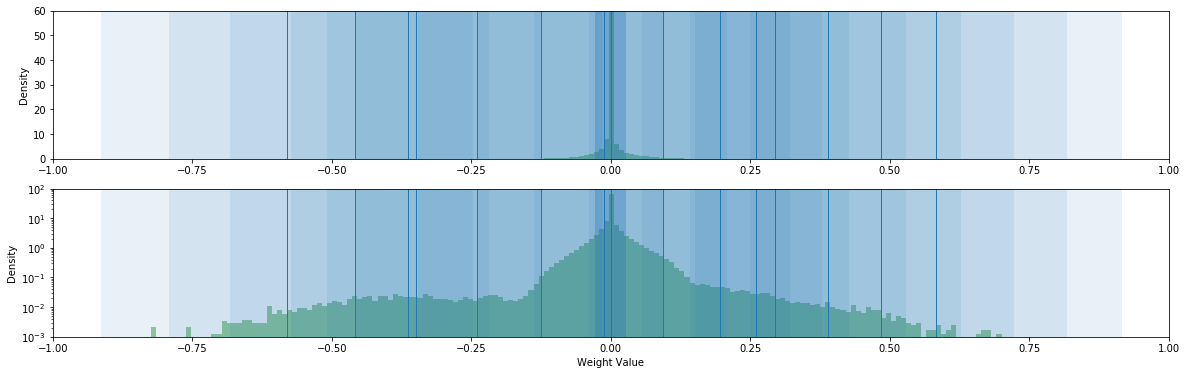

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.12
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 97.95
Epoch: 40. Test Accuracy: 97.90
Epoch: 50. Test Accuracy: 97.94
Retrain Test: 97.94, Retrain Validation: 97.85, Prune Test: 97.27, Prune Validation: 97.39, Prune Sparsity: 89.66


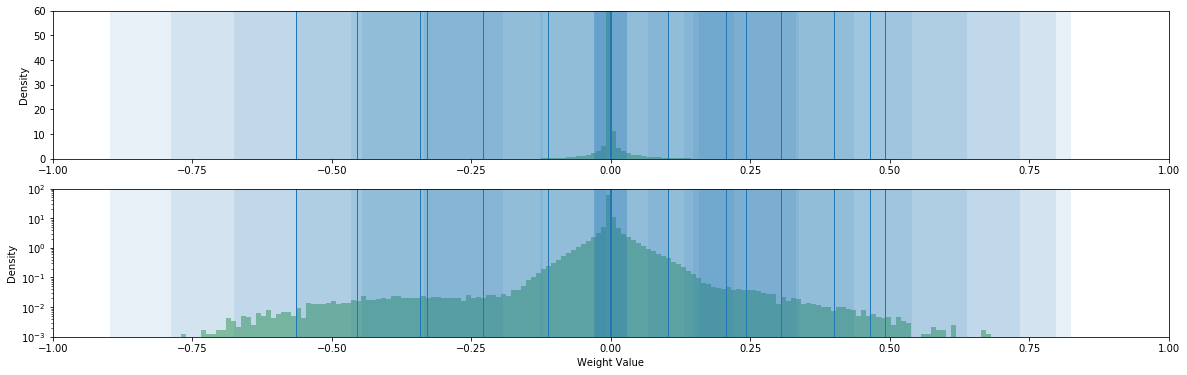

Temp: 4 Tau: 1e-07
Retrain Test: 97.45, Retrain Validation: 97.26, Prune Test: 92.86, Prune Validation: 92.36, Prune Sparsity: 94.55
Retrain Test: 97.92, Retrain Validation: 97.80, Prune Test: 96.74, Prune Validation: 96.69, Prune Sparsity: 90.74
Retrain Test: 97.94, Retrain Validation: 97.85, Prune Test: 97.27, Prune Validation: 97.39, Prune Sparsity: 89.66




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.06
Epoch: 20. Test Accuracy: 96.45
Epoch: 30. Test Accuracy: 97.99
Epoch: 40. Test Accuracy: 98.05
Epoch: 50. Test Accuracy: 98.08
Retrain Test: 98.08, Retrain Validation: 98.01, Prune Test: 97.81, Prune Validation: 97.83, Prune Sparsity: 62.06


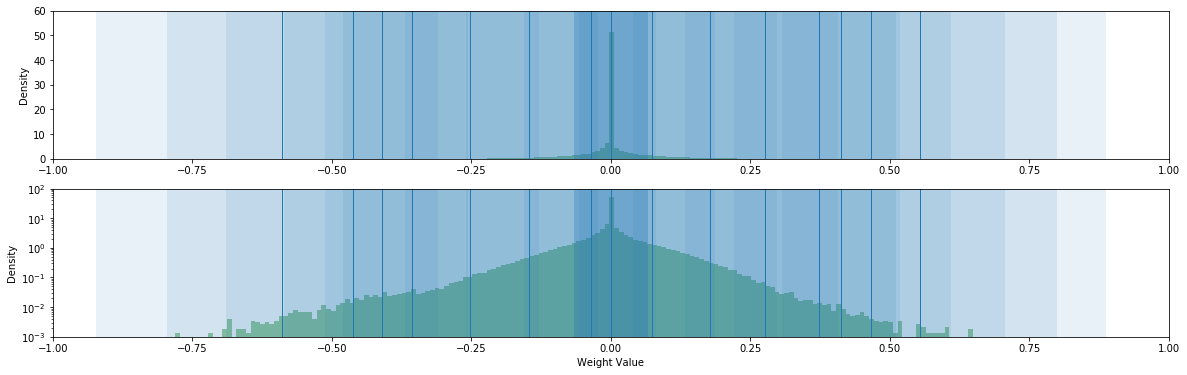

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.19
Epoch: 30. Test Accuracy: 98.15
Epoch: 40. Test Accuracy: 98.04
Epoch: 50. Test Accuracy: 98.24
Retrain Test: 98.24, Retrain Validation: 98.20, Prune Test: 98.03, Prune Validation: 98.00, Prune Sparsity: 59.59


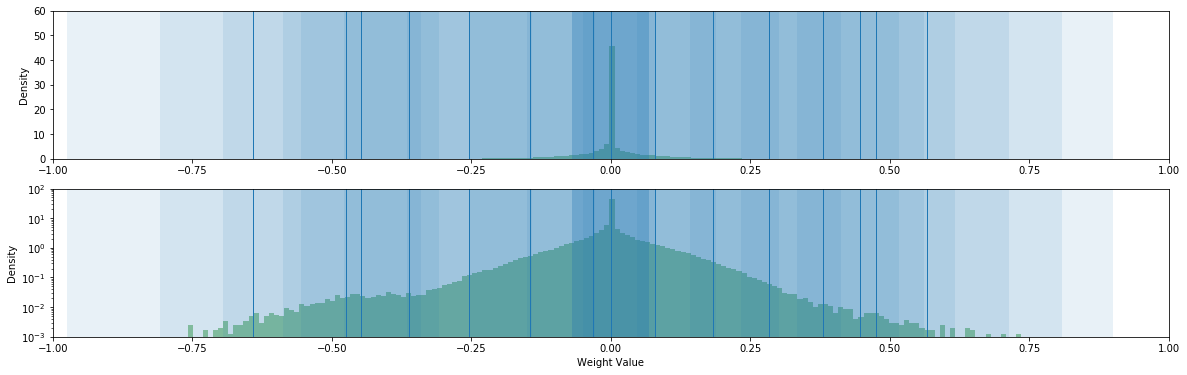

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 97.48
Epoch: 30. Test Accuracy: 98.23
Epoch: 40. Test Accuracy: 98.22
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.25, Prune Test: 97.57, Prune Validation: 97.67, Prune Sparsity: 74.15


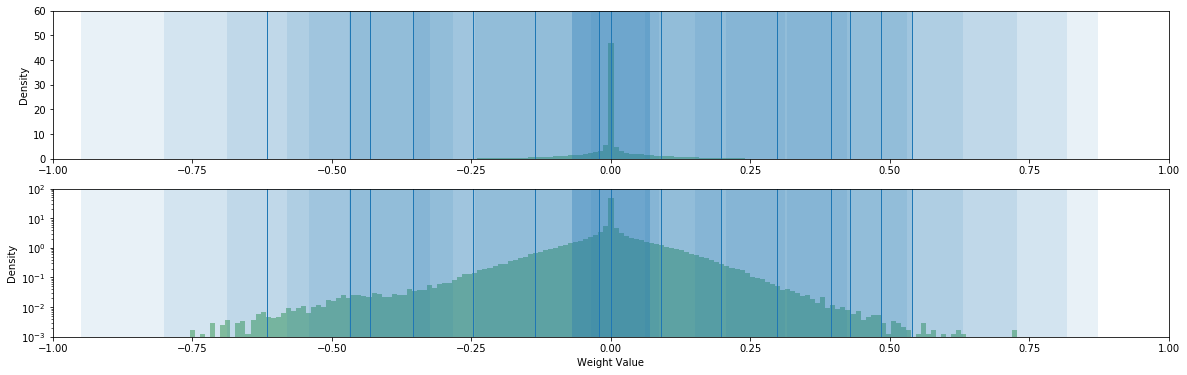

Temp: 4 Tau: 1e-08
Retrain Test: 98.08, Retrain Validation: 98.01, Prune Test: 97.81, Prune Validation: 97.83, Prune Sparsity: 62.06
Retrain Test: 98.24, Retrain Validation: 98.20, Prune Test: 98.03, Prune Validation: 98.00, Prune Sparsity: 59.59
Retrain Test: 98.26, Retrain Validation: 98.25, Prune Test: 97.57, Prune Validation: 97.67, Prune Sparsity: 74.15




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.68
Epoch: 20. Test Accuracy: 97.40
Epoch: 30. Test Accuracy: 96.86
Epoch: 40. Test Accuracy: 95.97
Epoch: 50. Test Accuracy: 95.83
Retrain Test: 95.83, Retrain Validation: 95.78, Prune Test: 91.66, Prune Validation: 92.01, Prune Sparsity: 98.91


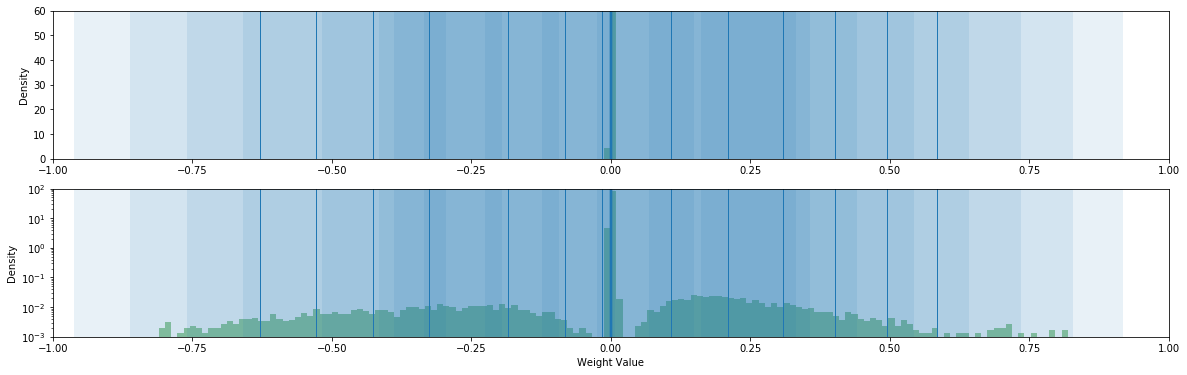

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.35
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.00
Epoch: 40. Test Accuracy: 97.76
Epoch: 50. Test Accuracy: 97.64
Retrain Test: 97.64, Retrain Validation: 97.18, Prune Test: 96.87, Prune Validation: 96.48, Prune Sparsity: 97.28


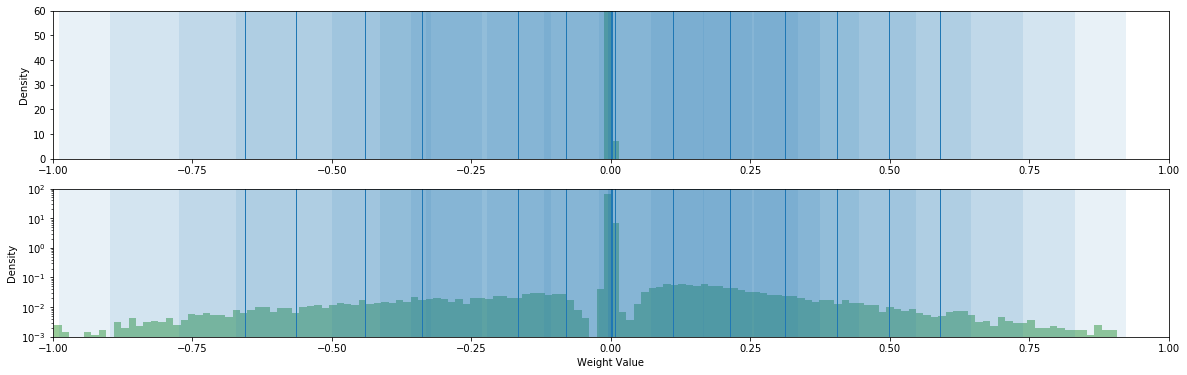

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.29
Epoch: 20. Test Accuracy: 98.08
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 97.81
Epoch: 50. Test Accuracy: 97.50
Retrain Test: 97.50, Retrain Validation: 97.51, Prune Test: 96.37, Prune Validation: 96.10, Prune Sparsity: 97.30


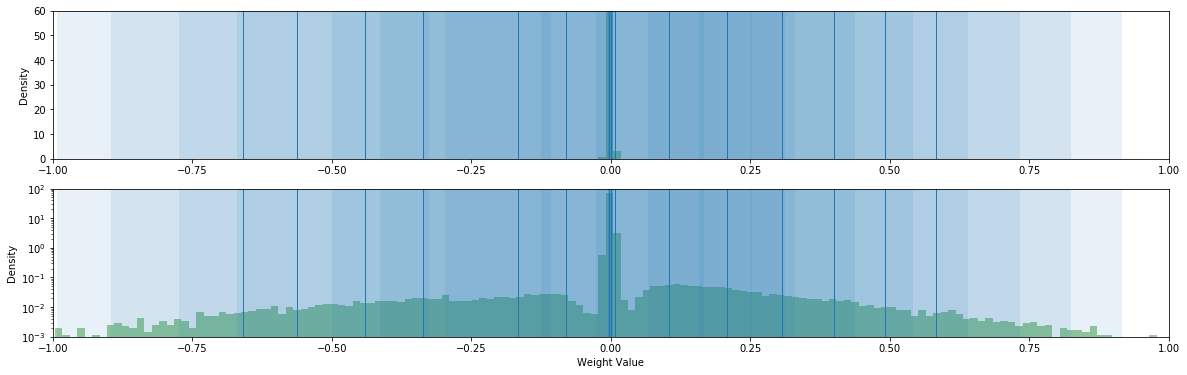

Temp: 10 Tau: 1e-06
Retrain Test: 95.83, Retrain Validation: 95.78, Prune Test: 91.66, Prune Validation: 92.01, Prune Sparsity: 98.91
Retrain Test: 97.64, Retrain Validation: 97.18, Prune Test: 96.87, Prune Validation: 96.48, Prune Sparsity: 97.28
Retrain Test: 97.50, Retrain Validation: 97.51, Prune Test: 96.37, Prune Validation: 96.10, Prune Sparsity: 97.30




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.79
Epoch: 20. Test Accuracy: 98.03
Epoch: 30. Test Accuracy: 97.95
Epoch: 40. Test Accuracy: 97.91
Epoch: 50. Test Accuracy: 97.54
Retrain Test: 97.54, Retrain Validation: 97.53, Prune Test: 94.05, Prune Validation: 94.17, Prune Sparsity: 94.78


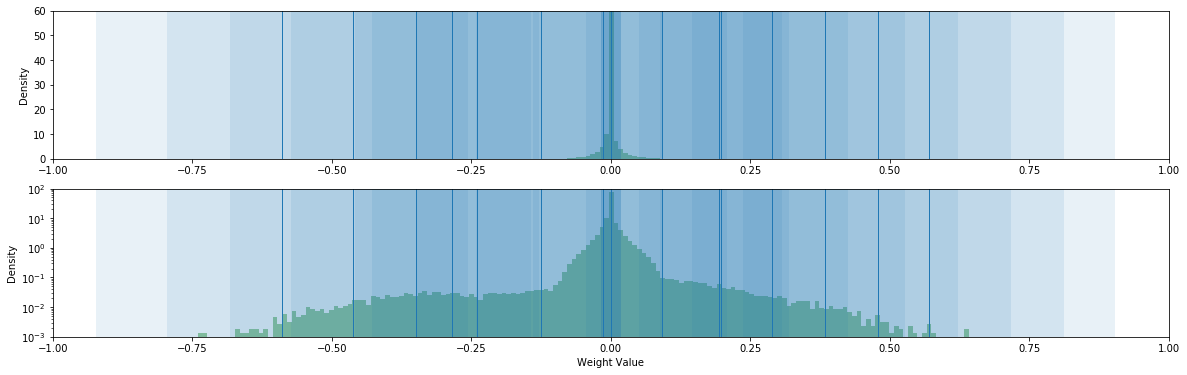

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.24
Epoch: 20. Test Accuracy: 98.32
Epoch: 30. Test Accuracy: 98.29
Epoch: 40. Test Accuracy: 98.25
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.22, Prune Test: 97.99, Prune Validation: 98.00, Prune Sparsity: 76.79


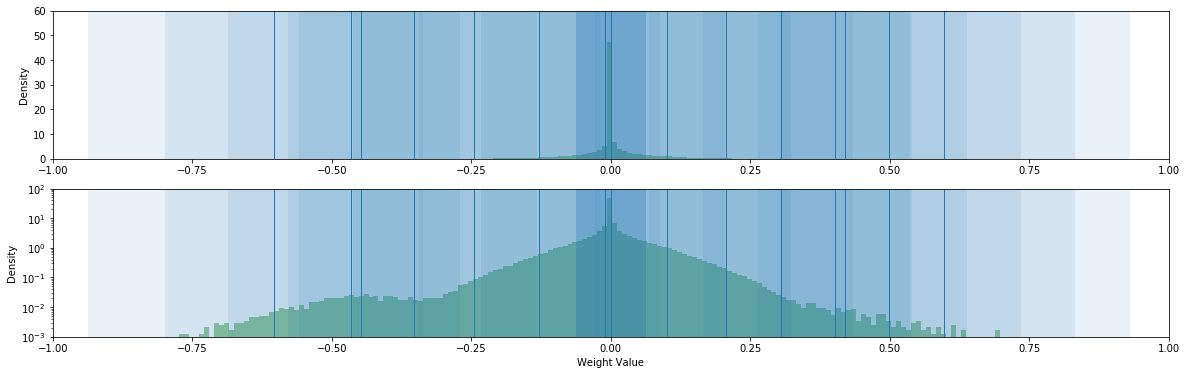

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.22
Epoch: 20. Test Accuracy: 98.27
Epoch: 30. Test Accuracy: 98.22
Epoch: 40. Test Accuracy: 98.29
Epoch: 50. Test Accuracy: 98.22
Retrain Test: 98.22, Retrain Validation: 98.28, Prune Test: 97.88, Prune Validation: 97.73, Prune Sparsity: 79.07


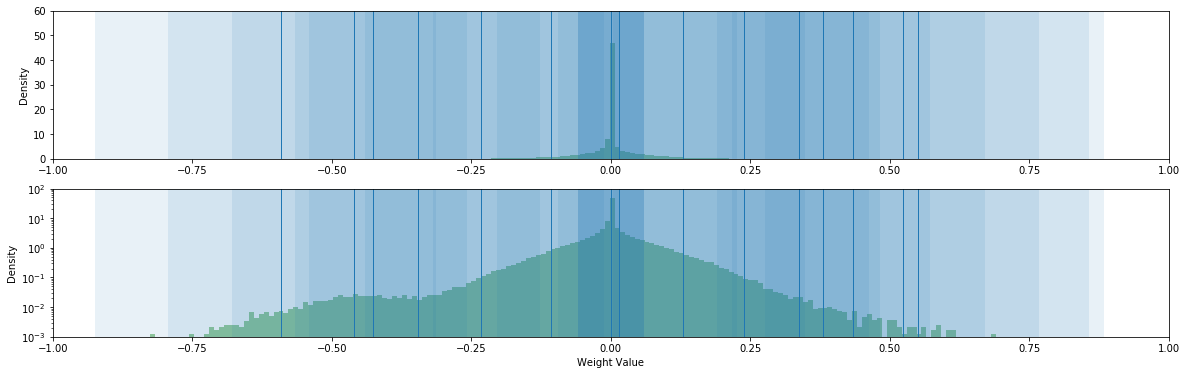

Temp: 10 Tau: 1e-07
Retrain Test: 97.54, Retrain Validation: 97.53, Prune Test: 94.05, Prune Validation: 94.17, Prune Sparsity: 94.78
Retrain Test: 98.26, Retrain Validation: 98.22, Prune Test: 97.99, Prune Validation: 98.00, Prune Sparsity: 76.79
Retrain Test: 98.22, Retrain Validation: 98.28, Prune Test: 97.88, Prune Validation: 97.73, Prune Sparsity: 79.07




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.95
Epoch: 20. Test Accuracy: 97.91
Epoch: 30. Test Accuracy: 97.95
Epoch: 40. Test Accuracy: 97.95
Epoch: 50. Test Accuracy: 98.00
Retrain Test: 98.00, Retrain Validation: 97.87, Prune Test: 97.54, Prune Validation: 97.57, Prune Sparsity: 63.69


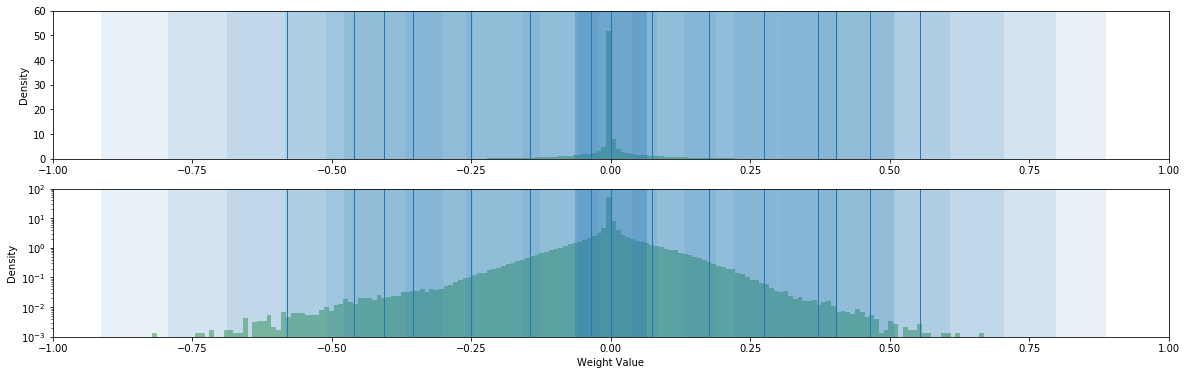

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.22
Epoch: 40. Test Accuracy: 98.18
Epoch: 50. Test Accuracy: 98.18
Retrain Test: 98.18, Retrain Validation: 98.12, Prune Test: 98.04, Prune Validation: 97.95, Prune Sparsity: 47.88


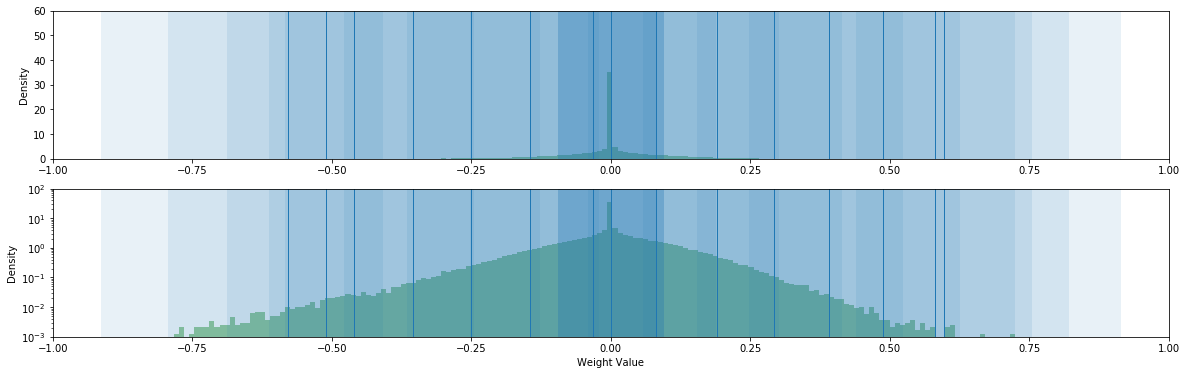

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25
Epoch: 20. Test Accuracy: 98.25
Epoch: 30. Test Accuracy: 98.17
Epoch: 40. Test Accuracy: 98.29
Epoch: 50. Test Accuracy: 98.22
Retrain Test: 98.22, Retrain Validation: 98.17, Prune Test: 97.97, Prune Validation: 98.00, Prune Sparsity: 49.16


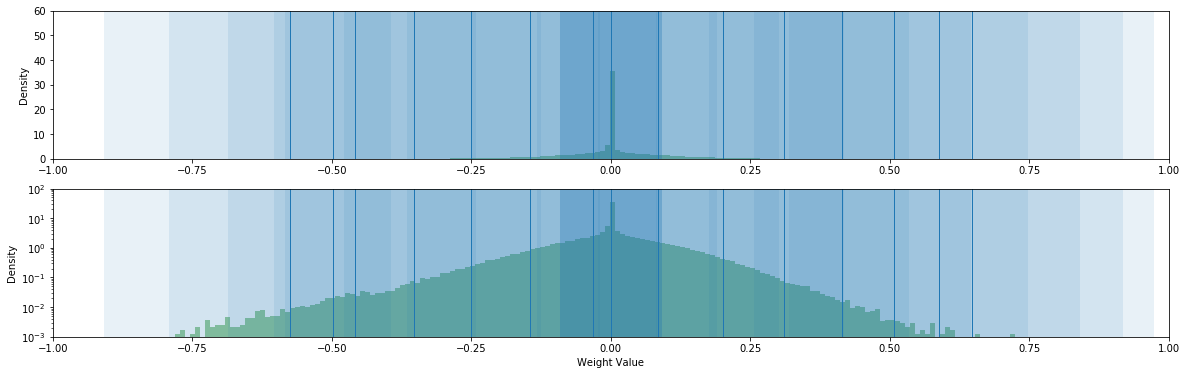

Temp: 10 Tau: 1e-08
Retrain Test: 98.00, Retrain Validation: 97.87, Prune Test: 97.54, Prune Validation: 97.57, Prune Sparsity: 63.69
Retrain Test: 98.18, Retrain Validation: 98.12, Prune Test: 98.04, Prune Validation: 97.95, Prune Sparsity: 47.88
Retrain Test: 98.22, Retrain Validation: 98.17, Prune Test: 97.97, Prune Validation: 98.00, Prune Sparsity: 49.16




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.59
Epoch: 20. Test Accuracy: 97.61
Epoch: 30. Test Accuracy: 96.57
Epoch: 40. Test Accuracy: 96.01
Epoch: 50. Test Accuracy: 95.90
Retrain Test: 95.90, Retrain Validation: 95.92, Prune Test: 92.97, Prune Validation: 92.78, Prune Sparsity: 98.90


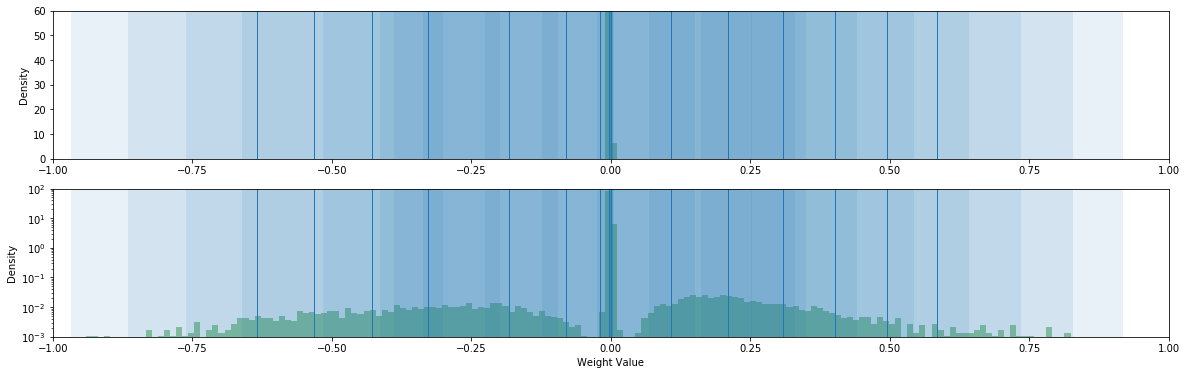

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.21
Epoch: 20. Test Accuracy: 98.24
Epoch: 30. Test Accuracy: 98.14
Epoch: 40. Test Accuracy: 98.15
Epoch: 50. Test Accuracy: 98.08
Retrain Test: 98.08, Retrain Validation: 98.08, Prune Test: 95.73, Prune Validation: 95.79, Prune Sparsity: 94.10


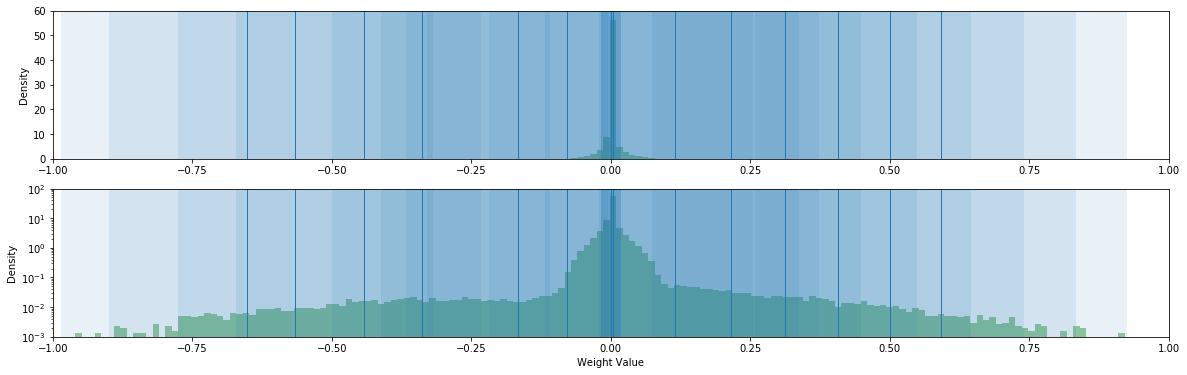

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.13
Epoch: 40. Test Accuracy: 98.15
Epoch: 50. Test Accuracy: 98.10
Retrain Test: 98.10, Retrain Validation: 98.07, Prune Test: 97.17, Prune Validation: 97.27, Prune Sparsity: 93.32


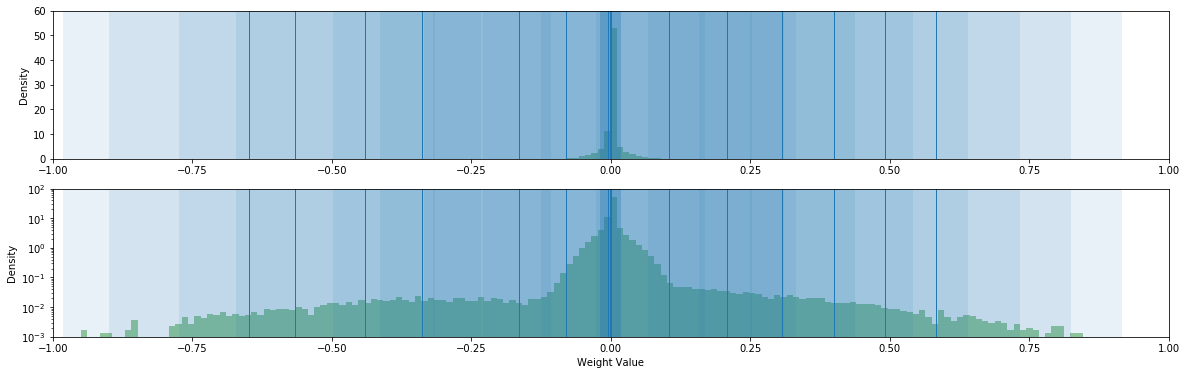

Temp: 20 Tau: 1e-06
Retrain Test: 95.90, Retrain Validation: 95.92, Prune Test: 92.97, Prune Validation: 92.78, Prune Sparsity: 98.90
Retrain Test: 98.08, Retrain Validation: 98.08, Prune Test: 95.73, Prune Validation: 95.79, Prune Sparsity: 94.10
Retrain Test: 98.10, Retrain Validation: 98.07, Prune Test: 97.17, Prune Validation: 97.27, Prune Sparsity: 93.32




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.05
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.85
Epoch: 50. Test Accuracy: 97.82
Retrain Test: 97.82, Retrain Validation: 97.82, Prune Test: 93.85, Prune Validation: 93.42, Prune Sparsity: 94.12


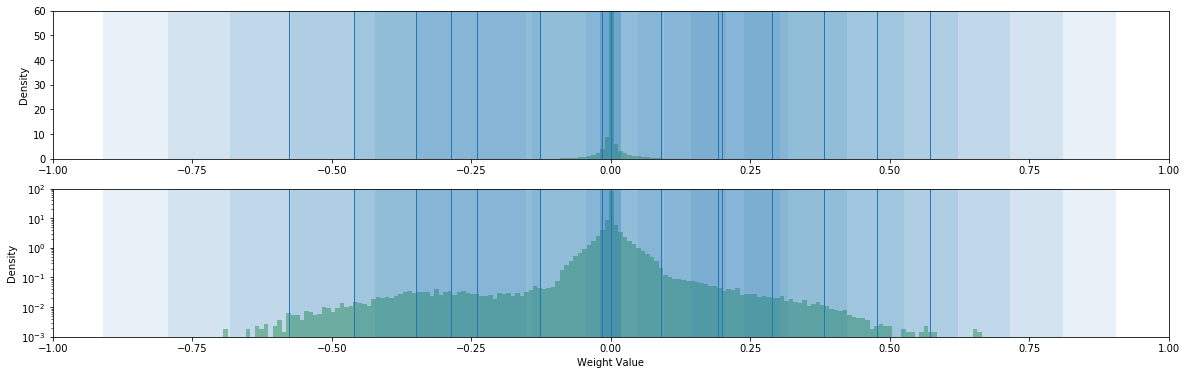

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25
Epoch: 20. Test Accuracy: 98.28
Epoch: 30. Test Accuracy: 98.28
Epoch: 40. Test Accuracy: 98.23
Epoch: 50. Test Accuracy: 98.25
Retrain Test: 98.25, Retrain Validation: 98.24, Prune Test: 98.04, Prune Validation: 97.97, Prune Sparsity: 71.92


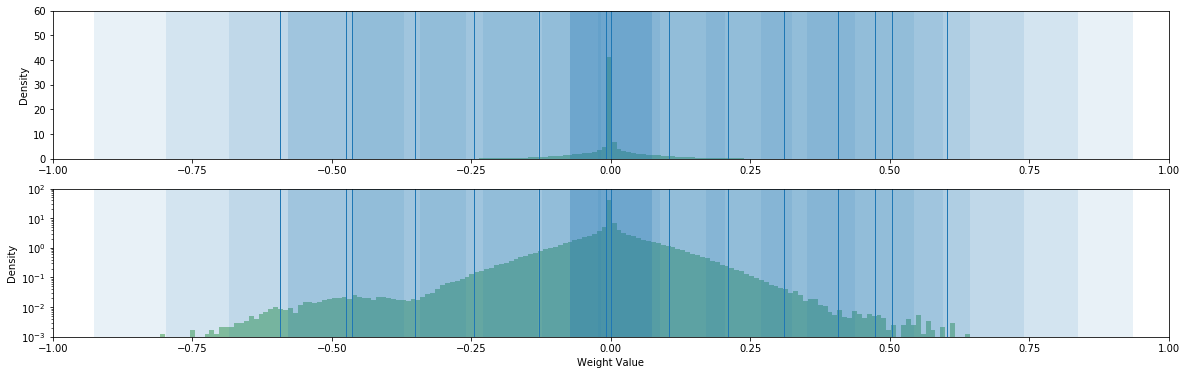

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.23
Epoch: 20. Test Accuracy: 98.26
Epoch: 30. Test Accuracy: 98.25
Epoch: 40. Test Accuracy: 98.25
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.20, Prune Test: 97.21, Prune Validation: 96.95, Prune Sparsity: 75.83


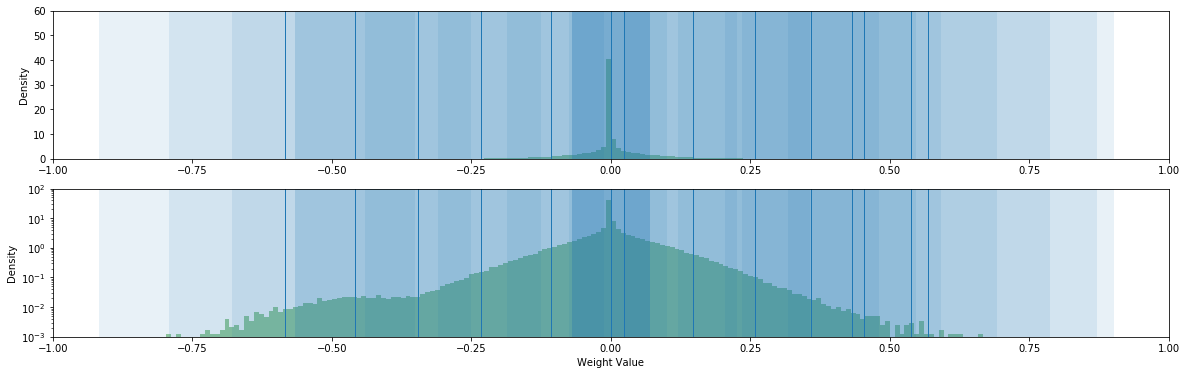

Temp: 20 Tau: 1e-07
Retrain Test: 97.82, Retrain Validation: 97.82, Prune Test: 93.85, Prune Validation: 93.42, Prune Sparsity: 94.12
Retrain Test: 98.25, Retrain Validation: 98.24, Prune Test: 98.04, Prune Validation: 97.97, Prune Sparsity: 71.92
Retrain Test: 98.26, Retrain Validation: 98.20, Prune Test: 97.21, Prune Validation: 96.95, Prune Sparsity: 75.83




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.04
Epoch: 20. Test Accuracy: 98.07
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 98.00
Epoch: 50. Test Accuracy: 97.96
Retrain Test: 97.96, Retrain Validation: 98.05, Prune Test: 97.77, Prune Validation: 97.72, Prune Sparsity: 65.09


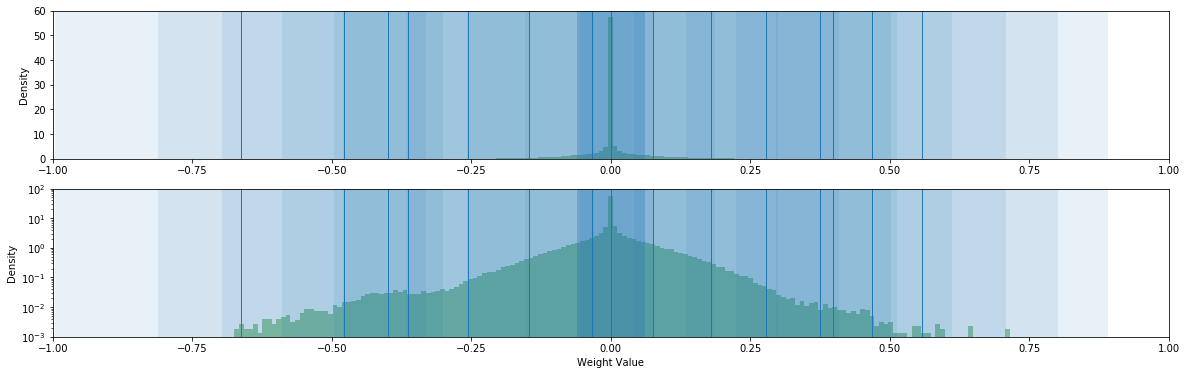

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.22
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.22
Epoch: 40. Test Accuracy: 98.21
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.19, Prune Test: 98.07, Prune Validation: 97.91, Prune Sparsity: 44.51


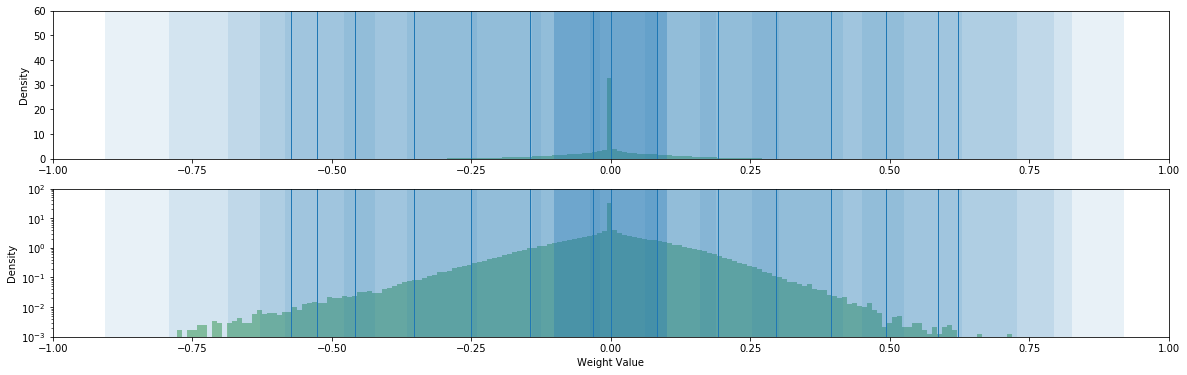

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.26
Epoch: 20. Test Accuracy: 98.18
Epoch: 30. Test Accuracy: 98.23
Epoch: 40. Test Accuracy: 98.23
Epoch: 50. Test Accuracy: 98.21
Retrain Test: 98.21, Retrain Validation: 98.20, Prune Test: 97.93, Prune Validation: 98.07, Prune Sparsity: 44.36


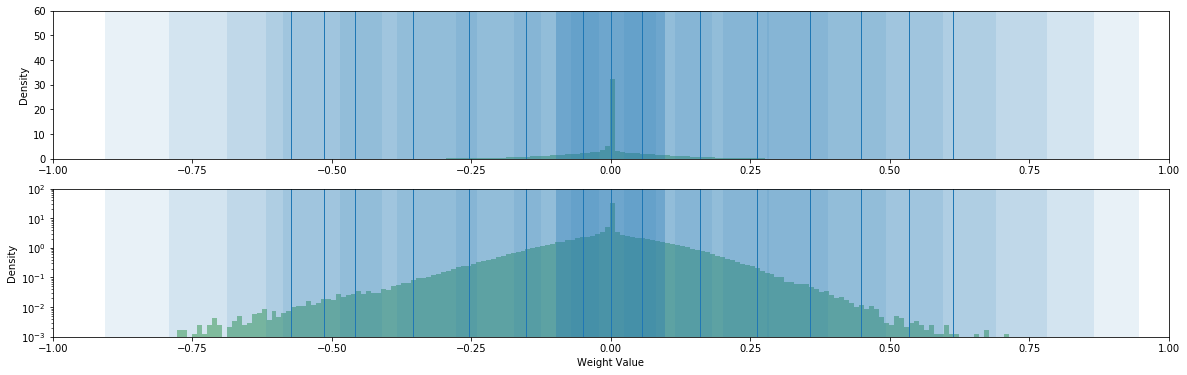

Temp: 20 Tau: 1e-08
Retrain Test: 97.96, Retrain Validation: 98.05, Prune Test: 97.77, Prune Validation: 97.72, Prune Sparsity: 65.09
Retrain Test: 98.26, Retrain Validation: 98.19, Prune Test: 98.07, Prune Validation: 97.91, Prune Sparsity: 44.51
Retrain Test: 98.21, Retrain Validation: 98.20, Prune Test: 97.93, Prune Validation: 98.07, Prune Sparsity: 44.36


Temp: 1 Tau: 1e-06
Retrain Test: 95.90, Retrain Validation: 95.81, Prune Test: 91.75, Prune Validation: 91.90, Prune Sparsity: 98.94
Retrain Test: 89.52, Retrain Validation: 89.58, Prune Test: 38.02, Prune Validation: 39.63, Prune Sparsity: 99.77
Retrain Test: 89.77, Retrain Validation: 90.49, Prune Test: 52.40, Prune Validation: 54.63, Prune Sparsity: 99.75

Temp: 1 Tau: 1e-07
Retrain Test: 97.64, Retrain Validation: 97.56, Prune Test: 91.25, Prune Validation: 90.93, Prune Sparsity: 94.26
Retrain Test: 96.28, Retrain Validation: 95.96, Prune Test: 92.46, Prune Validation: 92.69, Prune Sparsity: 98.78
Retrain Test: 96.24, Retrai

<IPython.core.display.Javascript object>

In [7]:
%%notify
res_str = ""
for temp in [1, 2, 4, 10, 20]:
    for tau in [1e-6, 1e-7, 1e-8]:
        _, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name)
        res_str = res_str + res
print (res_str)

### Loss Function Mean - Mean Experiment

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 98.13
Epoch: 20. Test Accuracy: 98.13
Epoch: 30. Test Accuracy: 97.98
Epoch: 40. Test Accuracy: 97.85
Epoch: 50. Test Accuracy: 97.81
Retrain Test: 97.81, Retrain Validation: 97.56, Prune Test: 96.91, Prune Validation: 96.75, Prune Sparsity: 94.35


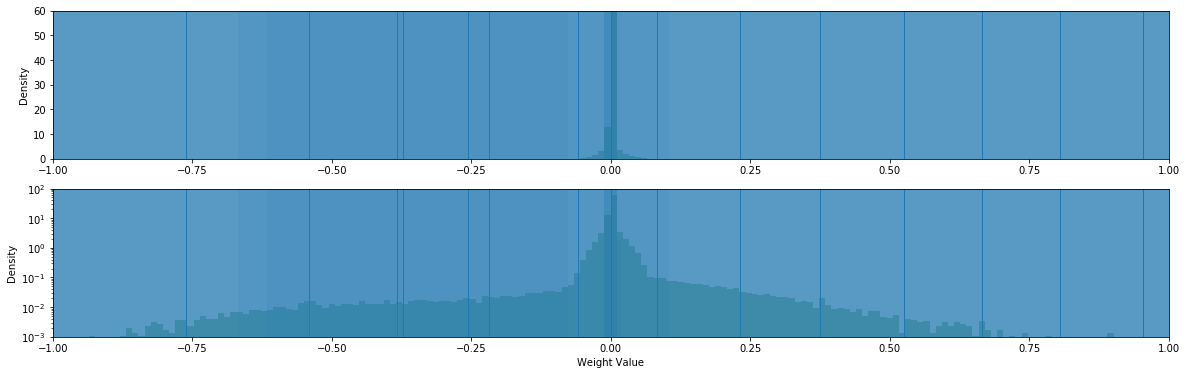

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 97.71
Epoch: 20. Test Accuracy: 97.20
Epoch: 30. Test Accuracy: 96.03
Epoch: 40. Test Accuracy: 94.42
Epoch: 50. Test Accuracy: 94.36
Retrain Test: 94.36, Retrain Validation: 94.43, Prune Test: 91.44, Prune Validation: 91.76, Prune Sparsity: 99.04


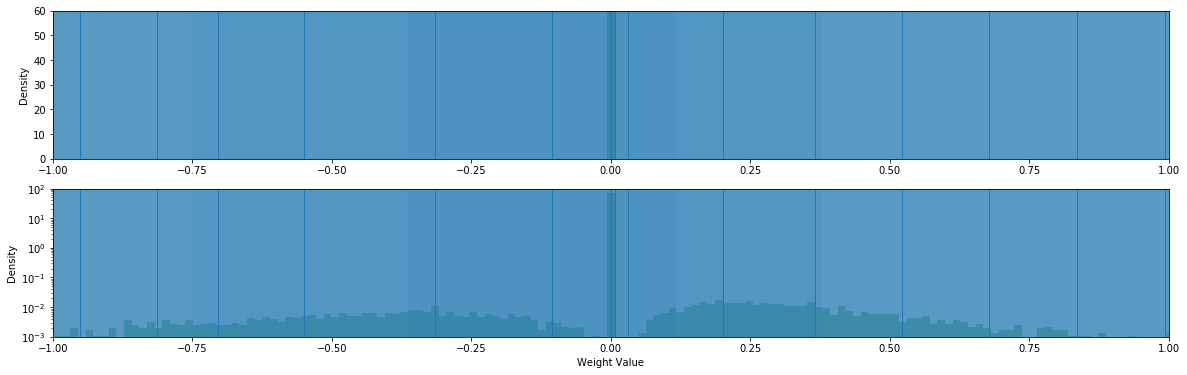

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 24.96
Terminating Search - Epoch: 13 - Val Acc: 33.22
Retrain Test: 31.97, Retrain Validation: 33.22, Prune Test: 25.29, Prune Validation: 24.57, Prune Sparsity: 44.89


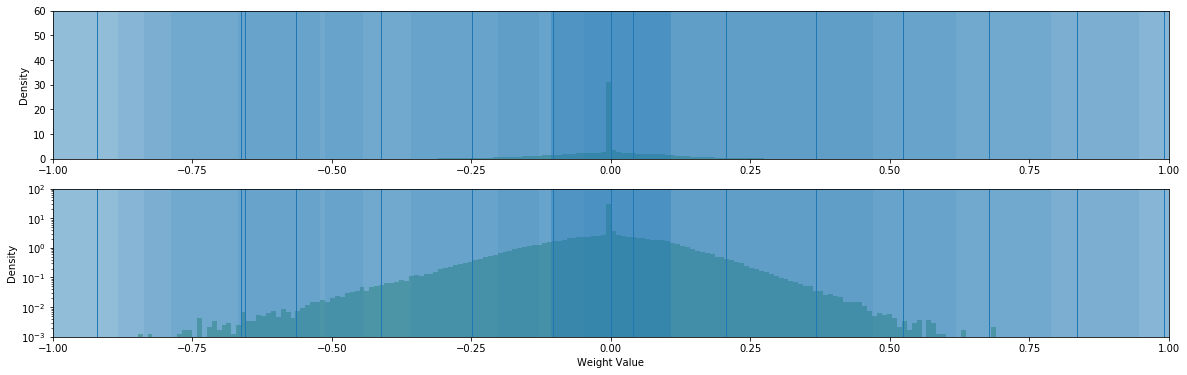

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 98.15
Epoch: 20. Test Accuracy: 98.10
Epoch: 30. Test Accuracy: 98.02
Epoch: 40. Test Accuracy: 97.94
Epoch: 50. Test Accuracy: 97.68
Retrain Test: 97.68, Retrain Validation: 97.60, Prune Test: 96.29, Prune Validation: 96.26, Prune Sparsity: 94.70


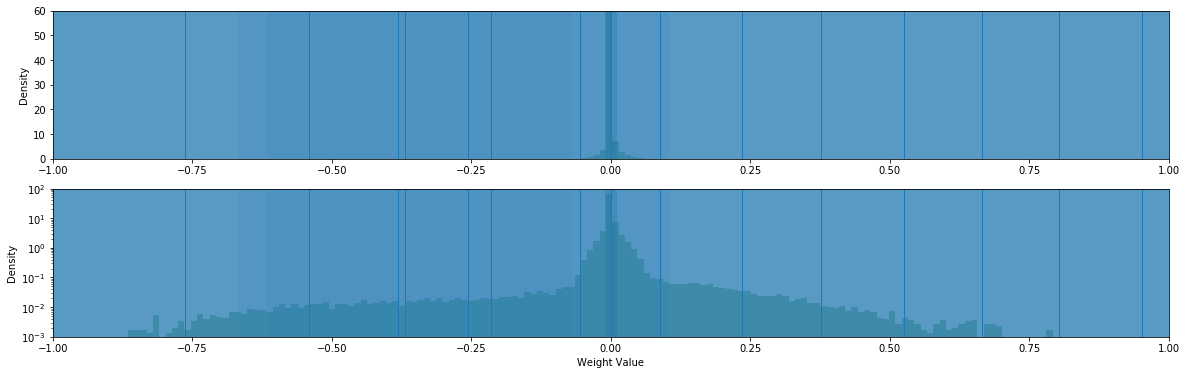

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 97.70
Epoch: 20. Test Accuracy: 97.11
Epoch: 30. Test Accuracy: 95.74
Epoch: 40. Test Accuracy: 94.57
Epoch: 50. Test Accuracy: 94.43
Retrain Test: 94.43, Retrain Validation: 94.64, Prune Test: 92.36, Prune Validation: 92.83, Prune Sparsity: 99.04


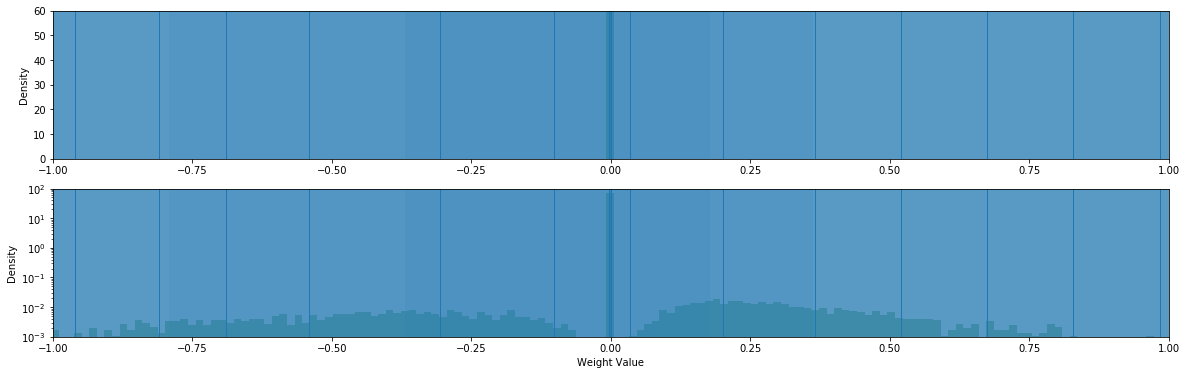

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 33.49
Terminating Search - Epoch: 13 - Val Acc: 42.49
Retrain Test: 41.56, Retrain Validation: 42.49, Prune Test: 30.35, Prune Validation: 31.58, Prune Sparsity: 44.69


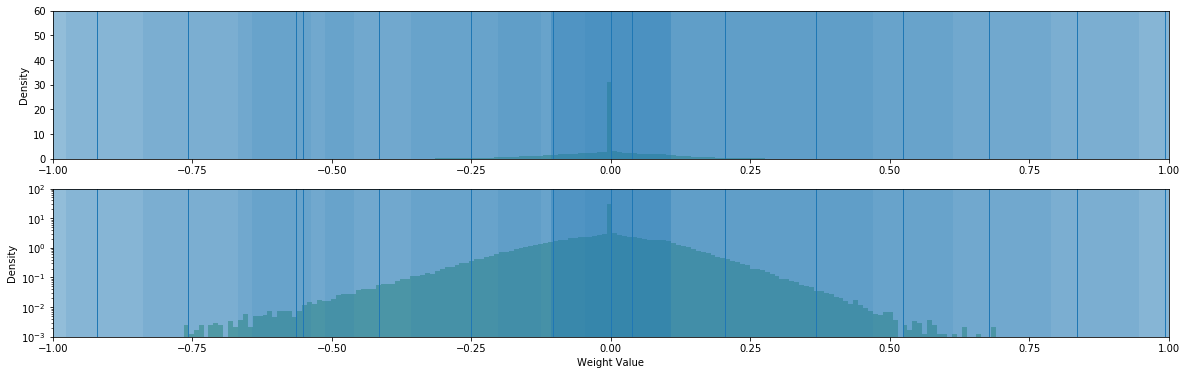

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 98.17
Epoch: 20. Test Accuracy: 98.25
Epoch: 30. Test Accuracy: 97.86
Epoch: 40. Test Accuracy: 97.86
Epoch: 50. Test Accuracy: 97.57
Retrain Test: 97.57, Retrain Validation: 97.63, Prune Test: 96.59, Prune Validation: 96.49, Prune Sparsity: 94.91


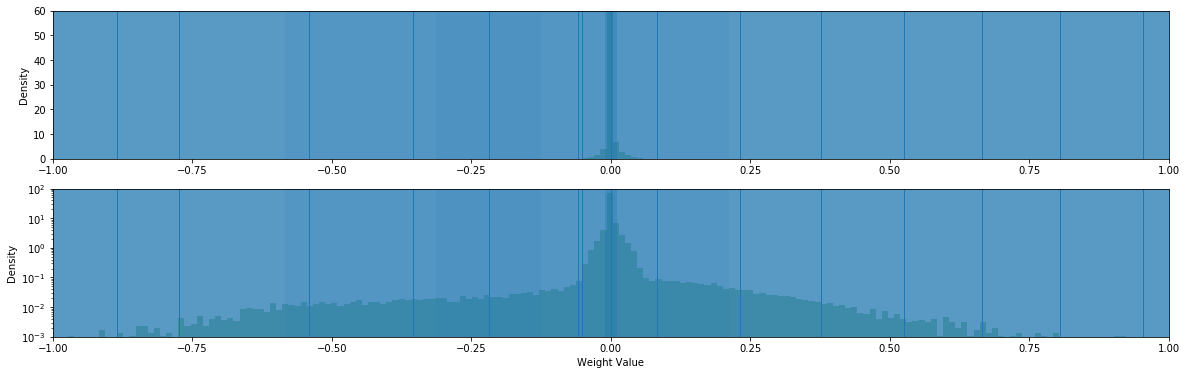

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 97.99
Epoch: 20. Test Accuracy: 97.18
Epoch: 30. Test Accuracy: 95.90
Epoch: 40. Test Accuracy: 94.82
Epoch: 50. Test Accuracy: 94.68
Retrain Test: 94.68, Retrain Validation: 94.91, Prune Test: 93.02, Prune Validation: 93.48, Prune Sparsity: 99.06


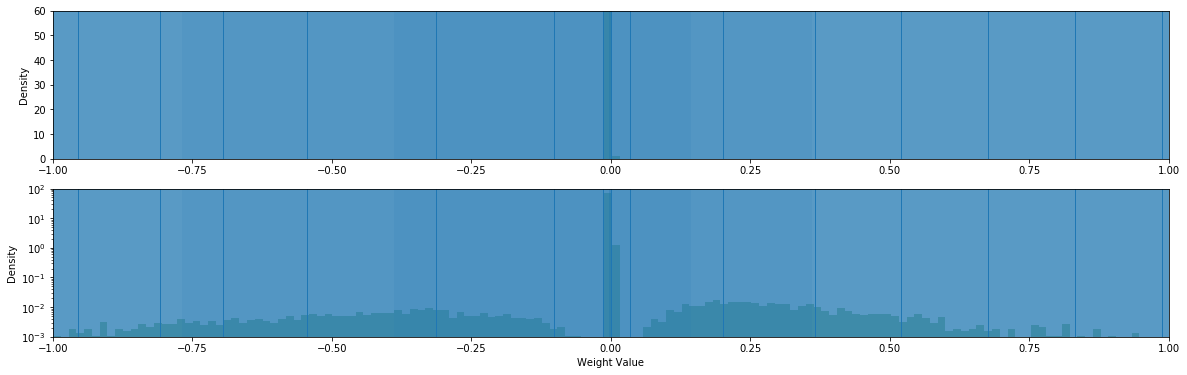

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 45.59
Epoch: 20. Test Accuracy: 64.48
Epoch: 30. Test Accuracy: 82.04
Epoch: 40. Test Accuracy: 86.76
Epoch: 50. Test Accuracy: 89.42
Retrain Test: 89.42, Retrain Validation: 89.85, Prune Test: 42.42, Prune Validation: 42.83, Prune Sparsity: 46.49


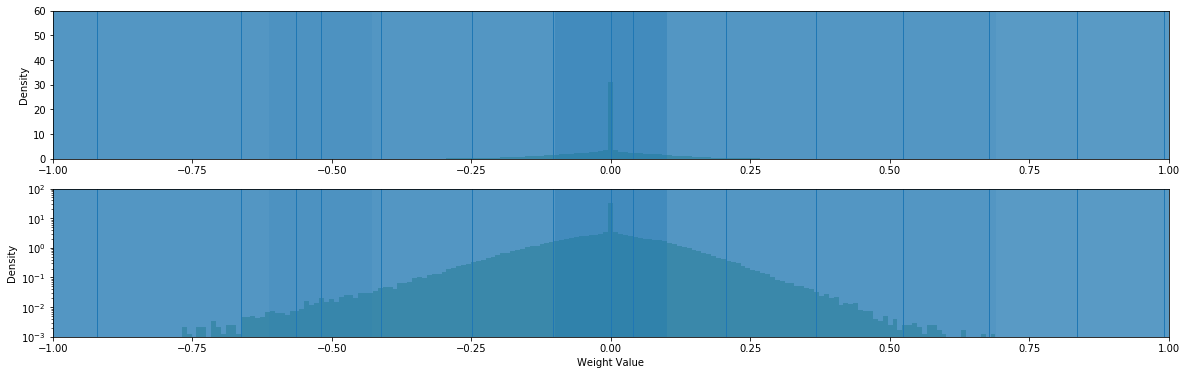

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 98.23
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 97.94
Epoch: 50. Test Accuracy: 97.89
Retrain Test: 97.89, Retrain Validation: 97.66, Prune Test: 97.14, Prune Validation: 97.05, Prune Sparsity: 92.31


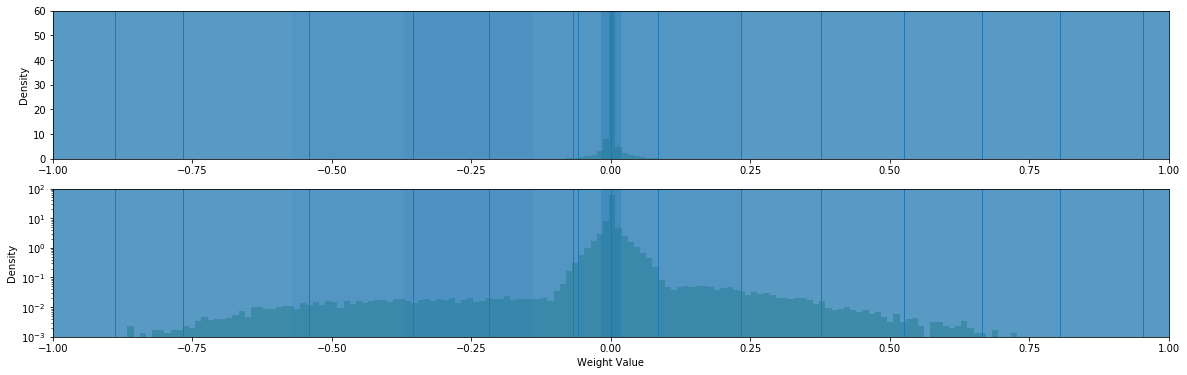

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 97.82
Epoch: 20. Test Accuracy: 97.07
Epoch: 30. Test Accuracy: 96.51
Epoch: 40. Test Accuracy: 95.97
Epoch: 50. Test Accuracy: 96.22
Retrain Test: 96.22, Retrain Validation: 96.17, Prune Test: 85.84, Prune Validation: 86.00, Prune Sparsity: 98.84


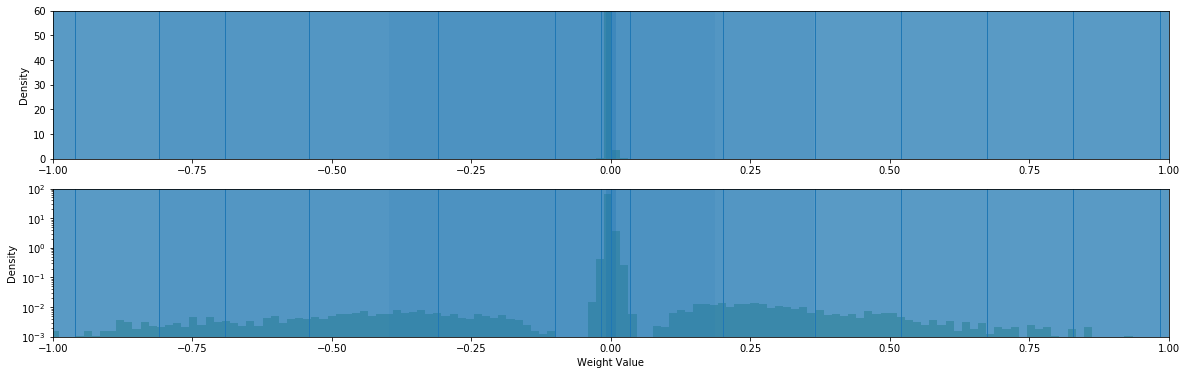

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 40.50
Epoch: 20. Test Accuracy: 57.51
Epoch: 30. Test Accuracy: 64.43
Epoch: 40. Test Accuracy: 75.16
Epoch: 50. Test Accuracy: 79.48
Retrain Test: 79.48, Retrain Validation: 80.35, Prune Test: 37.59, Prune Validation: 37.86, Prune Sparsity: 46.67


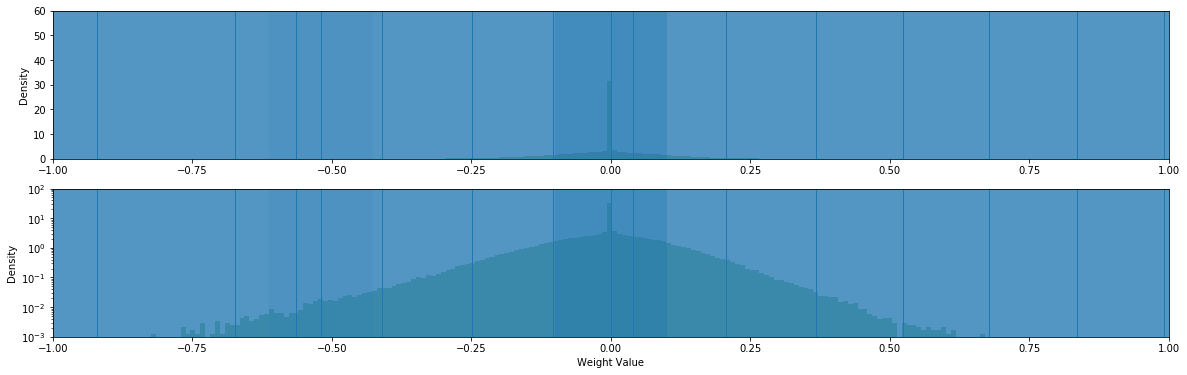

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 98.12
Epoch: 20. Test Accuracy: 98.14
Epoch: 30. Test Accuracy: 98.00
Epoch: 40. Test Accuracy: 97.90
Epoch: 50. Test Accuracy: 97.82
Retrain Test: 97.82, Retrain Validation: 97.61, Prune Test: 96.20, Prune Validation: 96.24, Prune Sparsity: 91.27


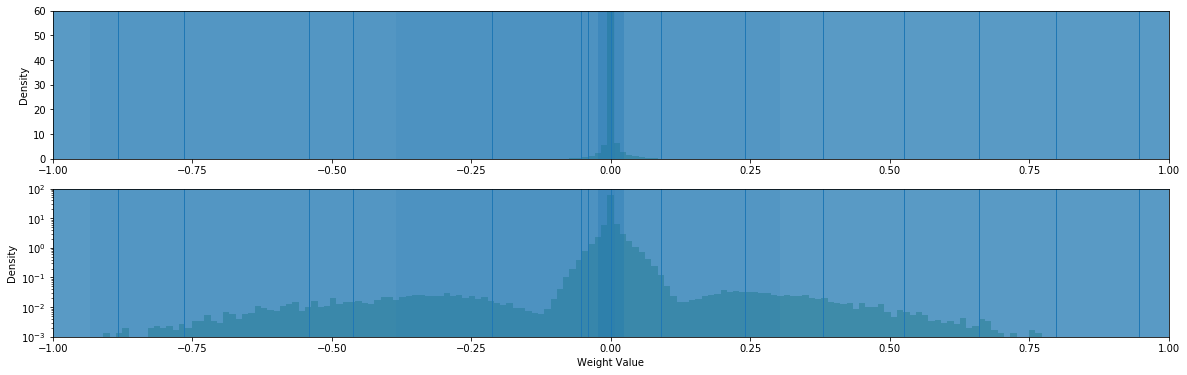

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 97.73
Epoch: 20. Test Accuracy: 97.28
Epoch: 30. Test Accuracy: 96.73
Epoch: 40. Test Accuracy: 96.83
Epoch: 50. Test Accuracy: 96.72
Retrain Test: 96.72, Retrain Validation: 96.55, Prune Test: 93.64, Prune Validation: 93.81, Prune Sparsity: 95.91


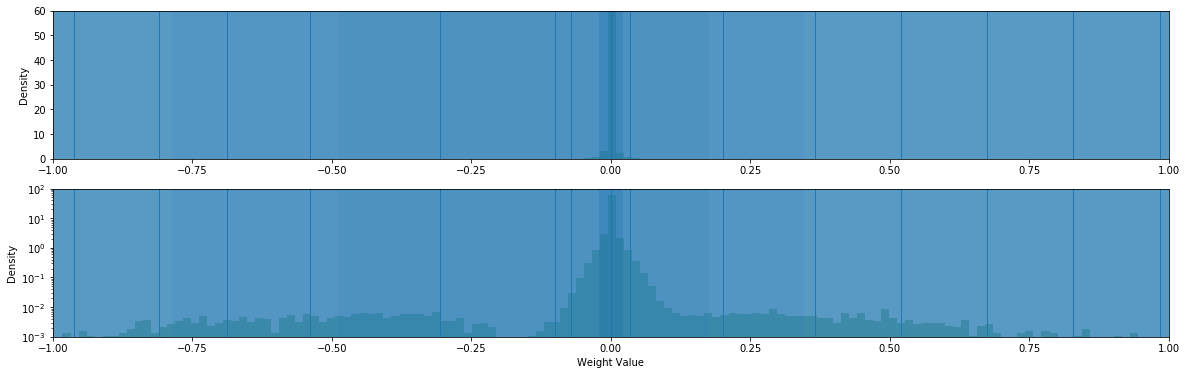

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 29.87
Terminating Search - Epoch: 13 - Val Acc: 36.28
Retrain Test: 35.55, Retrain Validation: 36.28, Prune Test: 19.02, Prune Validation: 19.84, Prune Sparsity: 45.78


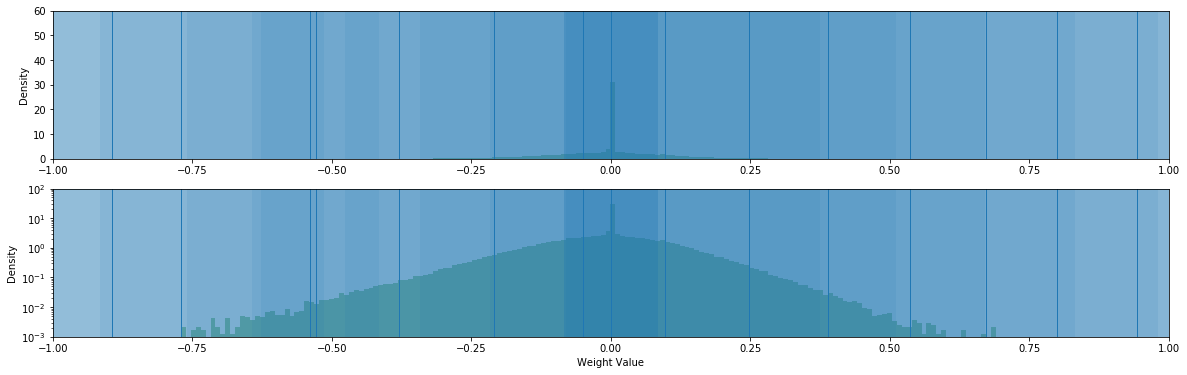

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 98.11
Epoch: 20. Test Accuracy: 98.05
Epoch: 30. Test Accuracy: 97.83
Epoch: 40. Test Accuracy: 97.94
Epoch: 50. Test Accuracy: 97.89
Retrain Test: 97.89, Retrain Validation: 97.73, Prune Test: 97.13, Prune Validation: 96.55, Prune Sparsity: 95.47


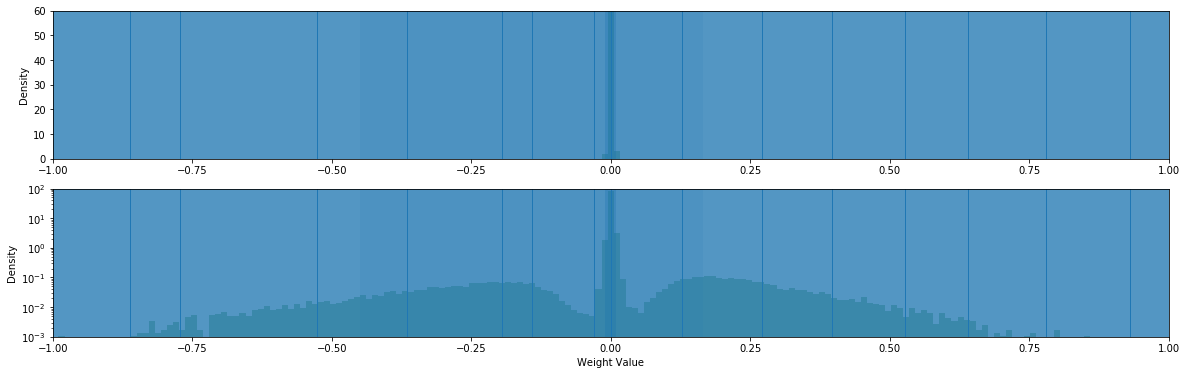

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 97.55
Epoch: 20. Test Accuracy: 97.16
Epoch: 30. Test Accuracy: 96.33
Epoch: 40. Test Accuracy: 96.30
Epoch: 50. Test Accuracy: 96.59
Retrain Test: 96.59, Retrain Validation: 96.30, Prune Test: 90.79, Prune Validation: 90.88, Prune Sparsity: 98.79


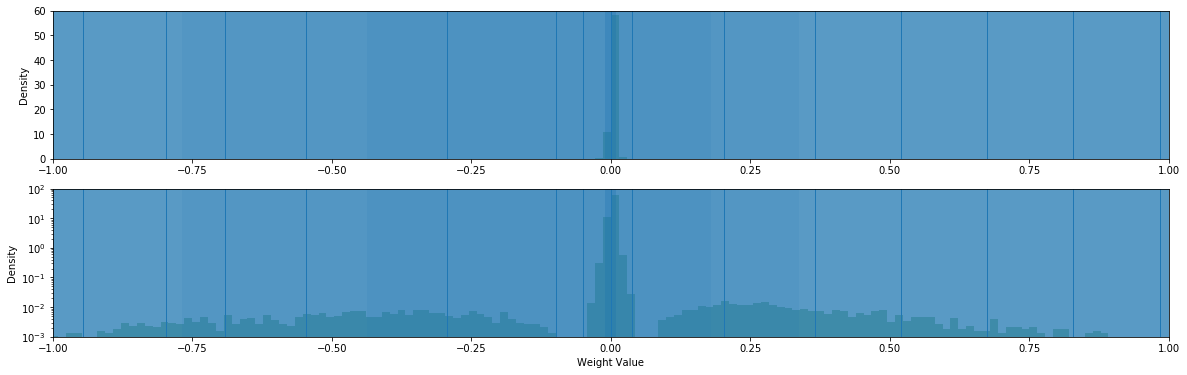

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 0.10000000000000002 Variance: 2.0
Epoch: 10. Test Accuracy: 38.50
Terminating Search - Epoch: 13 - Val Acc: 45.60
Retrain Test: 44.15, Retrain Validation: 45.60, Prune Test: 44.32, Prune Validation: 46.31, Prune Sparsity: 67.62


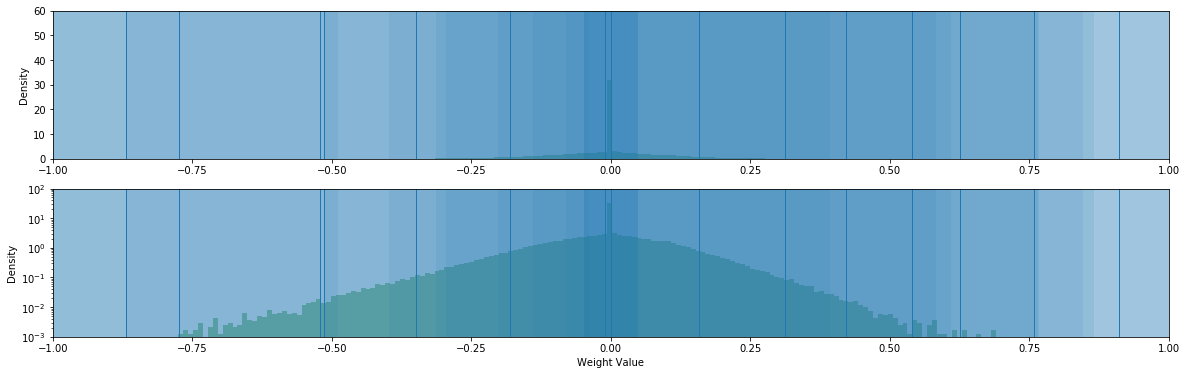

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.20
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 97.86
Epoch: 50. Test Accuracy: 97.64
Retrain Test: 97.64, Retrain Validation: 97.53, Prune Test: 96.20, Prune Validation: 96.30, Prune Sparsity: 95.44


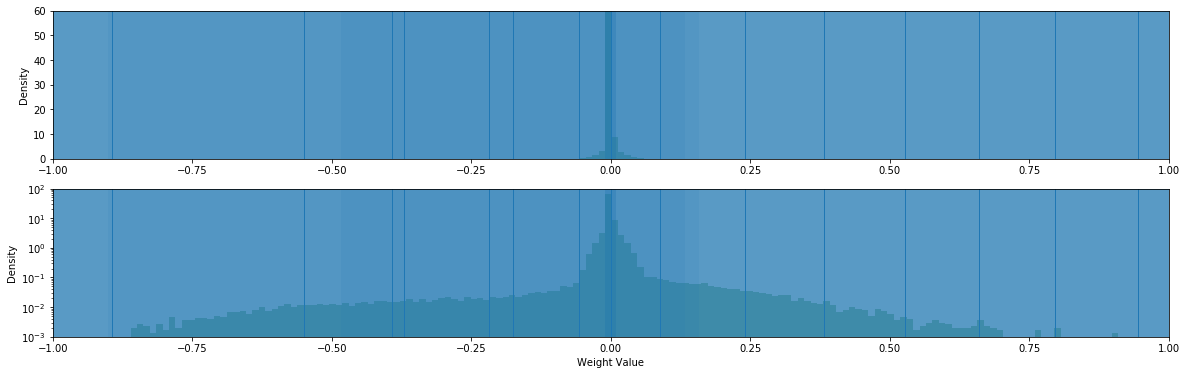

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.64
Epoch: 20. Test Accuracy: 97.09
Epoch: 30. Test Accuracy: 96.00
Epoch: 40. Test Accuracy: 94.24
Epoch: 50. Test Accuracy: 94.31
Retrain Test: 94.31, Retrain Validation: 94.42, Prune Test: 92.51, Prune Validation: 92.86, Prune Sparsity: 99.05


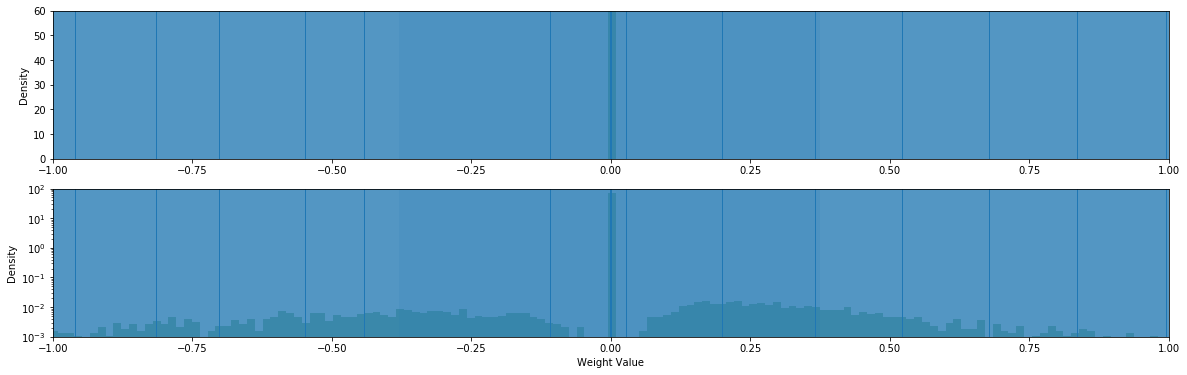

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 28.24
Terminating Search - Epoch: 13 - Val Acc: 33.20
Retrain Test: 31.85, Retrain Validation: 33.20, Prune Test: 35.01, Prune Validation: 36.01, Prune Sparsity: 44.97


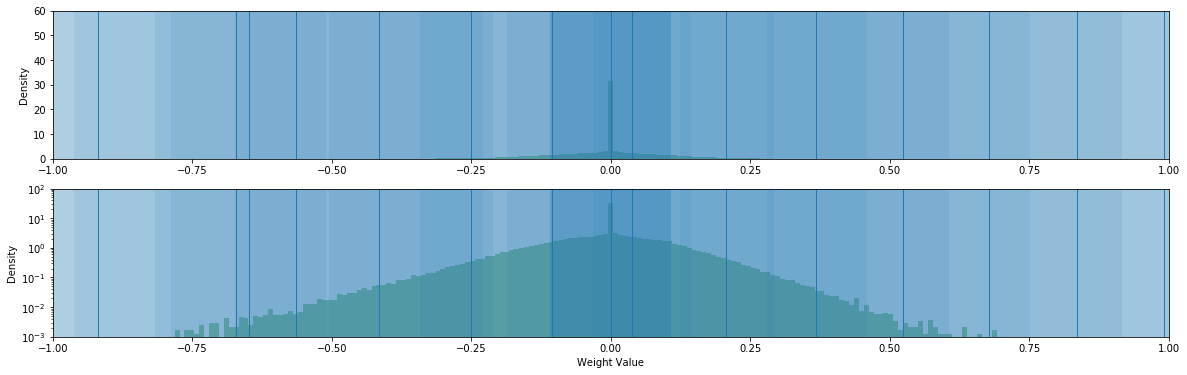

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.15
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 97.98
Epoch: 50. Test Accuracy: 97.62
Retrain Test: 97.62, Retrain Validation: 97.48, Prune Test: 96.90, Prune Validation: 96.88, Prune Sparsity: 95.38


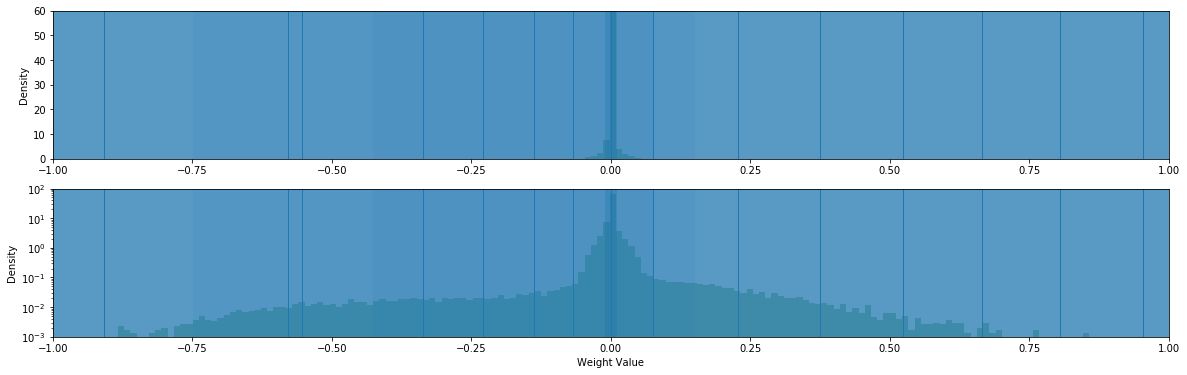

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.73
Epoch: 20. Test Accuracy: 97.10
Epoch: 30. Test Accuracy: 95.45
Epoch: 40. Test Accuracy: 94.18
Epoch: 50. Test Accuracy: 94.21
Retrain Test: 94.21, Retrain Validation: 94.36, Prune Test: 91.95, Prune Validation: 92.26, Prune Sparsity: 99.07


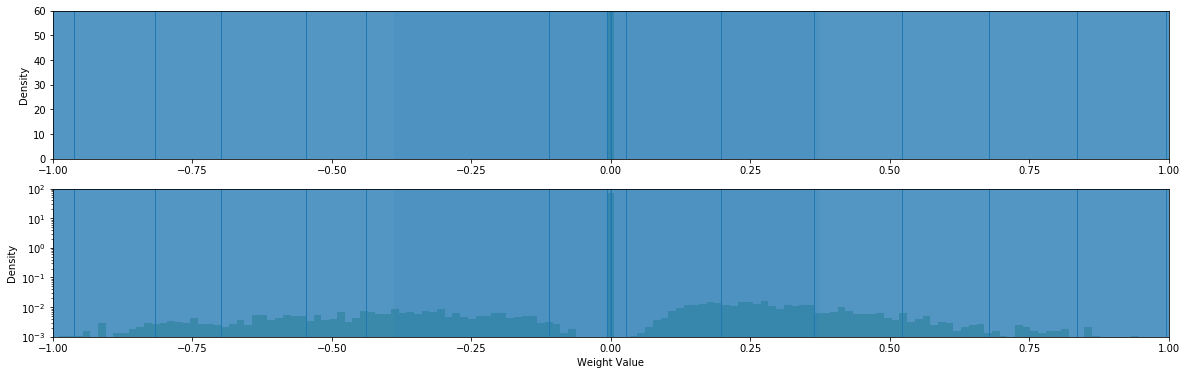

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 22.92
Terminating Search - Epoch: 13 - Val Acc: 28.27
Retrain Test: 26.85, Retrain Validation: 28.27, Prune Test: 27.83, Prune Validation: 28.19, Prune Sparsity: 44.81


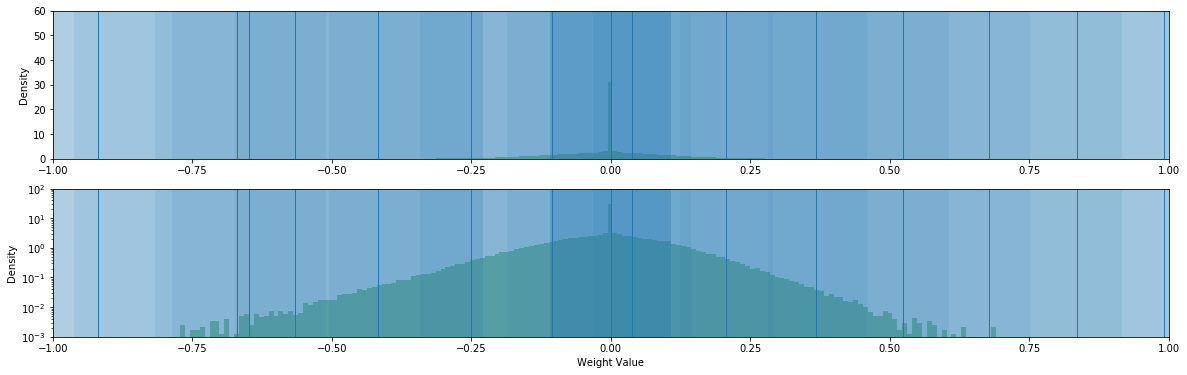

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.18
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.98
Epoch: 50. Test Accuracy: 97.75
Retrain Test: 97.75, Retrain Validation: 97.53, Prune Test: 96.23, Prune Validation: 96.15, Prune Sparsity: 95.06


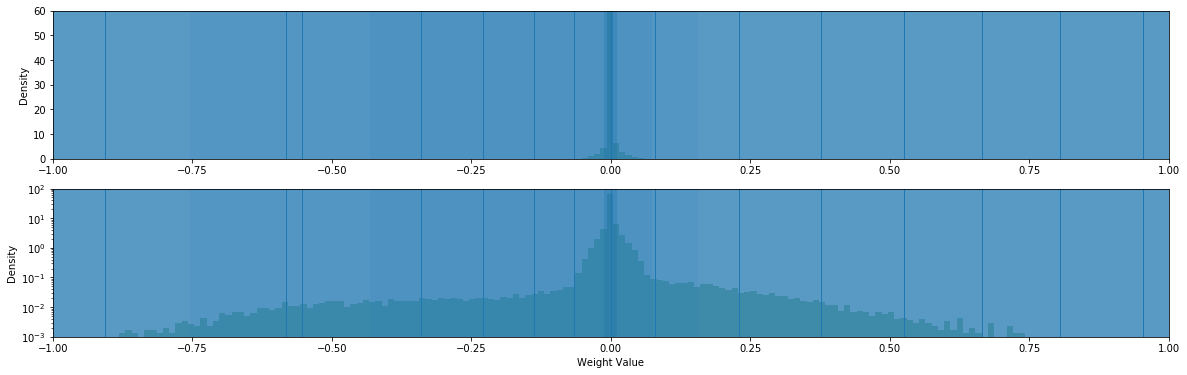

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.73
Epoch: 20. Test Accuracy: 97.15
Epoch: 30. Test Accuracy: 96.28
Epoch: 40. Test Accuracy: 94.75
Epoch: 50. Test Accuracy: 94.69
Retrain Test: 94.69, Retrain Validation: 94.92, Prune Test: 91.17, Prune Validation: 91.48, Prune Sparsity: 99.08


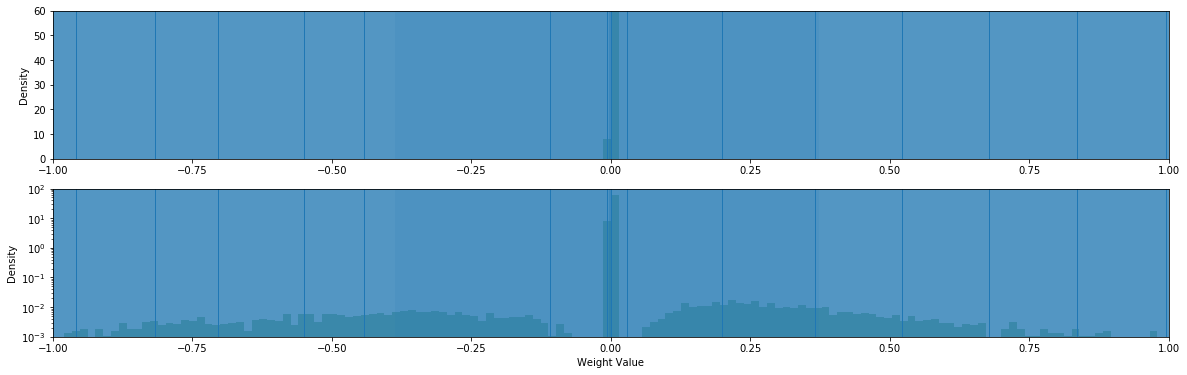

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 19.01
Terminating Search - Epoch: 13 - Val Acc: 25.25
Retrain Test: 23.67, Retrain Validation: 25.25, Prune Test: 26.35, Prune Validation: 25.77, Prune Sparsity: 44.79


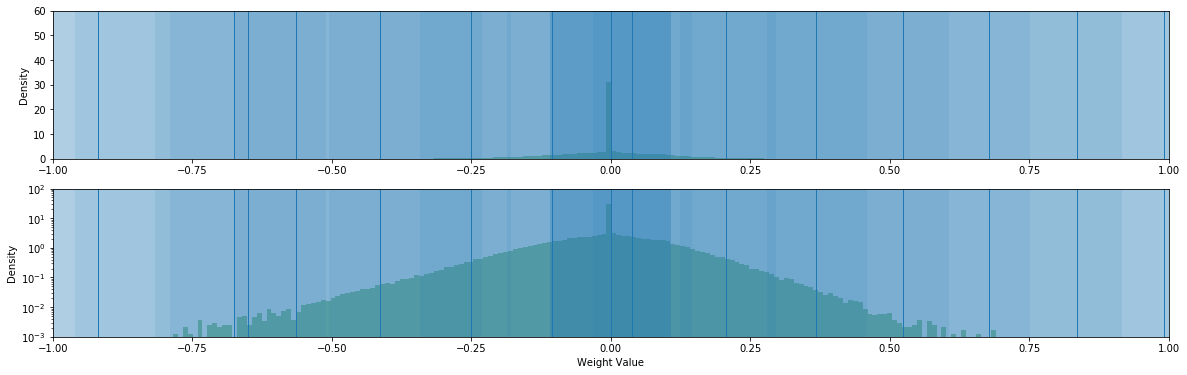

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.12
Epoch: 20. Test Accuracy: 98.07
Epoch: 30. Test Accuracy: 98.07
Epoch: 40. Test Accuracy: 97.96
Epoch: 50. Test Accuracy: 97.85
Retrain Test: 97.85, Retrain Validation: 97.67, Prune Test: 96.49, Prune Validation: 96.58, Prune Sparsity: 91.62


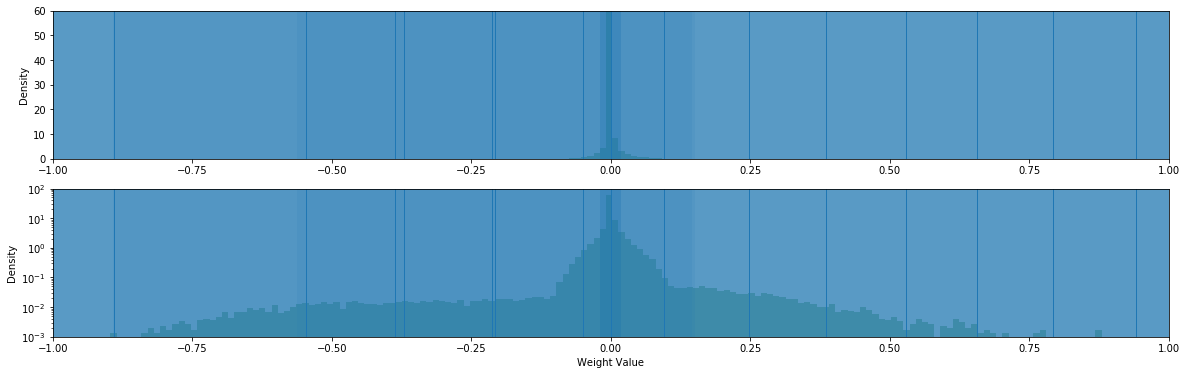

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.78
Epoch: 20. Test Accuracy: 97.31
Epoch: 30. Test Accuracy: 96.25
Epoch: 40. Test Accuracy: 96.16
Epoch: 50. Test Accuracy: 96.08
Retrain Test: 96.08, Retrain Validation: 96.15, Prune Test: 91.61, Prune Validation: 92.21, Prune Sparsity: 98.38


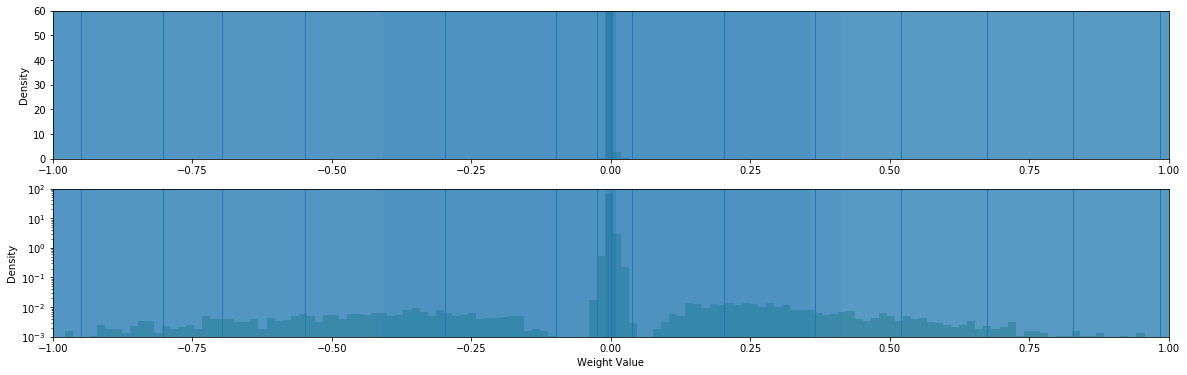

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 21.47
Terminating Search - Epoch: 13 - Val Acc: 28.30
Retrain Test: 26.67, Retrain Validation: 28.30, Prune Test: 32.04, Prune Validation: 32.47, Prune Sparsity: 44.98


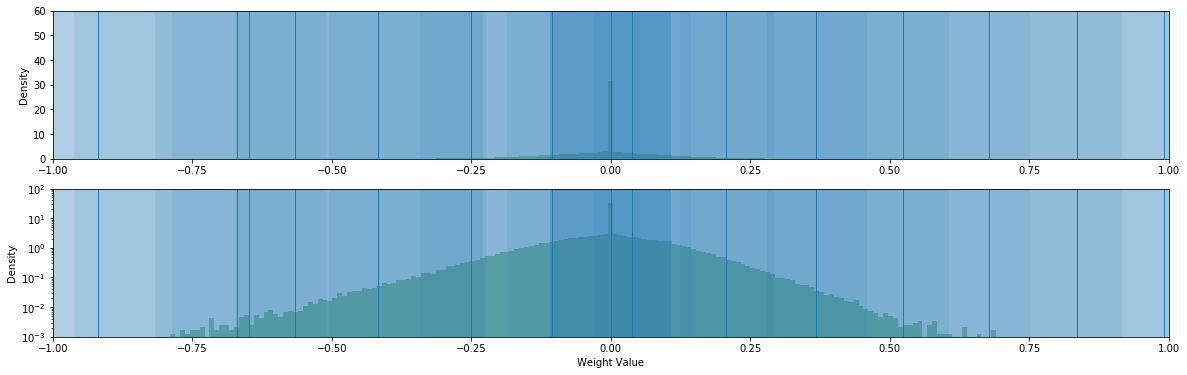

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.23
Epoch: 20. Test Accuracy: 98.03
Epoch: 30. Test Accuracy: 97.97
Epoch: 40. Test Accuracy: 97.77
Epoch: 50. Test Accuracy: 97.90
Retrain Test: 97.90, Retrain Validation: 97.67, Prune Test: 95.72, Prune Validation: 95.81, Prune Sparsity: 91.97


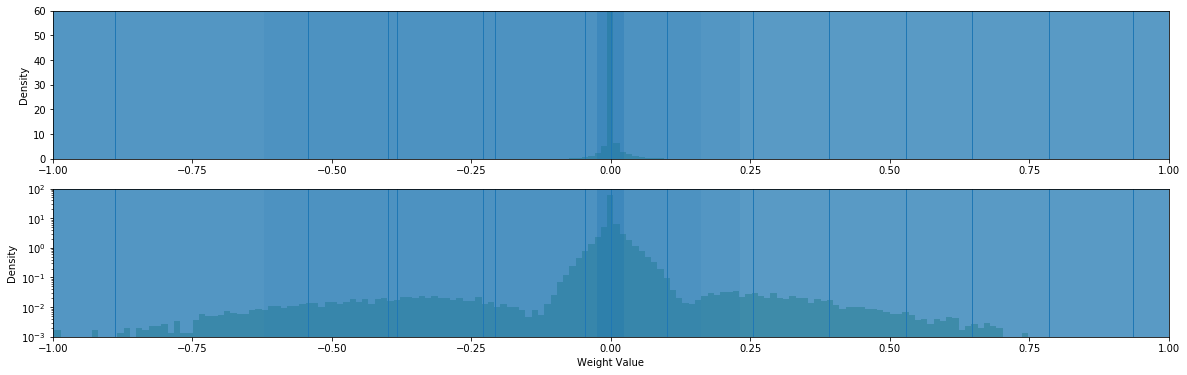

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.71
Epoch: 20. Test Accuracy: 97.01
Epoch: 30. Test Accuracy: 97.07
Epoch: 40. Test Accuracy: 96.70
Epoch: 50. Test Accuracy: 96.62
Retrain Test: 96.62, Retrain Validation: 96.82, Prune Test: 93.71, Prune Validation: 93.80, Prune Sparsity: 94.86


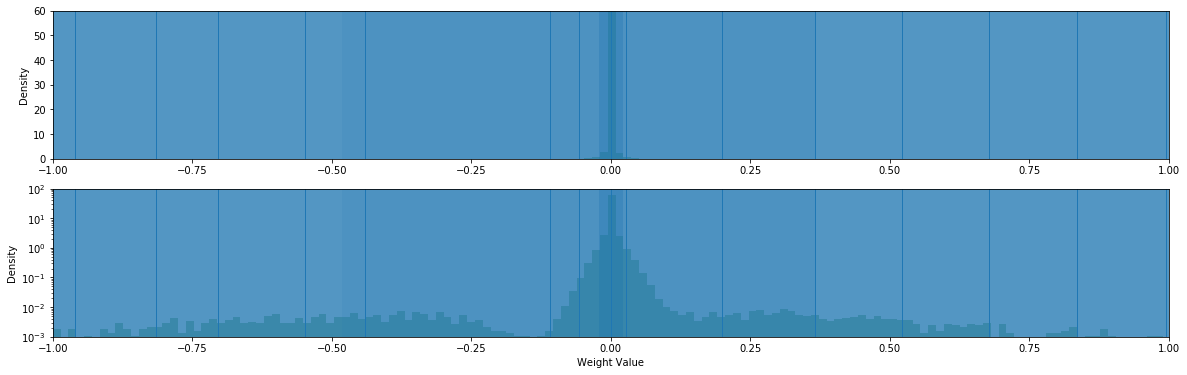

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 31.86
Terminating Search - Epoch: 13 - Val Acc: 38.79
Retrain Test: 36.79, Retrain Validation: 38.79, Prune Test: 31.66, Prune Validation: 32.11, Prune Sparsity: 46.02


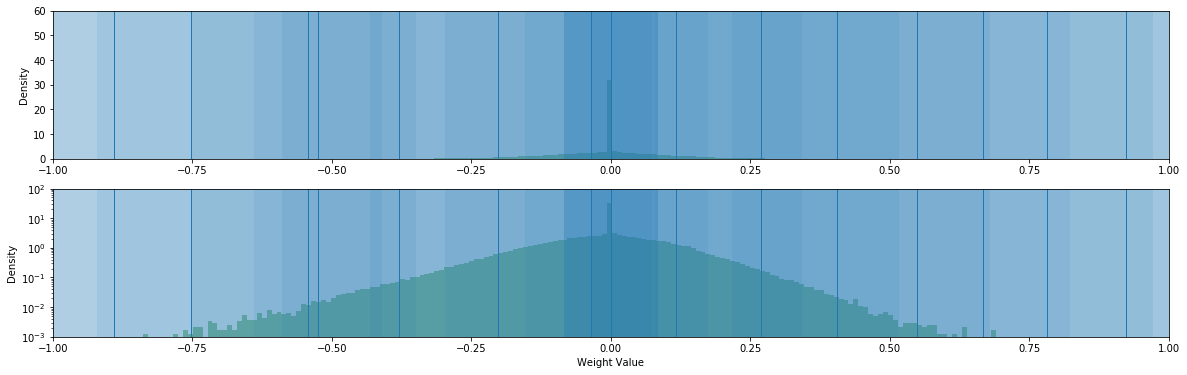

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.18
Epoch: 20. Test Accuracy: 98.13
Epoch: 30. Test Accuracy: 97.83
Epoch: 40. Test Accuracy: 97.91
Epoch: 50. Test Accuracy: 97.88
Retrain Test: 97.88, Retrain Validation: 97.62, Prune Test: 97.34, Prune Validation: 96.64, Prune Sparsity: 95.77


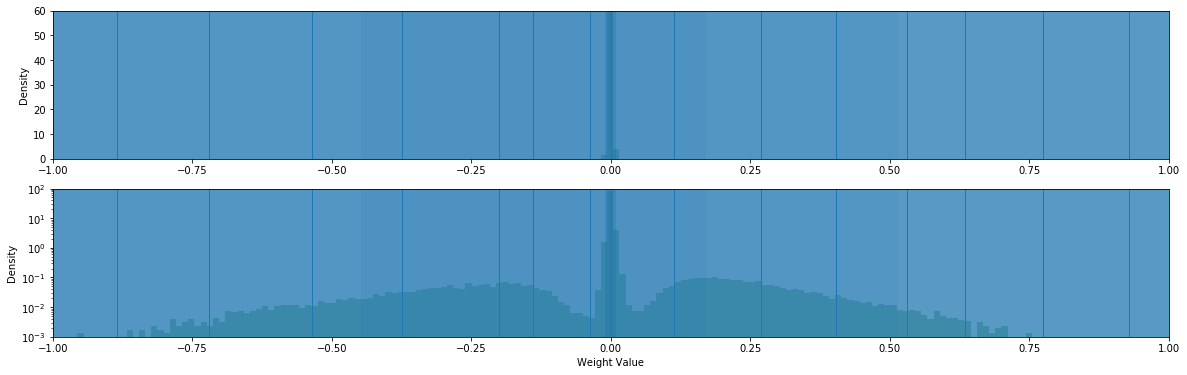

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.86
Epoch: 20. Test Accuracy: 97.19
Epoch: 30. Test Accuracy: 96.39
Epoch: 40. Test Accuracy: 96.28
Epoch: 50. Test Accuracy: 96.06
Retrain Test: 96.06, Retrain Validation: 96.19, Prune Test: 84.89, Prune Validation: 84.76, Prune Sparsity: 98.15


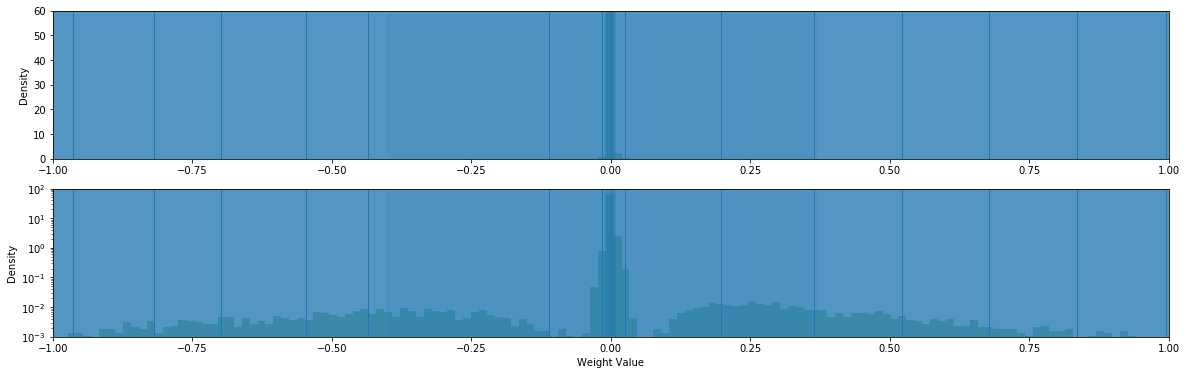

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1.0 Variance: 2.0
Epoch: 10. Test Accuracy: 28.55
Terminating Search - Epoch: 13 - Val Acc: 32.49
Retrain Test: 31.07, Retrain Validation: 32.49, Prune Test: 35.64, Prune Validation: 37.36, Prune Sparsity: 68.60


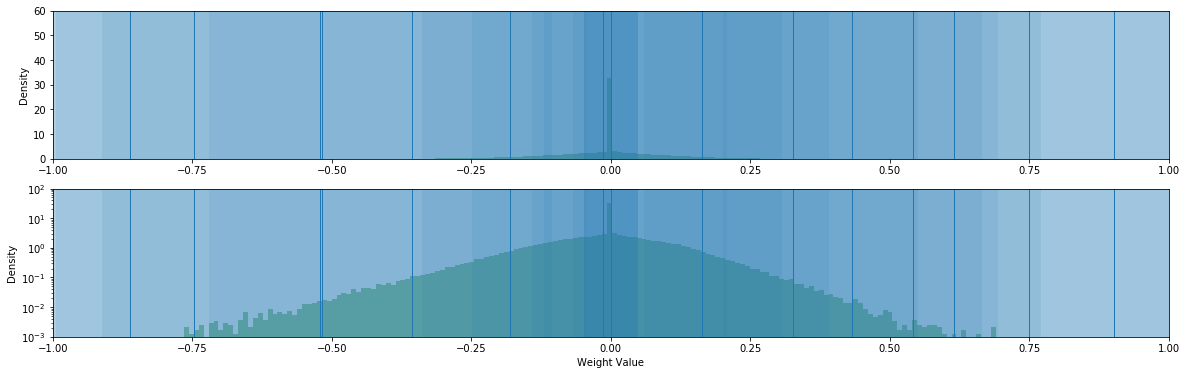

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.33
Epoch: 20. Test Accuracy: 98.25
Epoch: 30. Test Accuracy: 97.89
Epoch: 40. Test Accuracy: 97.89
Epoch: 50. Test Accuracy: 97.73
Retrain Test: 97.73, Retrain Validation: 97.60, Prune Test: 94.48, Prune Validation: 94.26, Prune Sparsity: 94.81


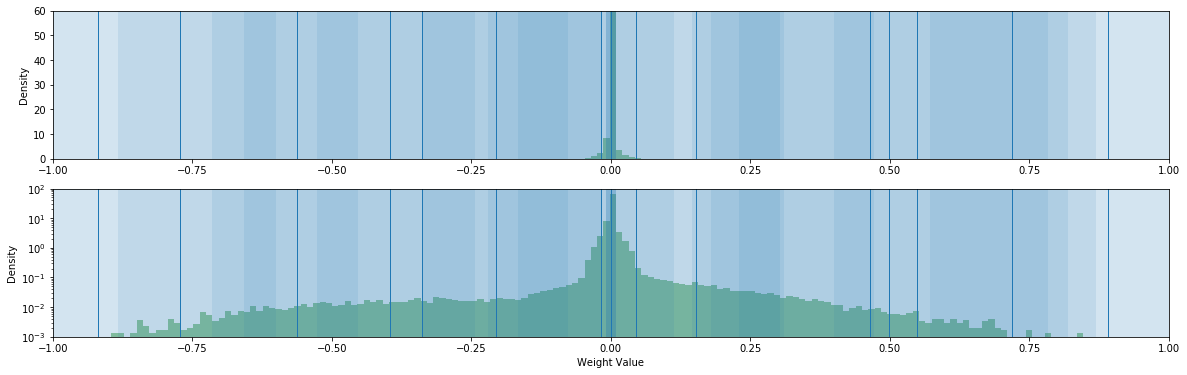

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.81
Epoch: 20. Test Accuracy: 97.12
Epoch: 30. Test Accuracy: 95.71
Epoch: 40. Test Accuracy: 94.29
Epoch: 50. Test Accuracy: 94.34
Retrain Test: 94.34, Retrain Validation: 94.55, Prune Test: 92.05, Prune Validation: 92.53, Prune Sparsity: 99.05


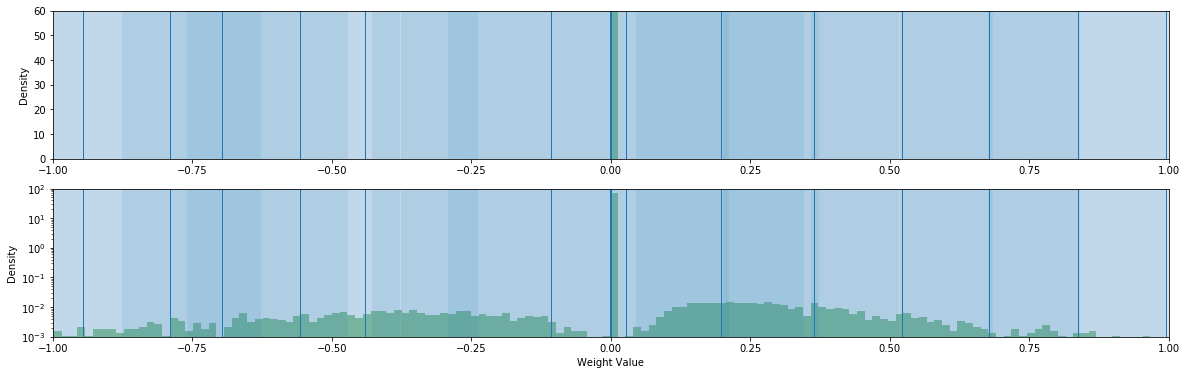

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 17.62
Terminating Search - Epoch: 13 - Val Acc: 24.67
Retrain Test: 23.40, Retrain Validation: 24.67, Prune Test: 19.78, Prune Validation: 20.59, Prune Sparsity: 45.29


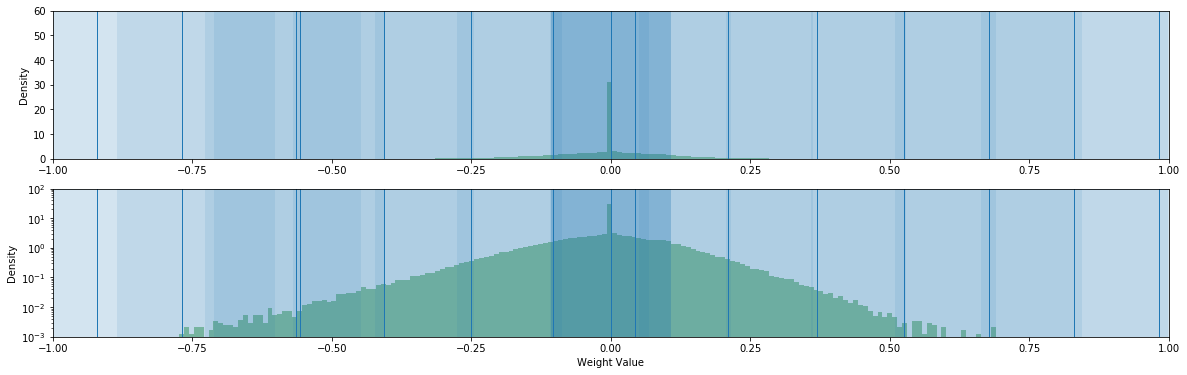

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.16
Epoch: 20. Test Accuracy: 98.18
Epoch: 30. Test Accuracy: 98.08
Epoch: 40. Test Accuracy: 98.03
Epoch: 50. Test Accuracy: 97.59
Retrain Test: 97.59, Retrain Validation: 97.59, Prune Test: 91.29, Prune Validation: 91.65, Prune Sparsity: 94.26


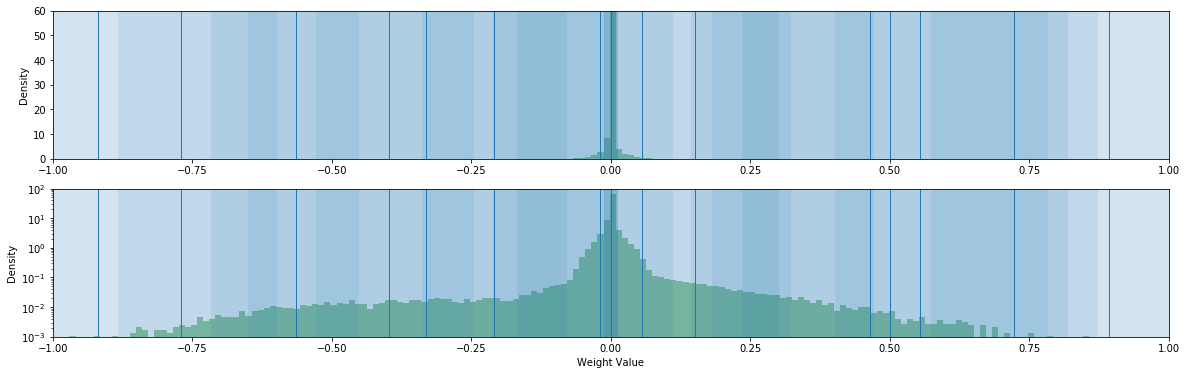

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.87
Epoch: 20. Test Accuracy: 97.20
Epoch: 30. Test Accuracy: 96.01
Epoch: 40. Test Accuracy: 94.63
Epoch: 50. Test Accuracy: 94.55
Retrain Test: 94.55, Retrain Validation: 94.51, Prune Test: 92.33, Prune Validation: 92.64, Prune Sparsity: 99.04


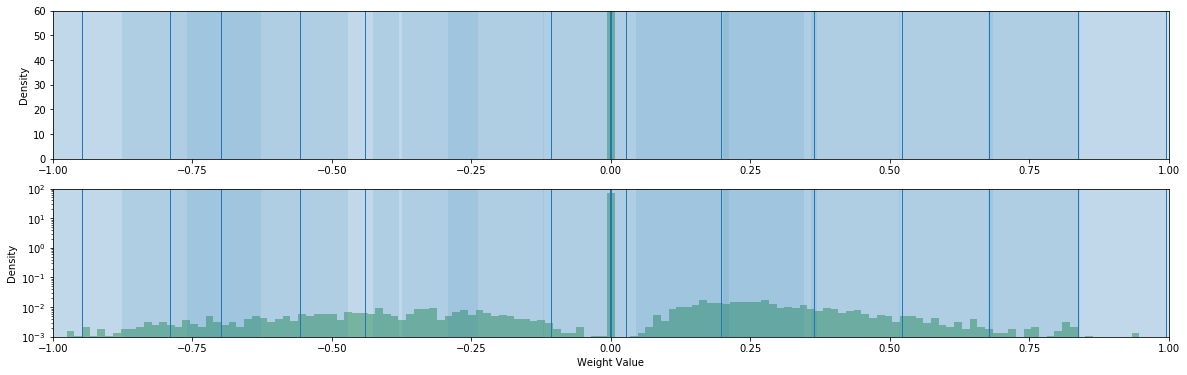

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 20.86
Terminating Search - Epoch: 13 - Val Acc: 28.02
Retrain Test: 25.81, Retrain Validation: 28.02, Prune Test: 21.41, Prune Validation: 22.22, Prune Sparsity: 45.43


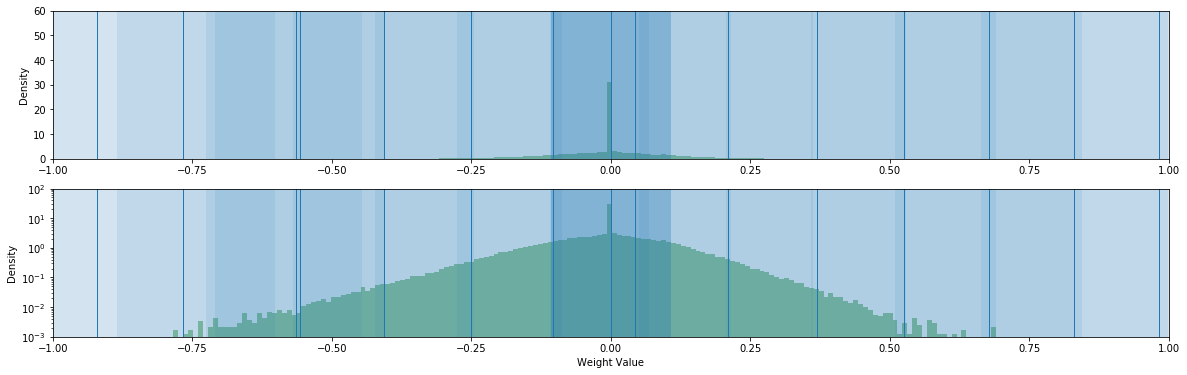

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.15
Epoch: 20. Test Accuracy: 98.26
Epoch: 30. Test Accuracy: 98.00
Epoch: 40. Test Accuracy: 97.86
Epoch: 50. Test Accuracy: 97.74
Retrain Test: 97.74, Retrain Validation: 97.63, Prune Test: 94.31, Prune Validation: 94.06, Prune Sparsity: 94.39


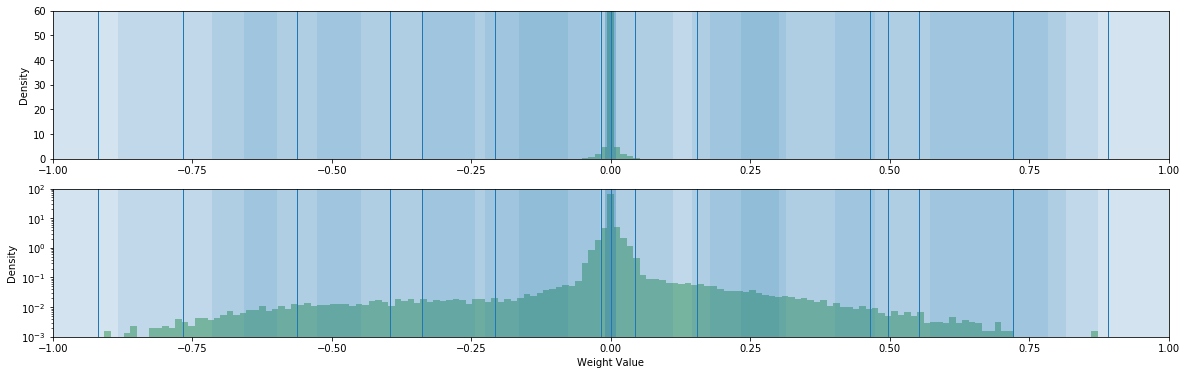

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.69
Epoch: 20. Test Accuracy: 97.07
Epoch: 30. Test Accuracy: 96.00
Epoch: 40. Test Accuracy: 94.94
Epoch: 50. Test Accuracy: 94.76
Retrain Test: 94.76, Retrain Validation: 94.71, Prune Test: 89.24, Prune Validation: 89.69, Prune Sparsity: 99.07


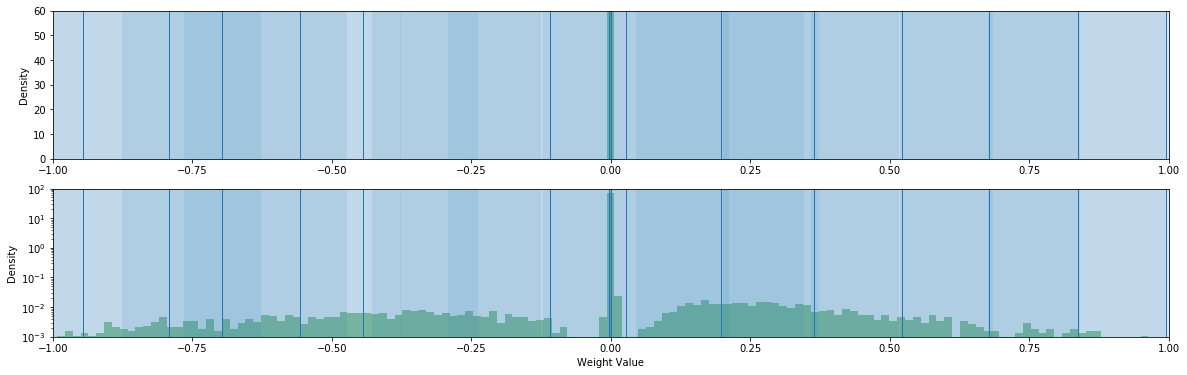

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 20.06
Terminating Search - Epoch: 13 - Val Acc: 26.94
Retrain Test: 25.30, Retrain Validation: 26.94, Prune Test: 29.83, Prune Validation: 29.54, Prune Sparsity: 45.48


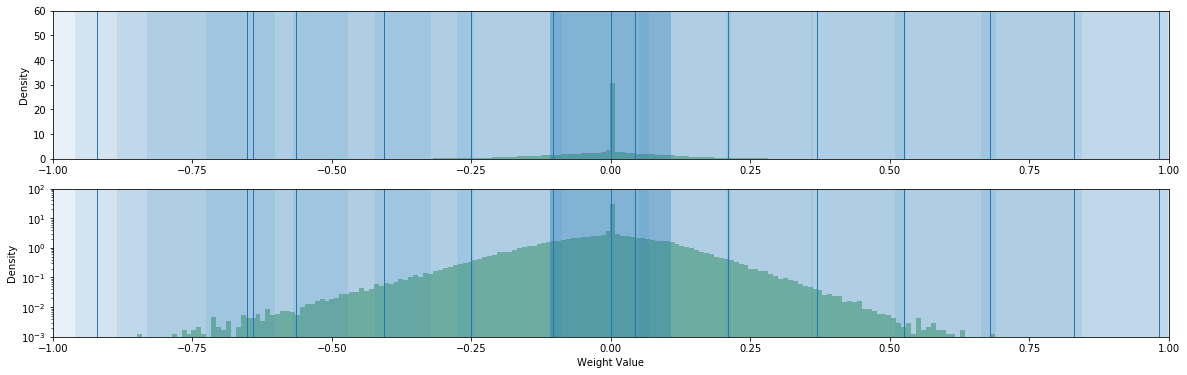

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.21
Epoch: 30. Test Accuracy: 98.06
Epoch: 40. Test Accuracy: 98.01
Epoch: 50. Test Accuracy: 97.94
Retrain Test: 97.94, Retrain Validation: 97.64, Prune Test: 88.51, Prune Validation: 87.97, Prune Sparsity: 98.08


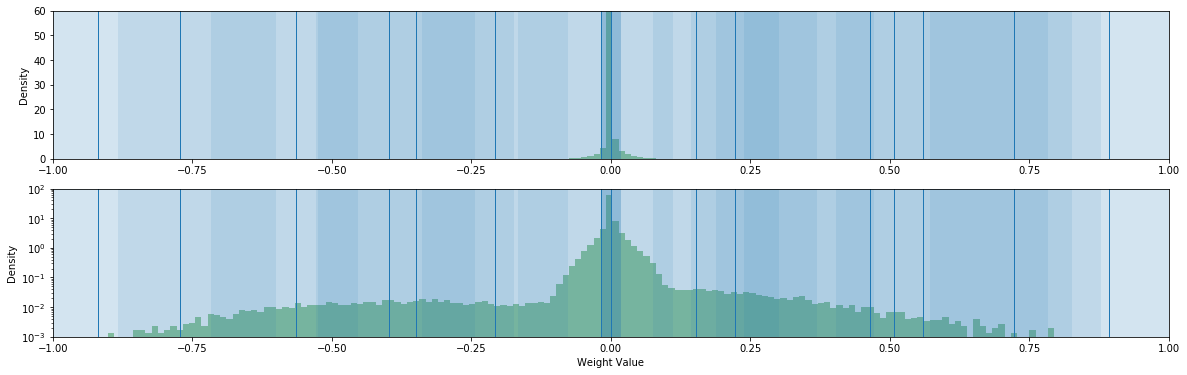

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.81
Epoch: 20. Test Accuracy: 97.19
Epoch: 30. Test Accuracy: 96.40
Epoch: 40. Test Accuracy: 96.02
Epoch: 50. Test Accuracy: 96.22
Retrain Test: 96.22, Retrain Validation: 96.19, Prune Test: 88.38, Prune Validation: 88.36, Prune Sparsity: 98.25


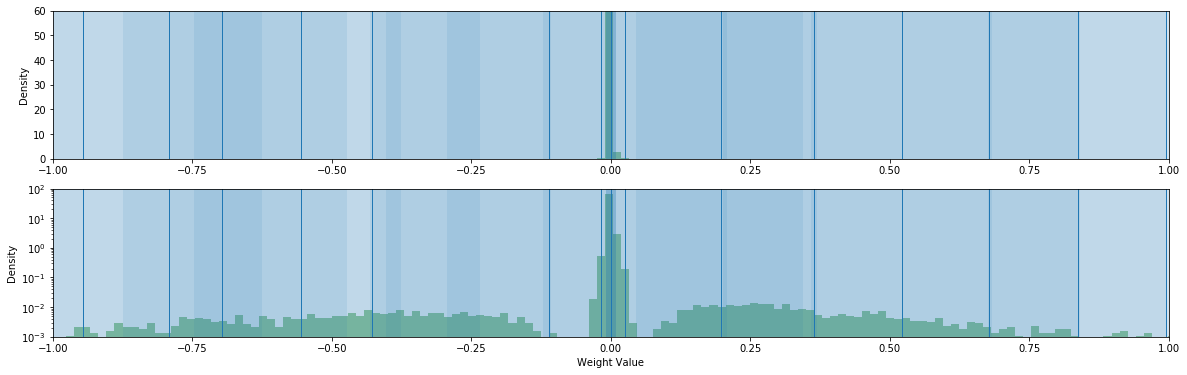

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 28.19
Terminating Search - Epoch: 13 - Val Acc: 33.28
Retrain Test: 31.70, Retrain Validation: 33.28, Prune Test: 32.24, Prune Validation: 32.29, Prune Sparsity: 45.39


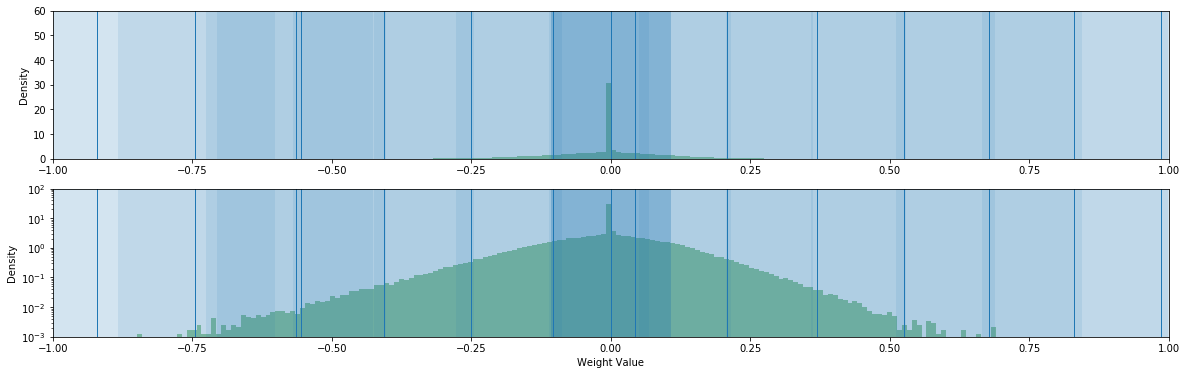

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.21
Epoch: 20. Test Accuracy: 98.18
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 97.83
Epoch: 50. Test Accuracy: 97.96
Retrain Test: 97.96, Retrain Validation: 97.86, Prune Test: 89.78, Prune Validation: 89.87, Prune Sparsity: 97.87


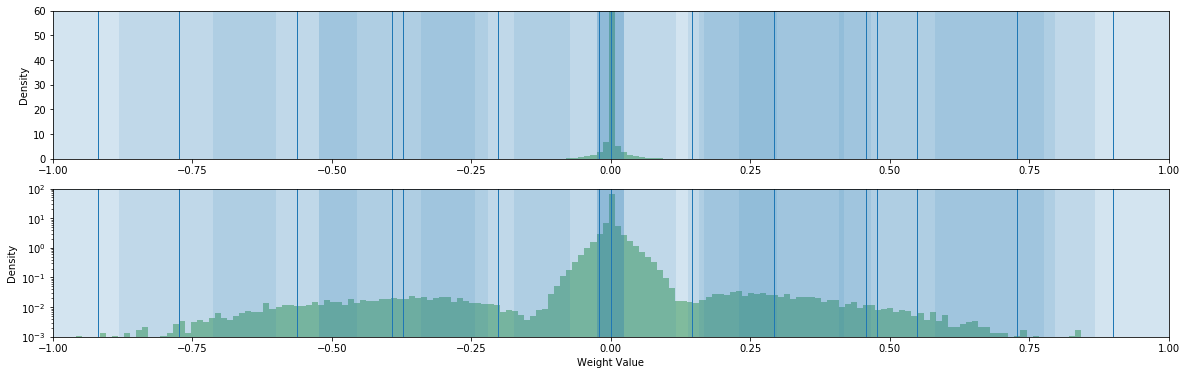

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.79
Epoch: 20. Test Accuracy: 97.18
Epoch: 30. Test Accuracy: 96.95
Epoch: 40. Test Accuracy: 96.87
Epoch: 50. Test Accuracy: 96.77
Retrain Test: 96.77, Retrain Validation: 96.66, Prune Test: 92.25, Prune Validation: 92.52, Prune Sparsity: 94.74


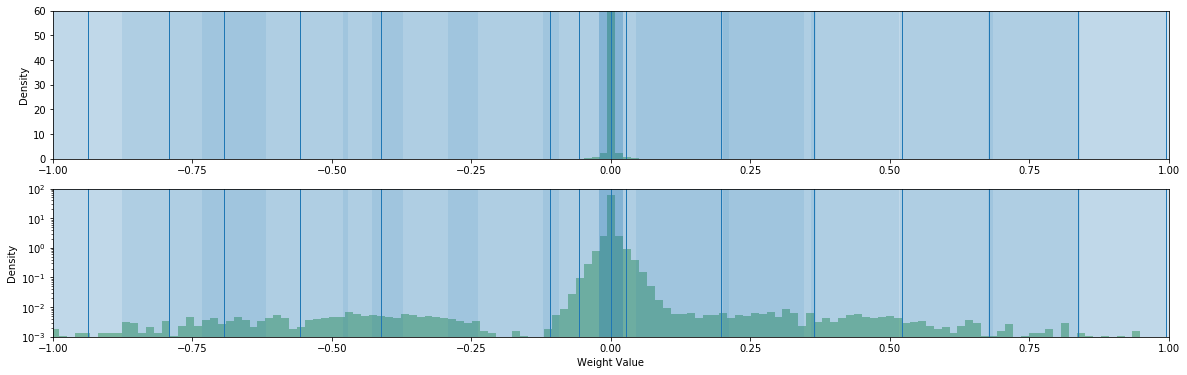

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 20.81
Terminating Search - Epoch: 13 - Val Acc: 28.38
Retrain Test: 26.47, Retrain Validation: 28.38, Prune Test: 59.58, Prune Validation: 62.19, Prune Sparsity: 70.81


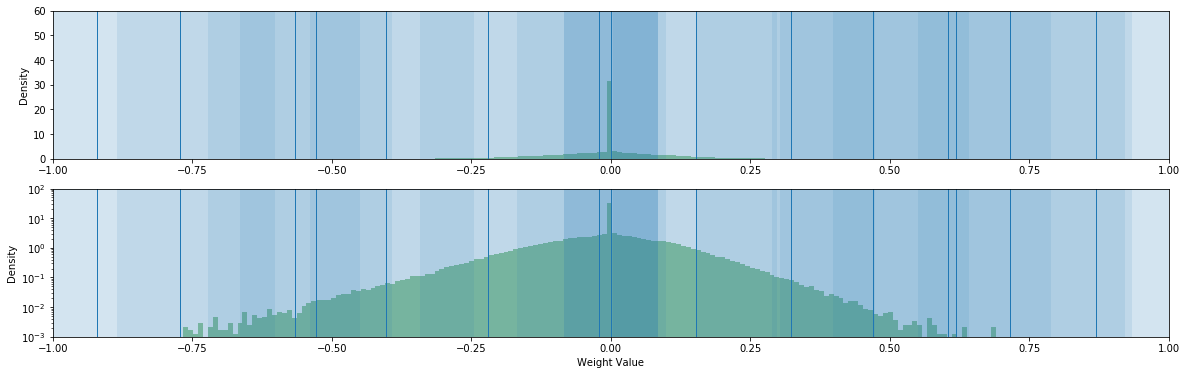

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.22
Epoch: 20. Test Accuracy: 97.95
Epoch: 30. Test Accuracy: 97.88
Epoch: 40. Test Accuracy: 97.89
Epoch: 50. Test Accuracy: 97.79
Retrain Test: 97.79, Retrain Validation: 97.64, Prune Test: 97.30, Prune Validation: 96.84, Prune Sparsity: 95.70


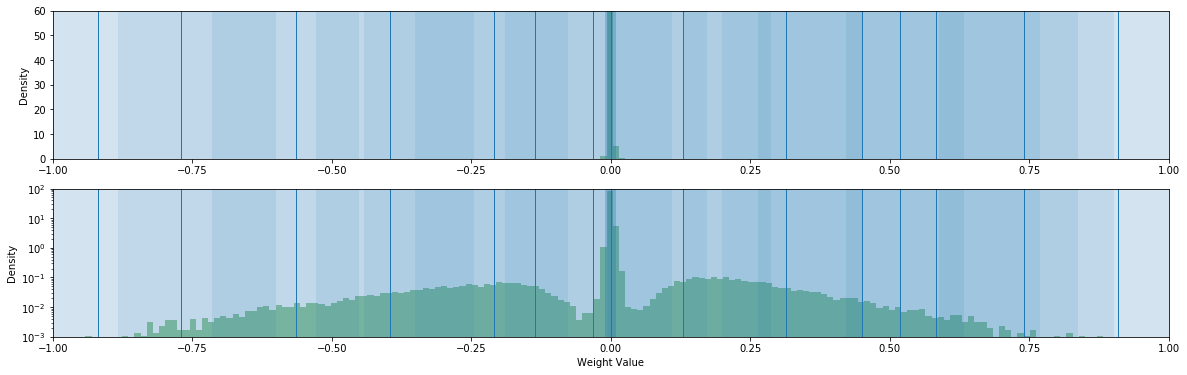

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.87
Epoch: 20. Test Accuracy: 96.98
Epoch: 30. Test Accuracy: 96.49
Epoch: 40. Test Accuracy: 96.19
Epoch: 50. Test Accuracy: 95.89
Retrain Test: 95.89, Retrain Validation: 95.91, Prune Test: 86.53, Prune Validation: 86.20, Prune Sparsity: 98.20


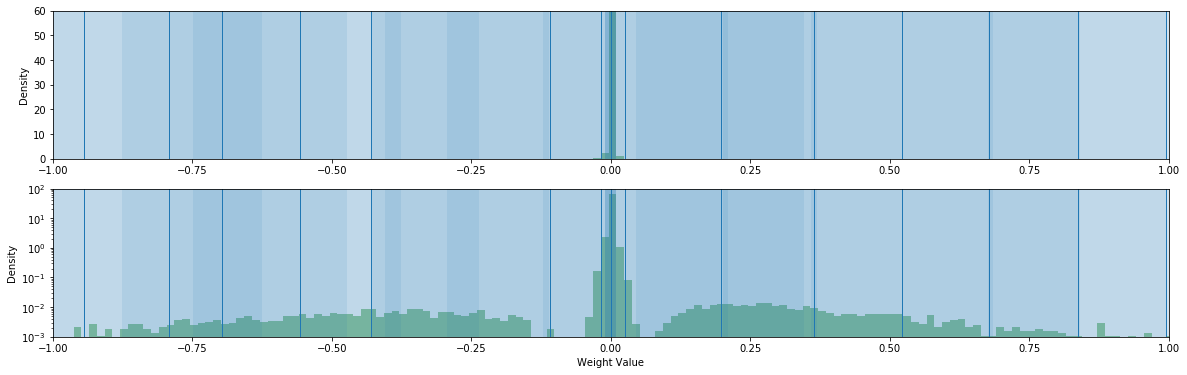

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 10. Test Accuracy: 21.99
Terminating Search - Epoch: 13 - Val Acc: 29.66
Retrain Test: 28.46, Retrain Validation: 29.66, Prune Test: 52.21, Prune Validation: 55.35, Prune Sparsity: 69.32


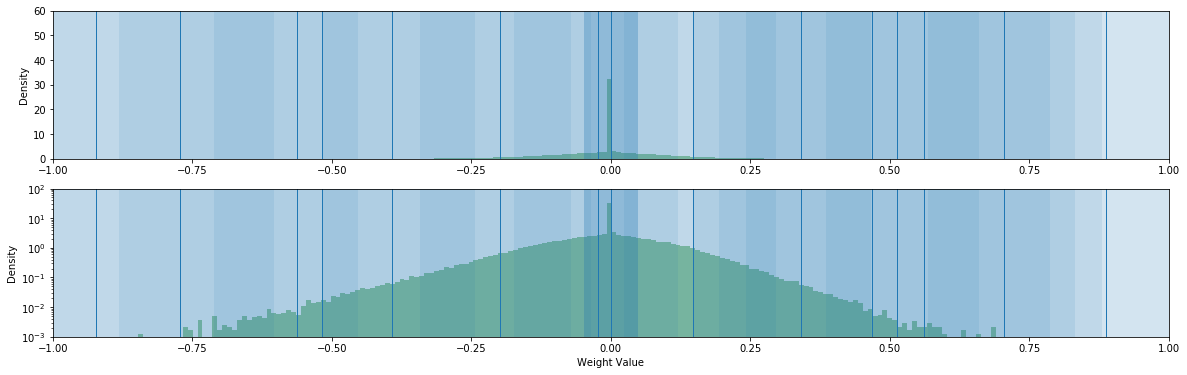

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.28
Epoch: 20. Test Accuracy: 98.19
Epoch: 30. Test Accuracy: 97.99
Epoch: 40. Test Accuracy: 97.90
Epoch: 50. Test Accuracy: 97.72
Retrain Test: 97.72, Retrain Validation: 97.63, Prune Test: 97.63, Prune Validation: 97.34, Prune Sparsity: 87.34


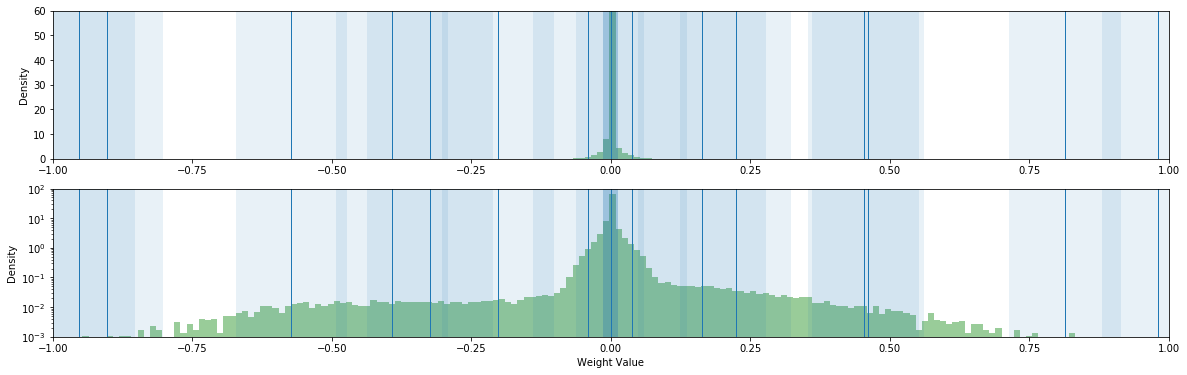

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.83
Epoch: 20. Test Accuracy: 97.29
Epoch: 30. Test Accuracy: 96.08
Epoch: 40. Test Accuracy: 93.91
Epoch: 50. Test Accuracy: 94.22
Retrain Test: 94.22, Retrain Validation: 94.14, Prune Test: 90.68, Prune Validation: 91.02, Prune Sparsity: 99.14


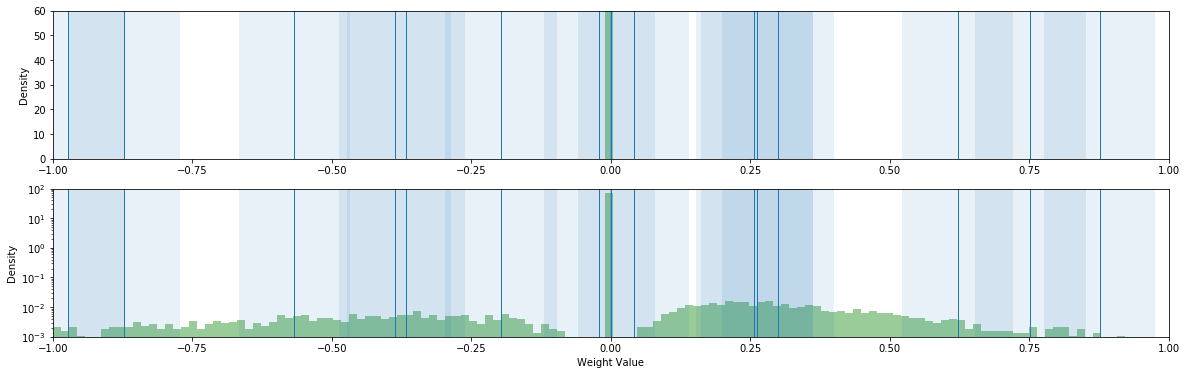

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 42.10
Terminating Search - Epoch: 13 - Val Acc: 48.71
Retrain Test: 47.59, Retrain Validation: 48.71, Prune Test: 37.71, Prune Validation: 39.86, Prune Sparsity: 37.34


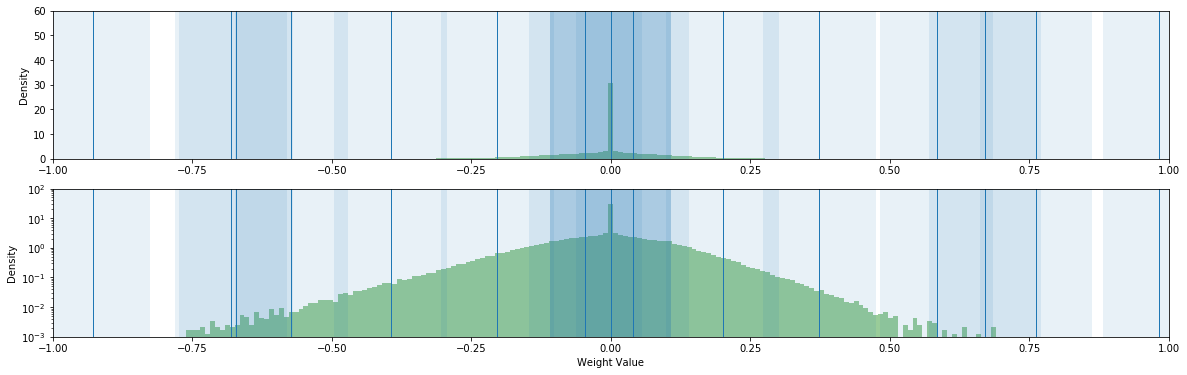

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.28
Epoch: 20. Test Accuracy: 98.11
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.89
Epoch: 50. Test Accuracy: 97.57
Retrain Test: 97.57, Retrain Validation: 97.52, Prune Test: 97.37, Prune Validation: 97.19, Prune Sparsity: 88.58


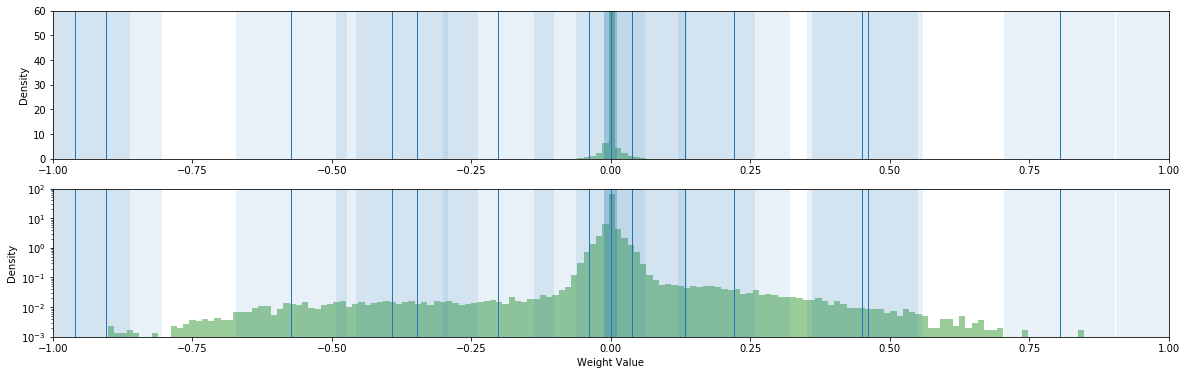

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.84
Epoch: 20. Test Accuracy: 97.10
Epoch: 30. Test Accuracy: 95.74
Epoch: 40. Test Accuracy: 94.29
Epoch: 50. Test Accuracy: 94.34
Retrain Test: 94.34, Retrain Validation: 94.28, Prune Test: 90.04, Prune Validation: 90.65, Prune Sparsity: 99.14


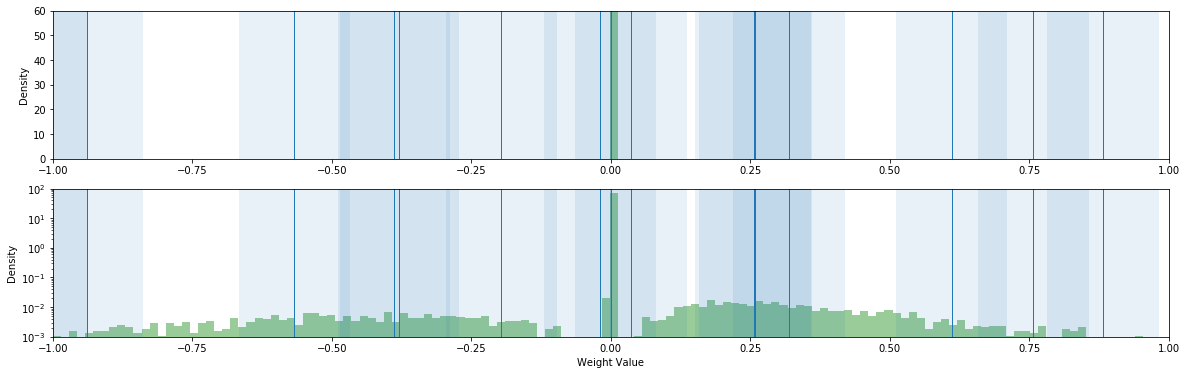

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 29.95
Terminating Search - Epoch: 13 - Val Acc: 36.27
Retrain Test: 34.80, Retrain Validation: 36.27, Prune Test: 31.88, Prune Validation: 33.61, Prune Sparsity: 37.50


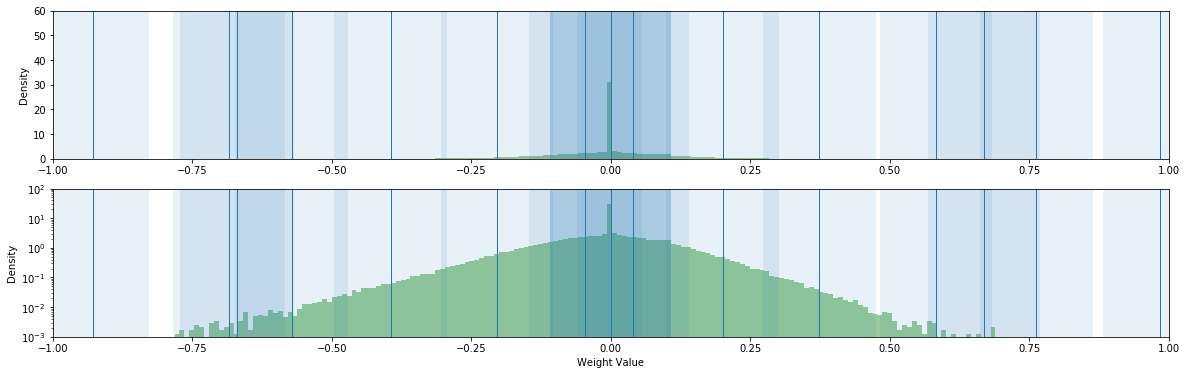

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.24
Epoch: 20. Test Accuracy: 98.17
Epoch: 30. Test Accuracy: 97.99
Epoch: 40. Test Accuracy: 97.83
Epoch: 50. Test Accuracy: 97.84
Retrain Test: 97.84, Retrain Validation: 97.64, Prune Test: 97.52, Prune Validation: 97.49, Prune Sparsity: 87.27


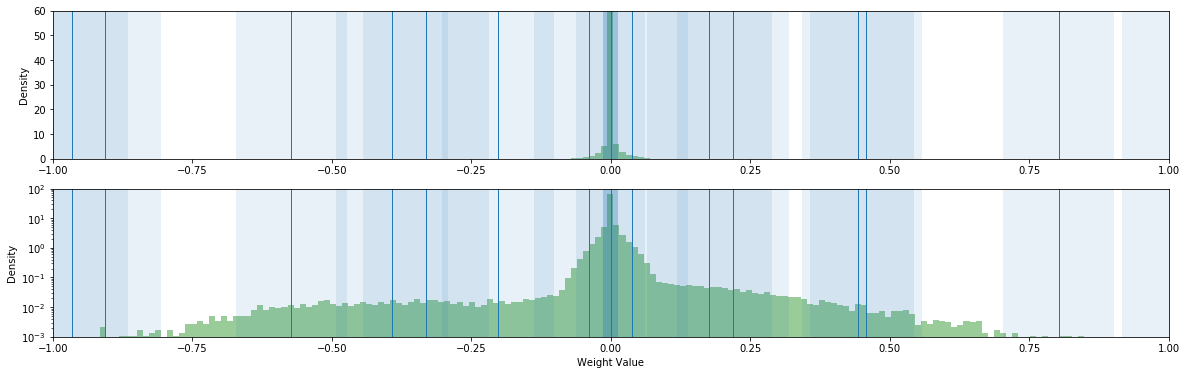

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.86
Epoch: 20. Test Accuracy: 97.01
Epoch: 30. Test Accuracy: 95.81
Epoch: 40. Test Accuracy: 94.59
Epoch: 50. Test Accuracy: 94.71
Retrain Test: 94.71, Retrain Validation: 94.67, Prune Test: 91.27, Prune Validation: 91.14, Prune Sparsity: 99.13


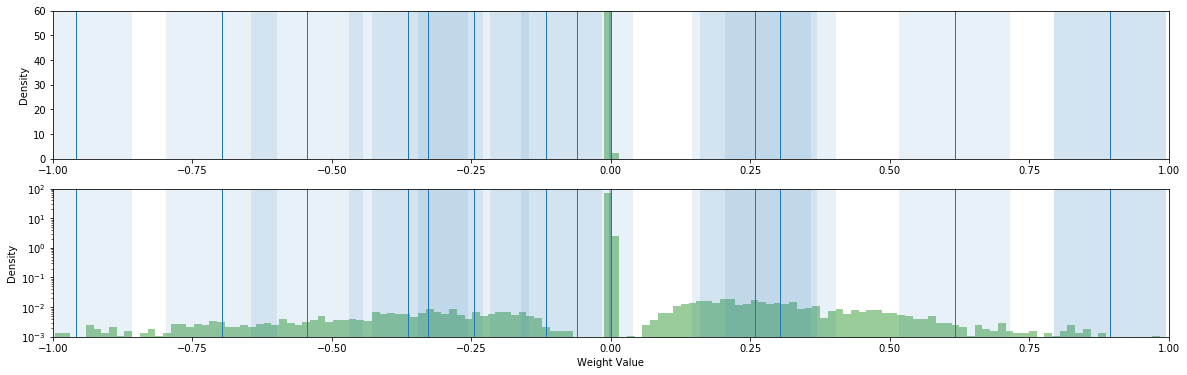

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 44.92
Epoch: 20. Test Accuracy: 67.10
Epoch: 30. Test Accuracy: 74.25
Epoch: 40. Test Accuracy: 79.80
Epoch: 50. Test Accuracy: 85.79
Retrain Test: 85.79, Retrain Validation: 86.66, Prune Test: 47.76, Prune Validation: 48.91, Prune Sparsity: 38.74


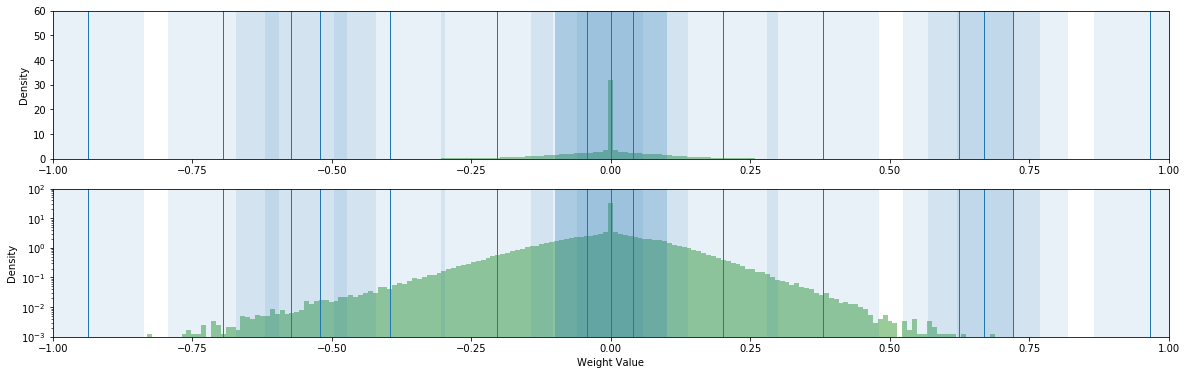

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.12
Epoch: 20. Test Accuracy: 98.01
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 97.90
Epoch: 50. Test Accuracy: 97.78
Retrain Test: 97.78, Retrain Validation: 97.68, Prune Test: 96.74, Prune Validation: 96.87, Prune Sparsity: 85.66


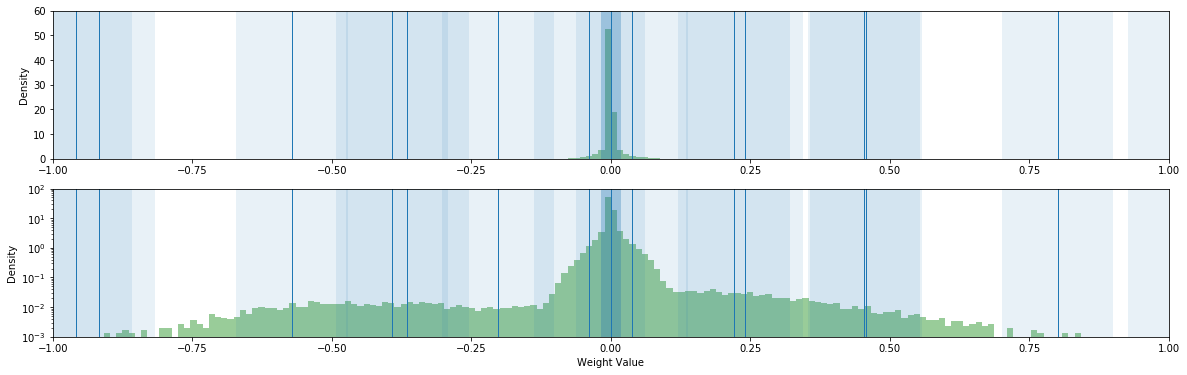

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.77
Epoch: 20. Test Accuracy: 97.20
Epoch: 30. Test Accuracy: 96.42
Epoch: 40. Test Accuracy: 96.06
Epoch: 50. Test Accuracy: 95.97
Retrain Test: 95.97, Retrain Validation: 95.78, Prune Test: 83.87, Prune Validation: 84.77, Prune Sparsity: 99.10


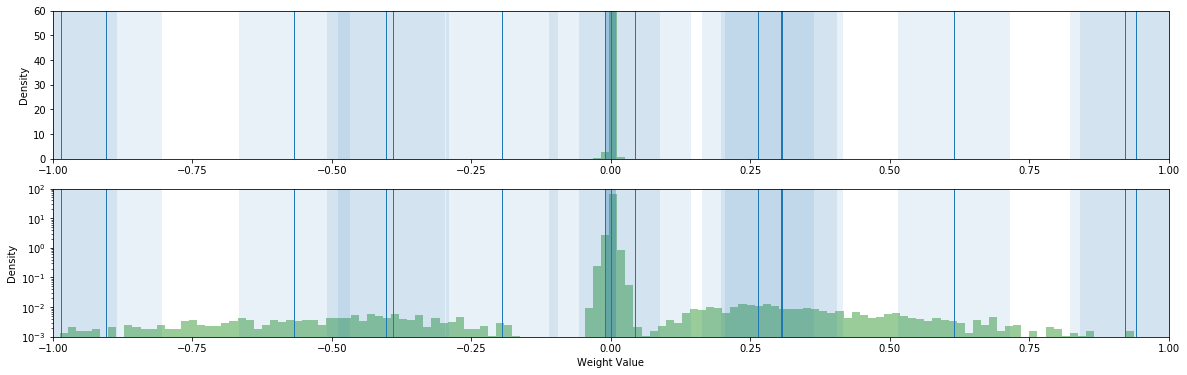

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 28.06
Terminating Search - Epoch: 13 - Val Acc: 35.61
Retrain Test: 35.16, Retrain Validation: 35.61, Prune Test: 33.64, Prune Validation: 34.22, Prune Sparsity: 37.83


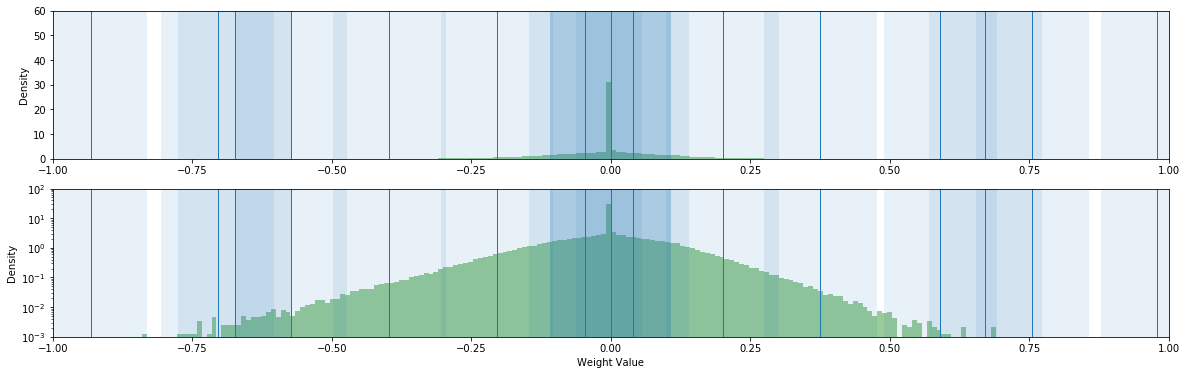

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.15
Epoch: 20. Test Accuracy: 98.03
Epoch: 30. Test Accuracy: 98.00
Epoch: 40. Test Accuracy: 97.96
Epoch: 50. Test Accuracy: 97.94
Retrain Test: 97.94, Retrain Validation: 97.72, Prune Test: 96.80, Prune Validation: 96.62, Prune Sparsity: 85.40


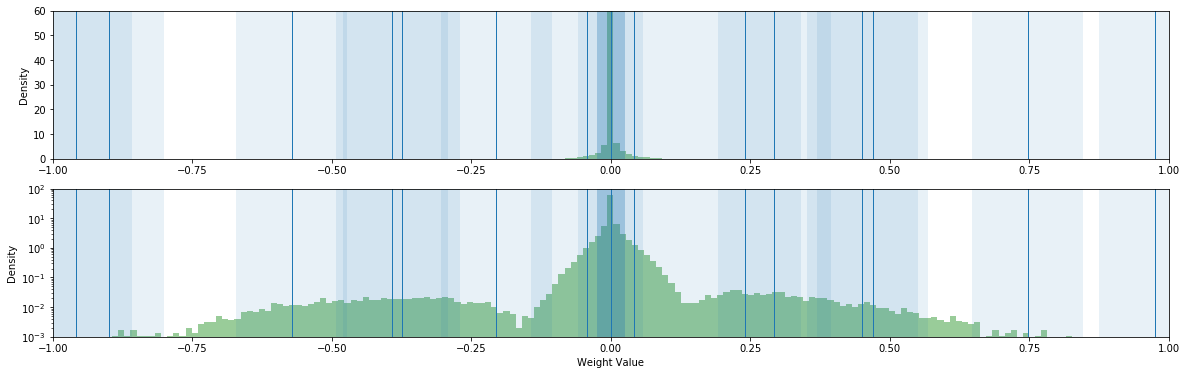

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.98
Epoch: 20. Test Accuracy: 97.21
Epoch: 30. Test Accuracy: 96.62
Epoch: 40. Test Accuracy: 96.71
Epoch: 50. Test Accuracy: 96.57
Retrain Test: 96.57, Retrain Validation: 96.50, Prune Test: 40.12, Prune Validation: 41.32, Prune Sparsity: 97.70


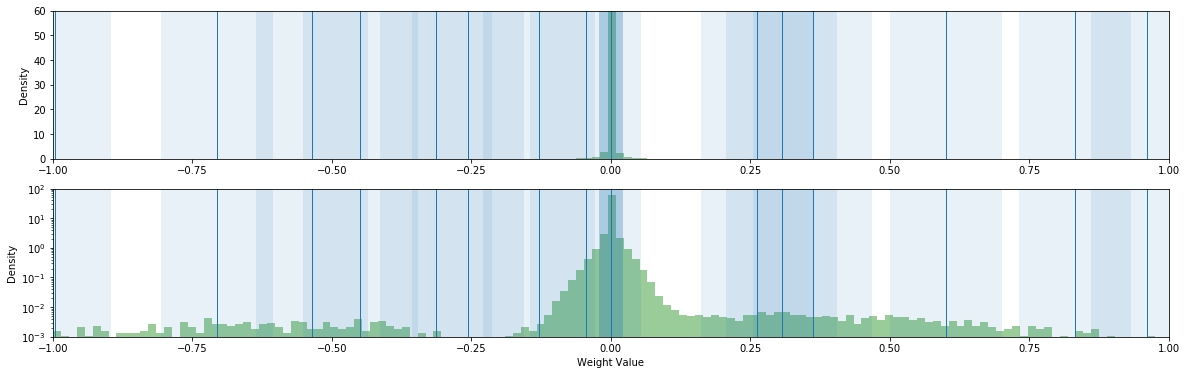

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 56.85
Epoch: 20. Test Accuracy: 71.45
Epoch: 30. Test Accuracy: 80.10
Epoch: 40. Test Accuracy: 82.78
Epoch: 50. Test Accuracy: 86.53
Retrain Test: 86.53, Retrain Validation: 87.92, Prune Test: 38.83, Prune Validation: 38.00, Prune Sparsity: 41.25


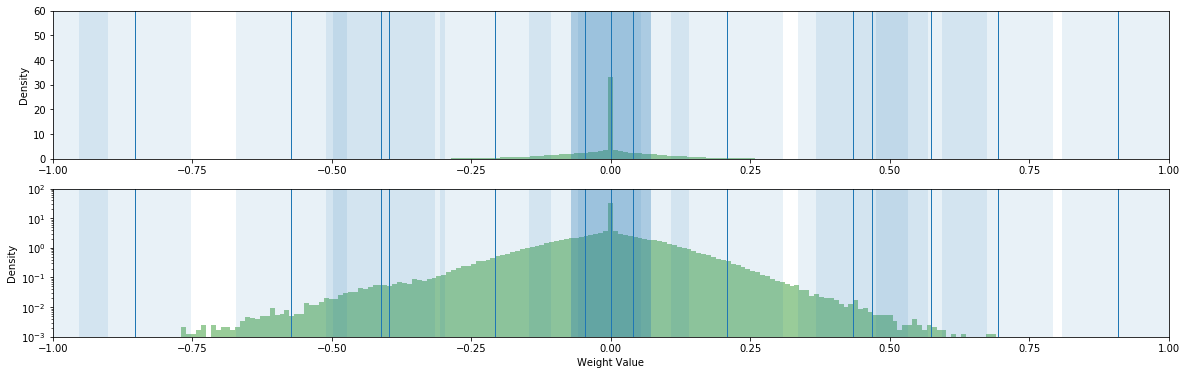

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.18
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 97.84
Epoch: 40. Test Accuracy: 97.72
Epoch: 50. Test Accuracy: 97.80
Retrain Test: 97.80, Retrain Validation: 97.71, Prune Test: 96.85, Prune Validation: 96.99, Prune Sparsity: 96.13


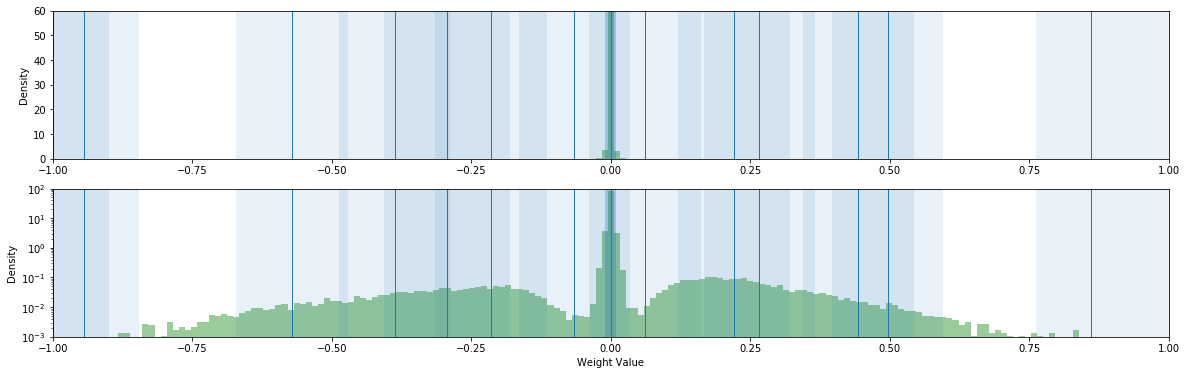

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.55
Epoch: 20. Test Accuracy: 97.20
Epoch: 30. Test Accuracy: 96.26
Epoch: 40. Test Accuracy: 96.26
Epoch: 50. Test Accuracy: 96.28
Retrain Test: 96.28, Retrain Validation: 96.28, Prune Test: 74.42, Prune Validation: 73.40, Prune Sparsity: 99.24


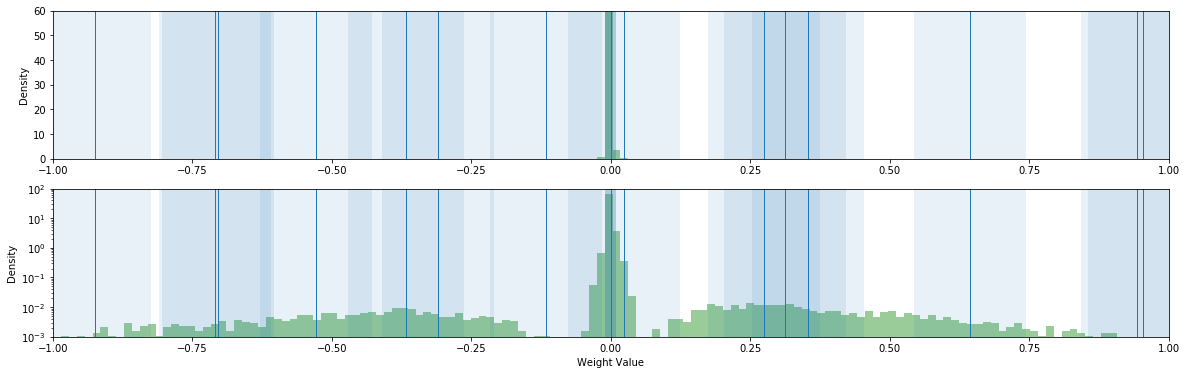

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 28.89
Terminating Search - Epoch: 13 - Val Acc: 49.27
Retrain Test: 48.52, Retrain Validation: 49.27, Prune Test: 18.80, Prune Validation: 19.62, Prune Sparsity: 43.27


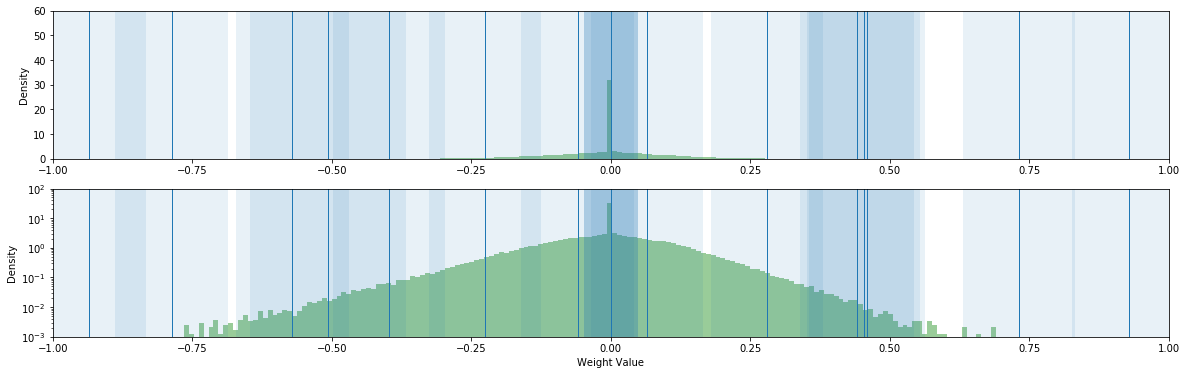

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.23
Epoch: 20. Test Accuracy: 97.79
Epoch: 30. Test Accuracy: 97.99
Epoch: 40. Test Accuracy: 97.94
Epoch: 50. Test Accuracy: 97.97
Retrain Test: 97.97, Retrain Validation: 97.70, Prune Test: 97.40, Prune Validation: 97.06, Prune Sparsity: 80.76


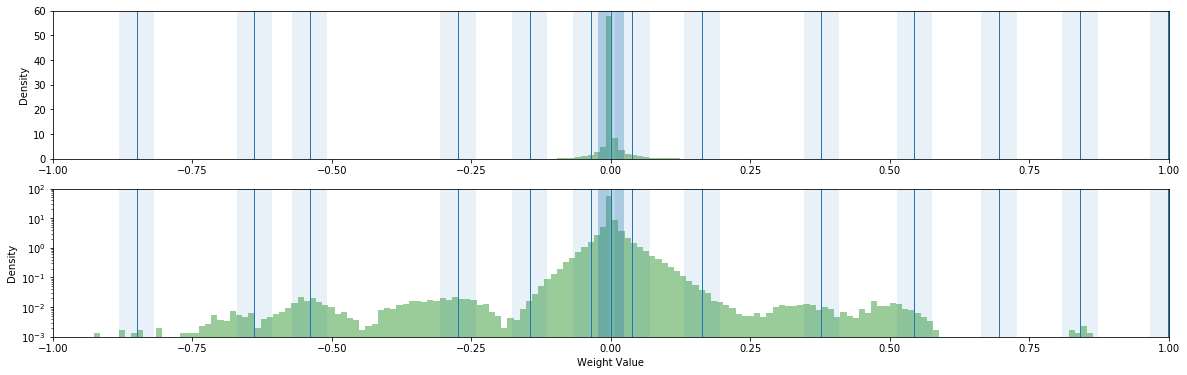

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.69
Epoch: 20. Test Accuracy: 97.13
Epoch: 30. Test Accuracy: 95.83
Epoch: 40. Test Accuracy: 92.82
Epoch: 50. Test Accuracy: 91.68
Retrain Test: 91.68, Retrain Validation: 91.80, Prune Test: 90.08, Prune Validation: 90.65, Prune Sparsity: 99.34


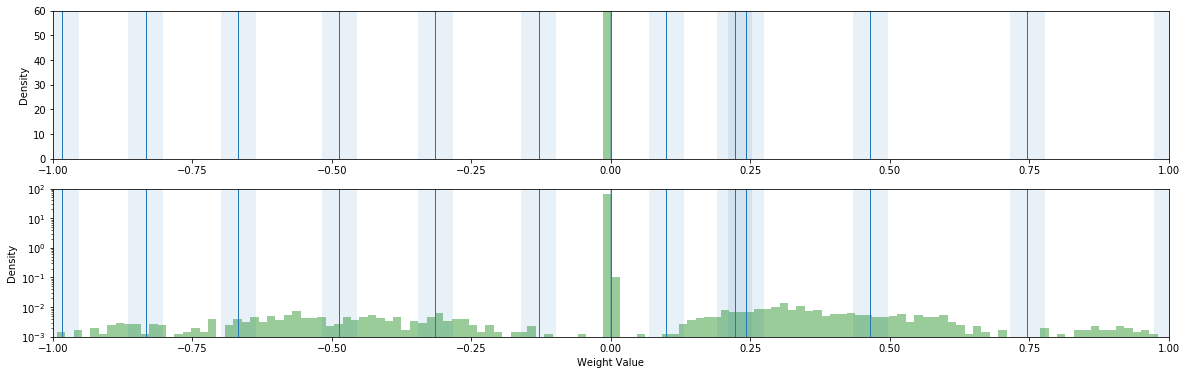

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 45.50
Epoch: 20. Test Accuracy: 54.05
Epoch: 30. Test Accuracy: 74.70
Epoch: 40. Test Accuracy: 79.65
Epoch: 50. Test Accuracy: 81.85
Retrain Test: 81.85, Retrain Validation: 81.67, Prune Test: 31.02, Prune Validation: 30.53, Prune Sparsity: 38.26


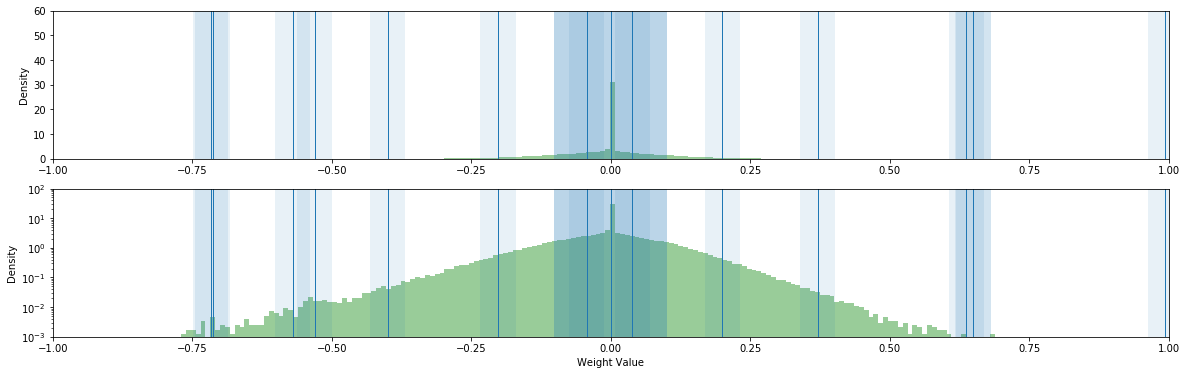

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.22
Epoch: 20. Test Accuracy: 98.15
Epoch: 30. Test Accuracy: 97.95
Epoch: 40. Test Accuracy: 97.93
Epoch: 50. Test Accuracy: 97.73
Retrain Test: 97.73, Retrain Validation: 97.58, Prune Test: 97.51, Prune Validation: 97.23, Prune Sparsity: 82.27


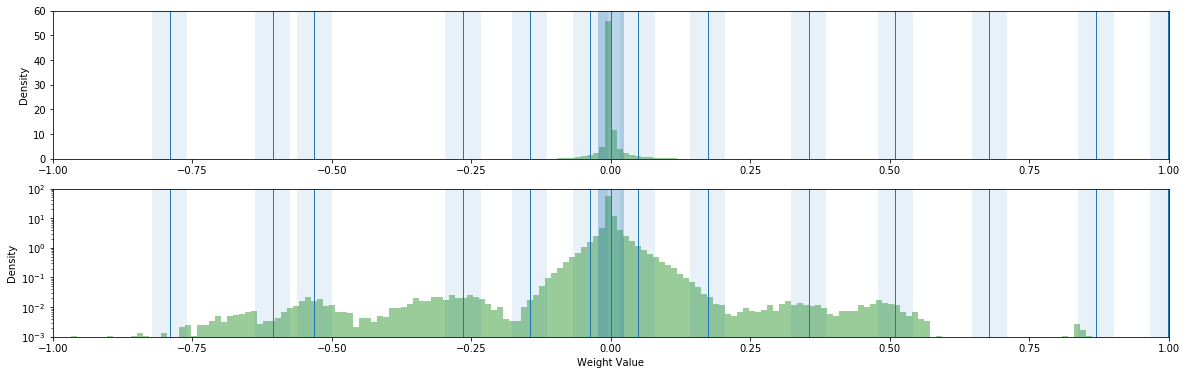

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.79
Epoch: 20. Test Accuracy: 97.22
Epoch: 30. Test Accuracy: 95.89
Epoch: 40. Test Accuracy: 93.34
Epoch: 50. Test Accuracy: 92.33
Retrain Test: 92.33, Retrain Validation: 92.37, Prune Test: 89.93, Prune Validation: 90.61, Prune Sparsity: 99.33


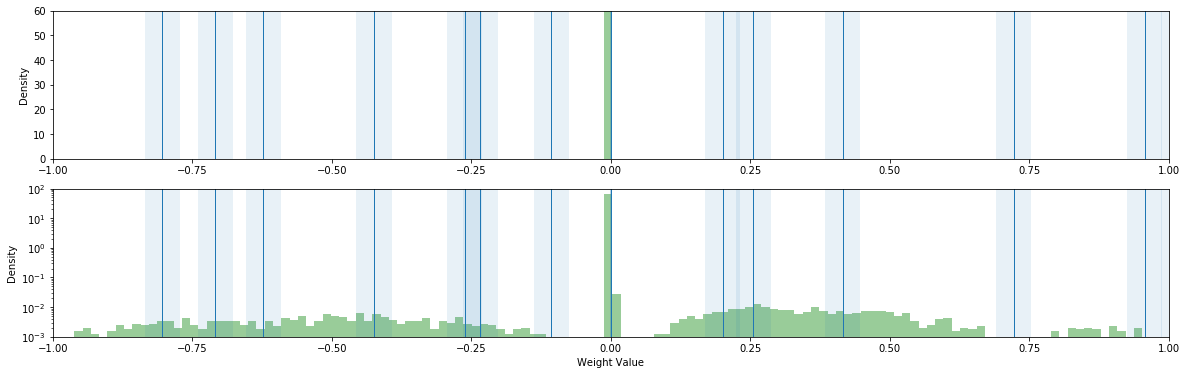

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 45.05
Terminating Search - Epoch: 13 - Val Acc: 49.12
Retrain Test: 48.31, Retrain Validation: 49.12, Prune Test: 35.61, Prune Validation: 36.13, Prune Sparsity: 37.21


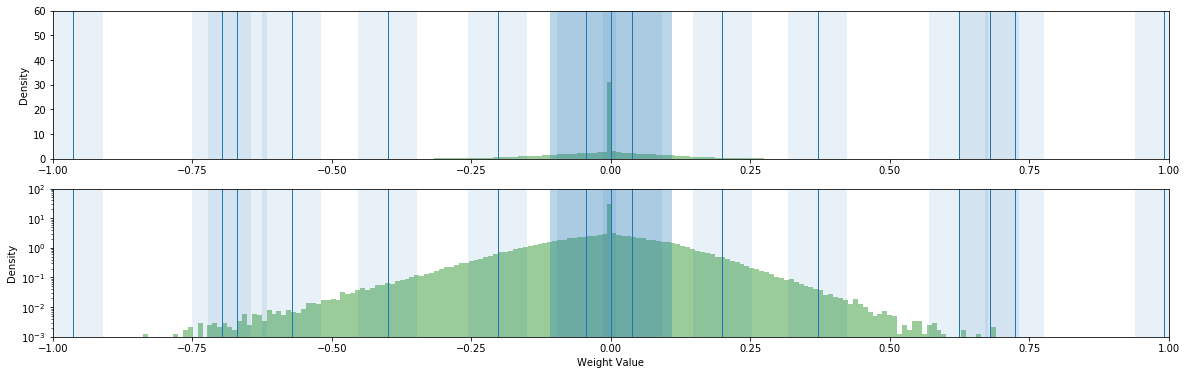

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.20
Epoch: 20. Test Accuracy: 98.13
Epoch: 30. Test Accuracy: 98.02
Epoch: 40. Test Accuracy: 97.78
Epoch: 50. Test Accuracy: 97.82
Retrain Test: 97.82, Retrain Validation: 97.78, Prune Test: 97.18, Prune Validation: 97.07, Prune Sparsity: 79.44


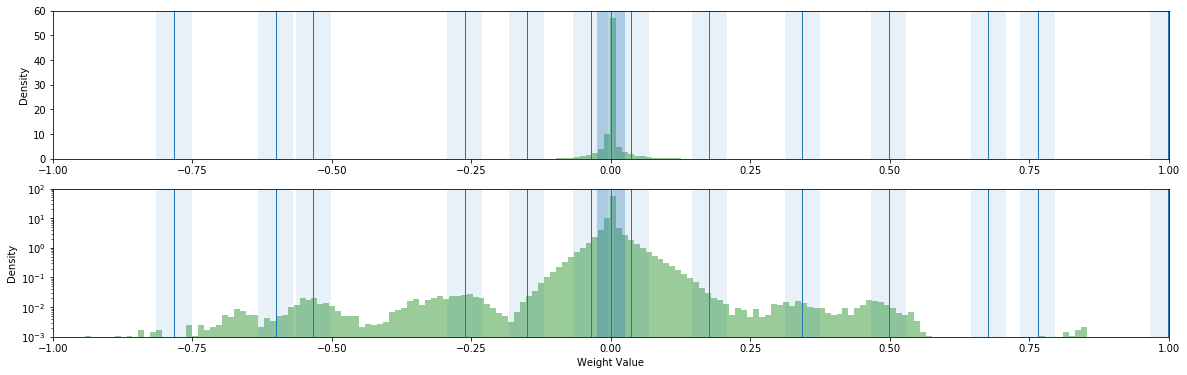

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.74
Epoch: 20. Test Accuracy: 97.42
Epoch: 30. Test Accuracy: 95.63
Epoch: 40. Test Accuracy: 94.14
Epoch: 50. Test Accuracy: 93.73
Retrain Test: 93.73, Retrain Validation: 93.93, Prune Test: 86.81, Prune Validation: 87.40, Prune Sparsity: 99.33


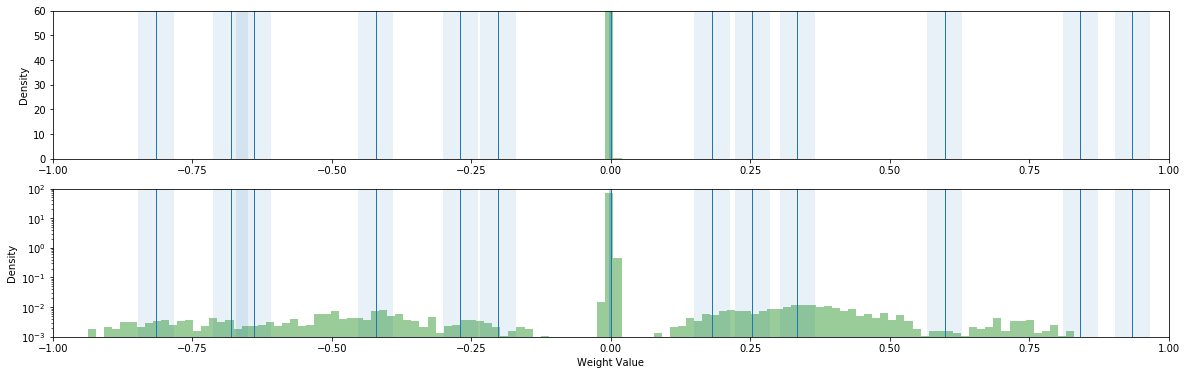

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 28.07
Terminating Search - Epoch: 13 - Val Acc: 34.83
Retrain Test: 34.11, Retrain Validation: 34.83, Prune Test: 28.48, Prune Validation: 29.92, Prune Sparsity: 37.46


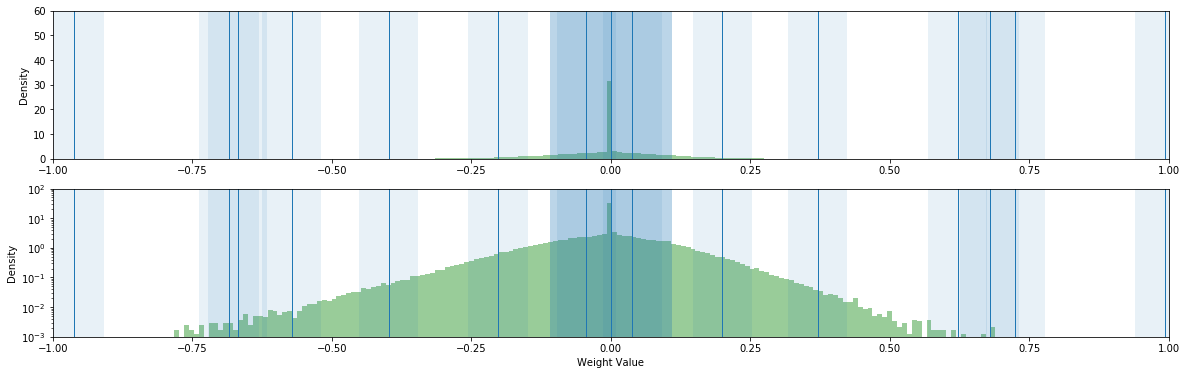

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.11
Epoch: 20. Test Accuracy: 98.14
Epoch: 30. Test Accuracy: 98.07
Epoch: 40. Test Accuracy: 98.01
Epoch: 50. Test Accuracy: 97.87
Retrain Test: 97.87, Retrain Validation: 97.75, Prune Test: 97.21, Prune Validation: 97.08, Prune Sparsity: 79.70


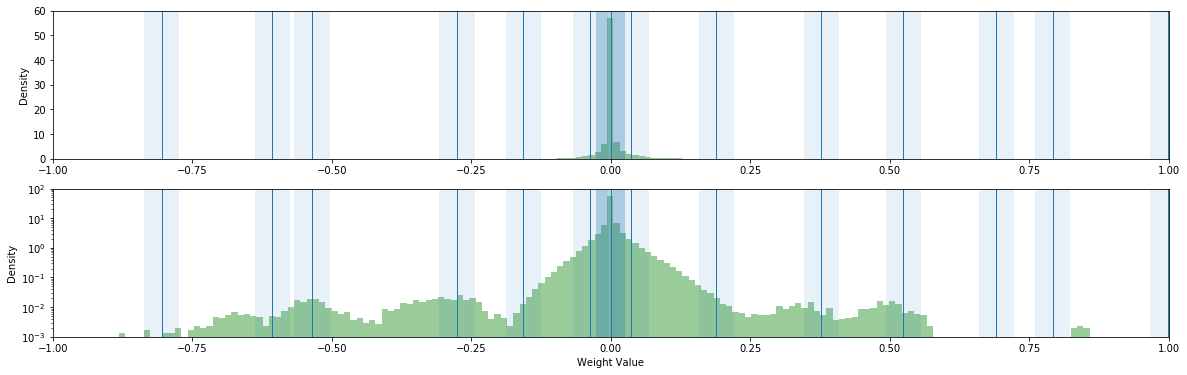

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.89
Epoch: 20. Test Accuracy: 97.04
Epoch: 30. Test Accuracy: 96.19
Epoch: 40. Test Accuracy: 95.55
Epoch: 50. Test Accuracy: 95.28
Retrain Test: 95.28, Retrain Validation: 95.52, Prune Test: 67.19, Prune Validation: 67.63, Prune Sparsity: 99.42


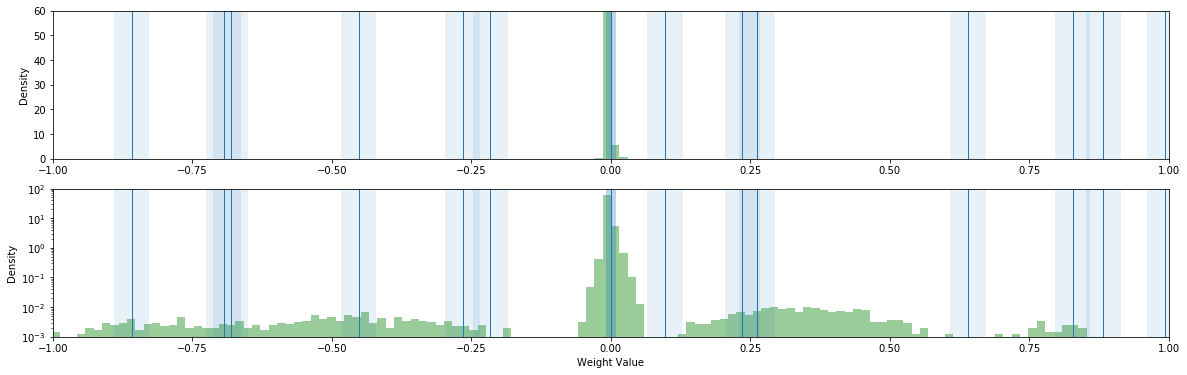

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 29.48
Terminating Search - Epoch: 13 - Val Acc: 39.62
Retrain Test: 38.63, Retrain Validation: 39.62, Prune Test: 32.00, Prune Validation: 32.25, Prune Sparsity: 37.35


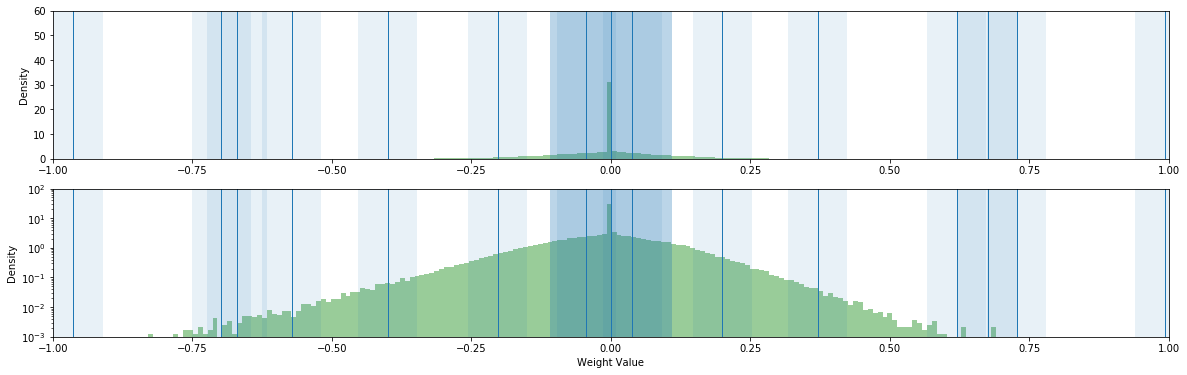

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.17
Epoch: 20. Test Accuracy: 98.00
Epoch: 30. Test Accuracy: 98.00
Epoch: 40. Test Accuracy: 97.94
Epoch: 50. Test Accuracy: 97.67
Retrain Test: 97.67, Retrain Validation: 97.66, Prune Test: 96.82, Prune Validation: 96.75, Prune Sparsity: 82.63


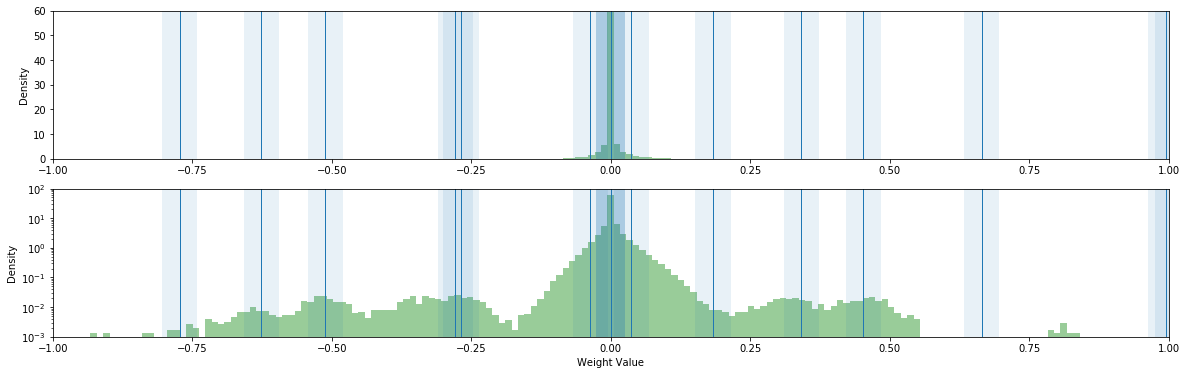

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.69
Epoch: 20. Test Accuracy: 97.20
Epoch: 30. Test Accuracy: 96.80
Epoch: 40. Test Accuracy: 96.85
Epoch: 50. Test Accuracy: 96.39
Retrain Test: 96.39, Retrain Validation: 96.45, Prune Test: 30.24, Prune Validation: 29.68, Prune Sparsity: 99.61


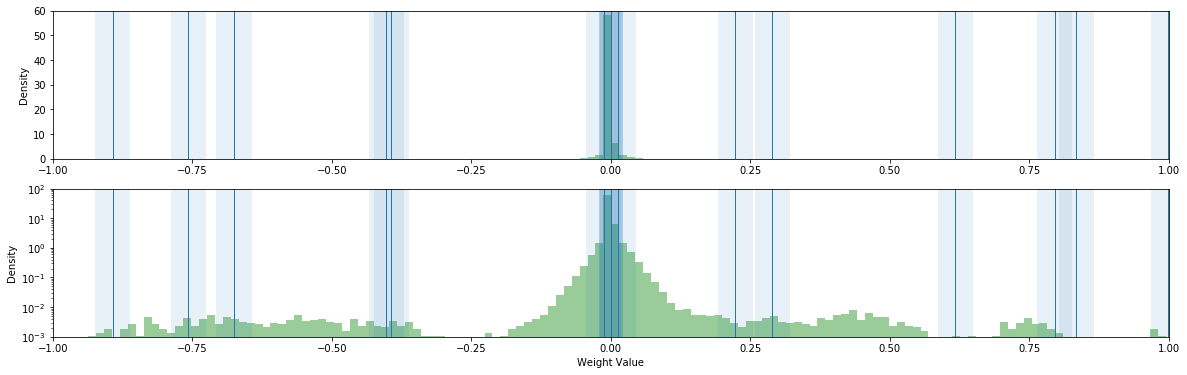

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 27.39
Terminating Search - Epoch: 13 - Val Acc: 39.14
Retrain Test: 38.02, Retrain Validation: 39.14, Prune Test: 33.27, Prune Validation: 34.46, Prune Sparsity: 38.99


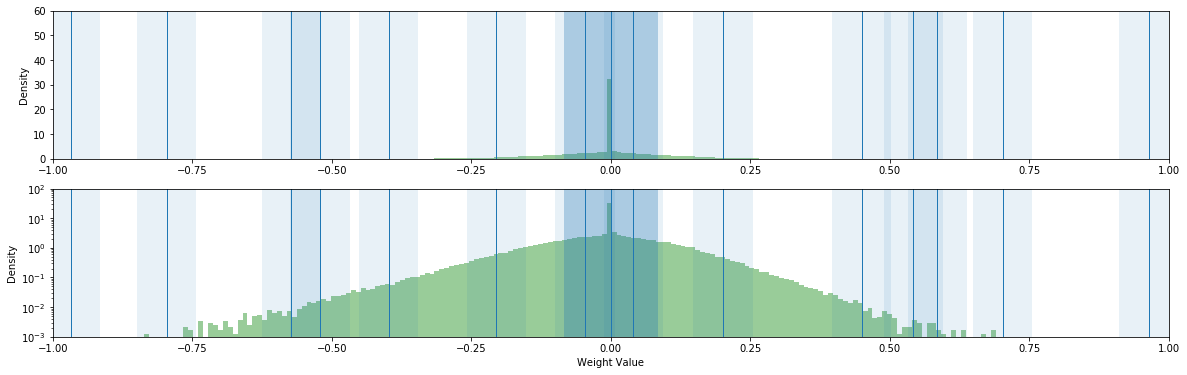

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.03
Epoch: 30. Test Accuracy: 97.68
Epoch: 40. Test Accuracy: 97.53
Epoch: 50. Test Accuracy: 97.75
Retrain Test: 97.75, Retrain Validation: 97.68, Prune Test: 95.93, Prune Validation: 95.83, Prune Sparsity: 96.70


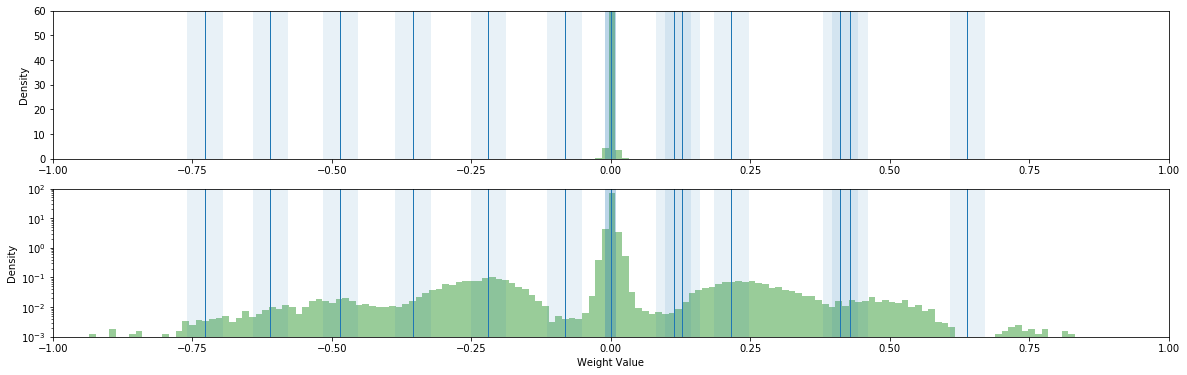

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.74
Epoch: 20. Test Accuracy: 97.11
Epoch: 30. Test Accuracy: 95.97
Epoch: 40. Test Accuracy: 95.96
Epoch: 50. Test Accuracy: 95.93
Retrain Test: 95.93, Retrain Validation: 96.04, Prune Test: 59.41, Prune Validation: 59.23, Prune Sparsity: 99.37


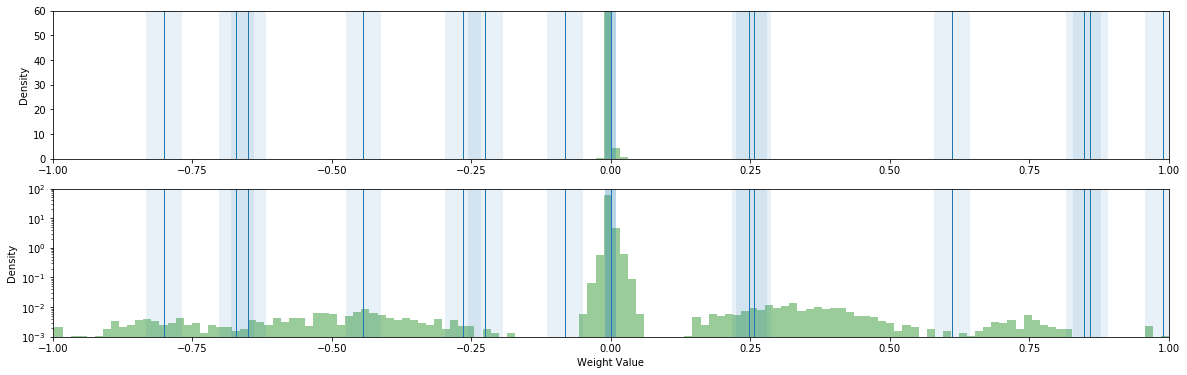

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 1000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 44.19
Terminating Search - Epoch: 13 - Val Acc: 49.69
Retrain Test: 49.03, Retrain Validation: 49.69, Prune Test: 26.51, Prune Validation: 28.25, Prune Sparsity: 39.29


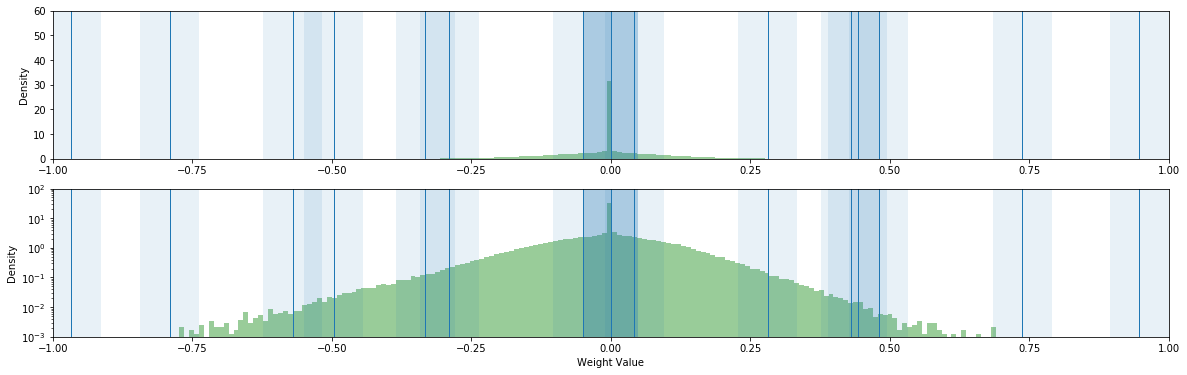

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.18
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 97.90
Epoch: 40. Test Accuracy: 97.97
Epoch: 50. Test Accuracy: 97.85
Retrain Test: 97.85, Retrain Validation: 97.72, Prune Test: 96.33, Prune Validation: 96.14, Prune Sparsity: 77.44


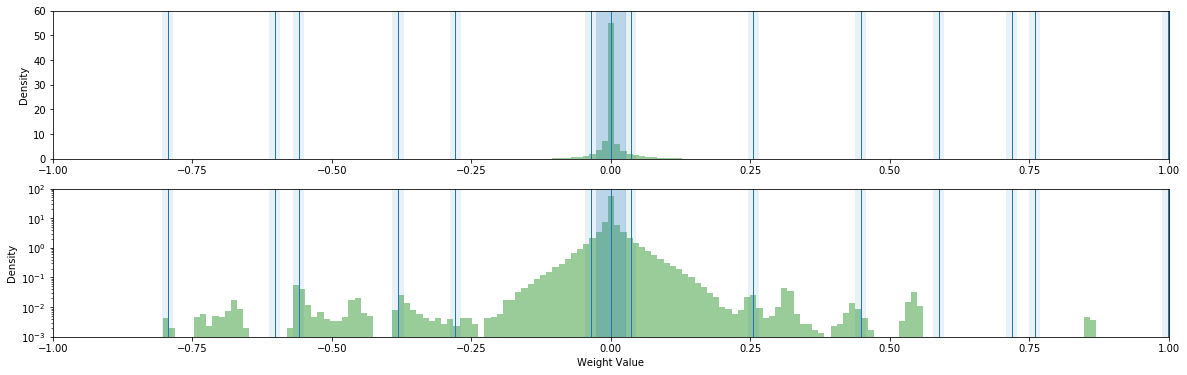

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.77
Epoch: 20. Test Accuracy: 97.21
Epoch: 30. Test Accuracy: 95.54
Epoch: 40. Test Accuracy: 92.07
Epoch: 50. Test Accuracy: 89.80
Retrain Test: 89.80, Retrain Validation: 89.99, Prune Test: 85.85, Prune Validation: 86.03, Prune Sparsity: 99.38


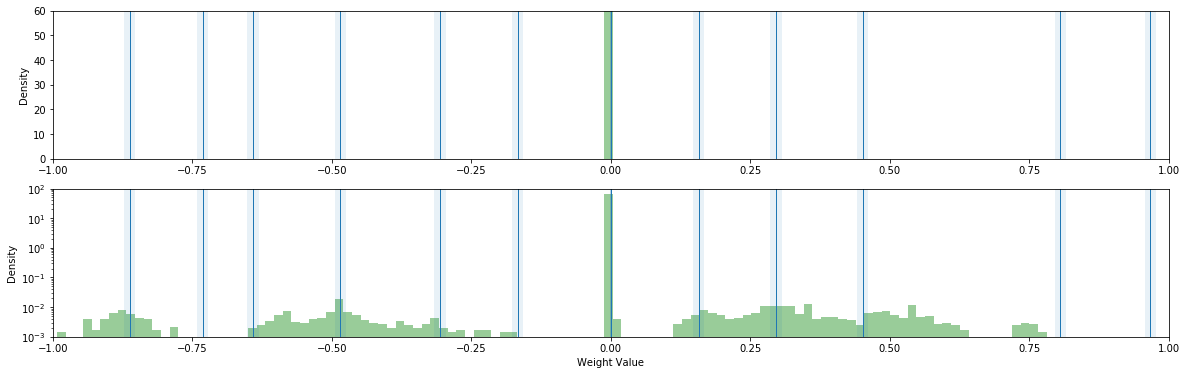

0-component Mean: 0.1 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 45.07
Epoch: 20. Test Accuracy: 53.63
Epoch: 30. Test Accuracy: 67.37
Epoch: 40. Test Accuracy: 68.19
Epoch: 50. Test Accuracy: 71.24
Retrain Test: 71.24, Retrain Validation: 71.71, Prune Test: 33.83, Prune Validation: 34.34, Prune Sparsity: 38.62


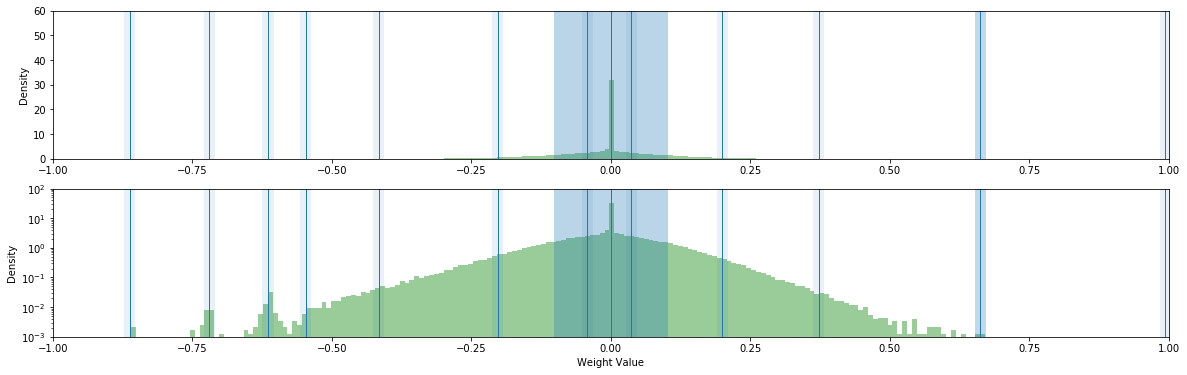

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.22
Epoch: 20. Test Accuracy: 98.20
Epoch: 30. Test Accuracy: 98.08
Epoch: 40. Test Accuracy: 98.00
Epoch: 50. Test Accuracy: 97.91
Retrain Test: 97.91, Retrain Validation: 97.66, Prune Test: 96.37, Prune Validation: 96.07, Prune Sparsity: 78.38


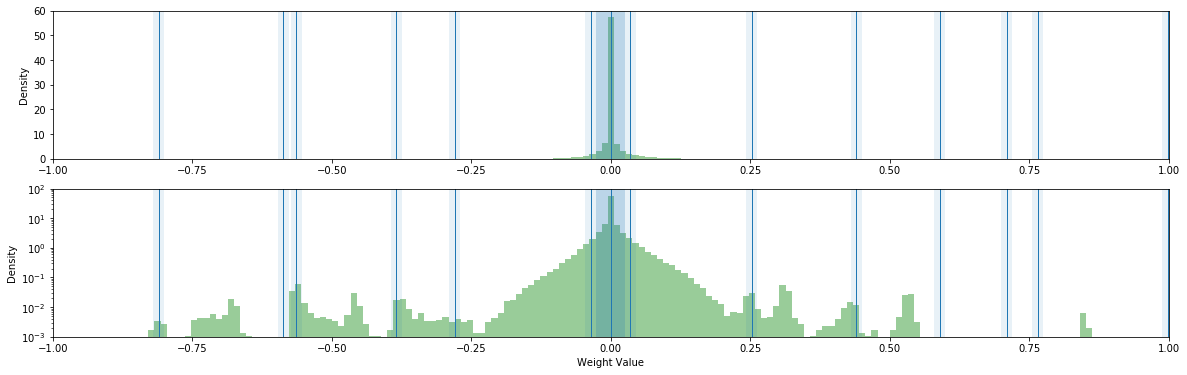

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.84
Epoch: 20. Test Accuracy: 96.77
Epoch: 30. Test Accuracy: 95.38
Epoch: 40. Test Accuracy: 92.29
Epoch: 50. Test Accuracy: 89.75
Retrain Test: 89.75, Retrain Validation: 89.64, Prune Test: 83.31, Prune Validation: 83.80, Prune Sparsity: 99.38


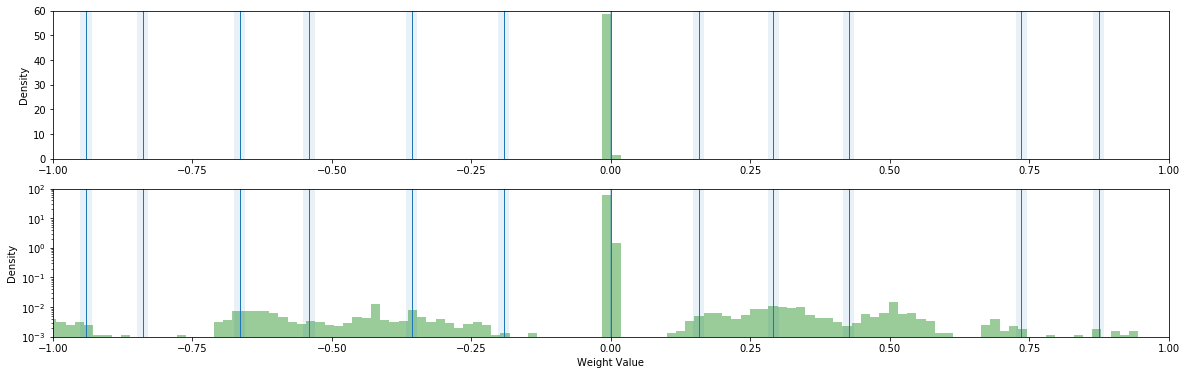

0-component Mean: 1.0 Variance: 9.999999999999998
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 43.33
Terminating Search - Epoch: 13 - Val Acc: 49.59
Retrain Test: 49.29, Retrain Validation: 49.59, Prune Test: 26.93, Prune Validation: 28.20, Prune Sparsity: 37.39


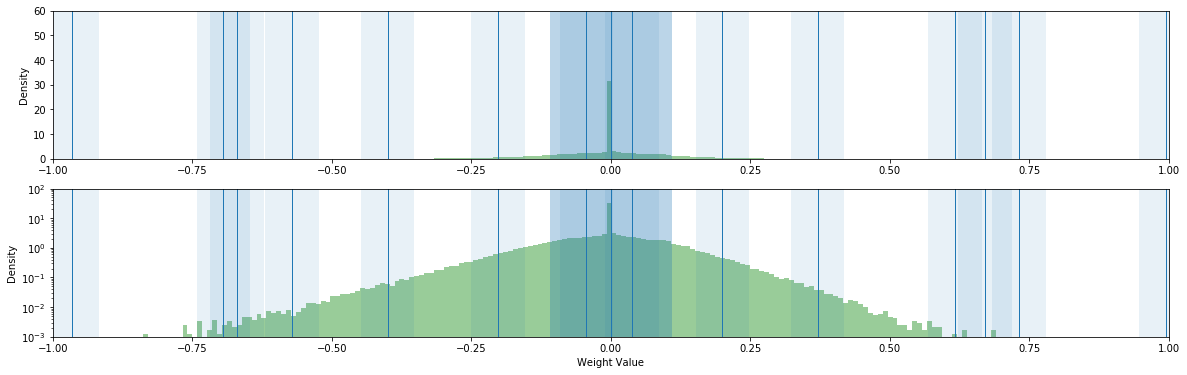

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.18
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 98.01
Epoch: 40. Test Accuracy: 98.01
Epoch: 50. Test Accuracy: 97.81
Retrain Test: 97.81, Retrain Validation: 97.59, Prune Test: 95.92, Prune Validation: 95.82, Prune Sparsity: 78.32


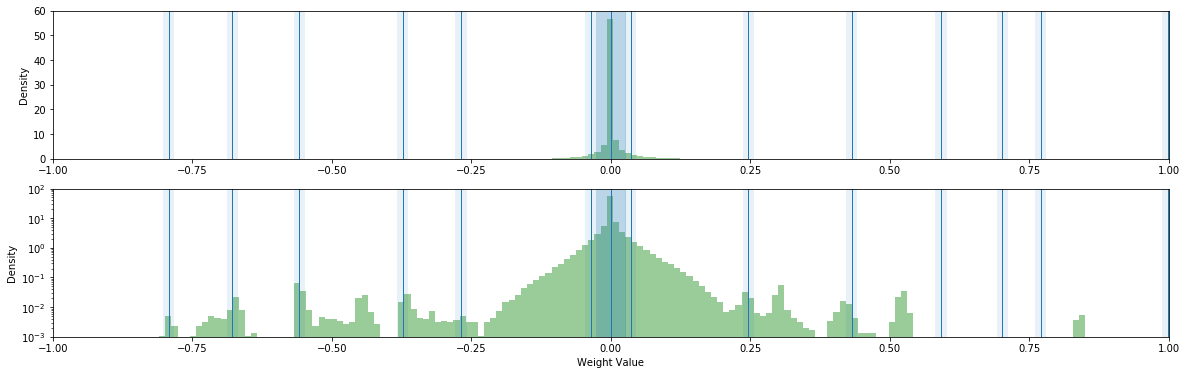

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.90
Epoch: 20. Test Accuracy: 97.00
Epoch: 30. Test Accuracy: 95.59
Epoch: 40. Test Accuracy: 93.22
Epoch: 50. Test Accuracy: 91.95
Retrain Test: 91.95, Retrain Validation: 92.05, Prune Test: 73.50, Prune Validation: 73.28, Prune Sparsity: 99.39


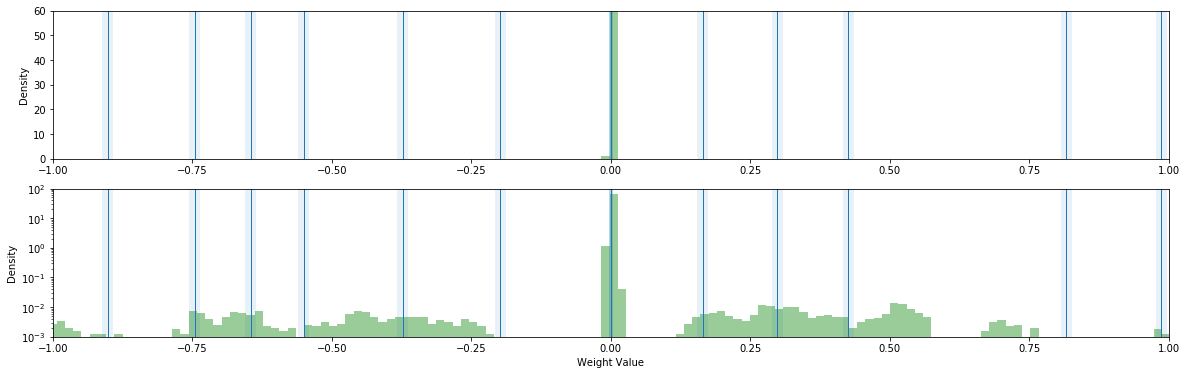

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 46.25
Terminating Search - Epoch: 13 - Val Acc: 49.53
Retrain Test: 49.25, Retrain Validation: 49.53, Prune Test: 28.56, Prune Validation: 29.08, Prune Sparsity: 37.05


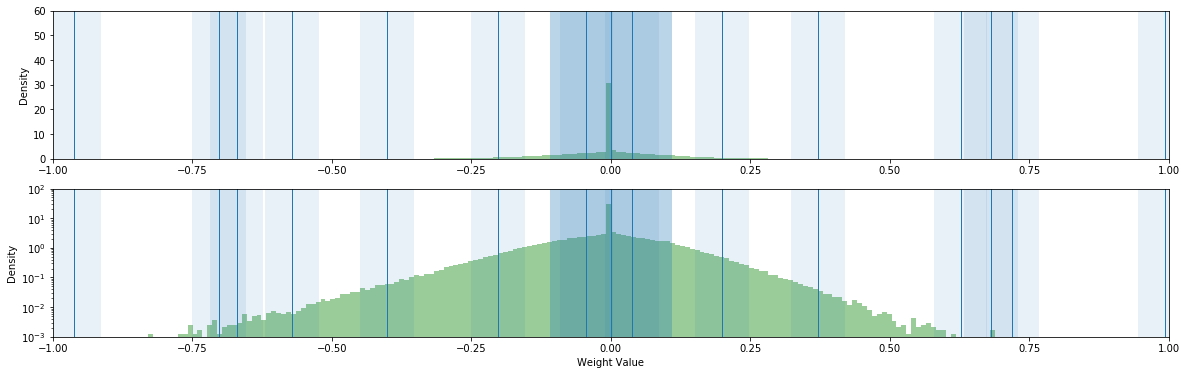

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.13
Epoch: 20. Test Accuracy: 98.15
Epoch: 30. Test Accuracy: 97.99
Epoch: 40. Test Accuracy: 97.97
Epoch: 50. Test Accuracy: 97.87
Retrain Test: 97.87, Retrain Validation: 97.74, Prune Test: 96.49, Prune Validation: 96.23, Prune Sparsity: 77.85


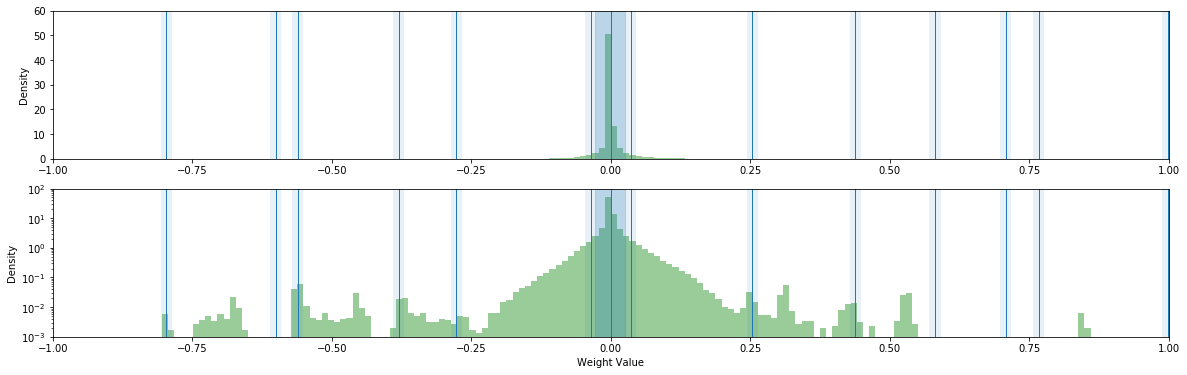

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.75
Epoch: 20. Test Accuracy: 97.20
Epoch: 30. Test Accuracy: 96.24
Epoch: 40. Test Accuracy: 95.29
Epoch: 50. Test Accuracy: 95.14
Retrain Test: 95.14, Retrain Validation: 95.07, Prune Test: 36.62, Prune Validation: 37.06, Prune Sparsity: 99.54


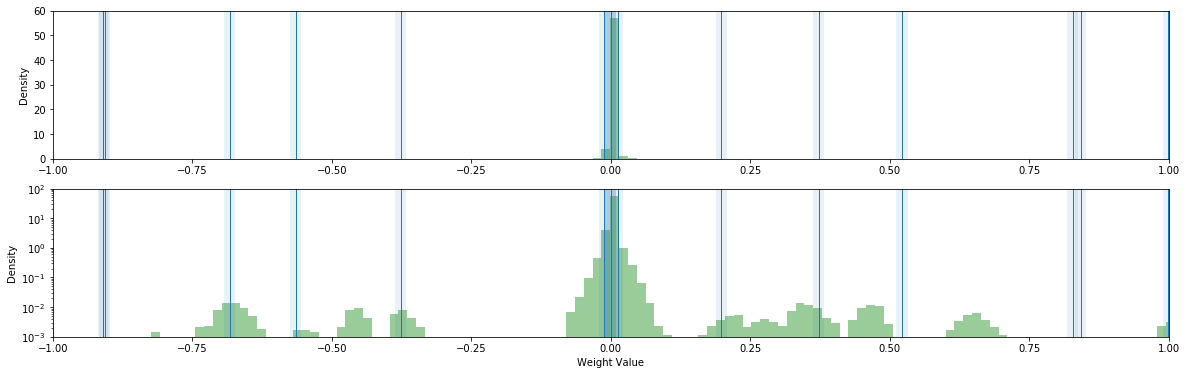

0-component Mean: 100.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 36.24
Epoch: 20. Test Accuracy: 56.98
Epoch: 30. Test Accuracy: 70.44
Epoch: 40. Test Accuracy: 80.66
Epoch: 50. Test Accuracy: 85.37
Retrain Test: 85.37, Retrain Validation: 85.92, Prune Test: 34.26, Prune Validation: 36.94, Prune Sparsity: 38.39


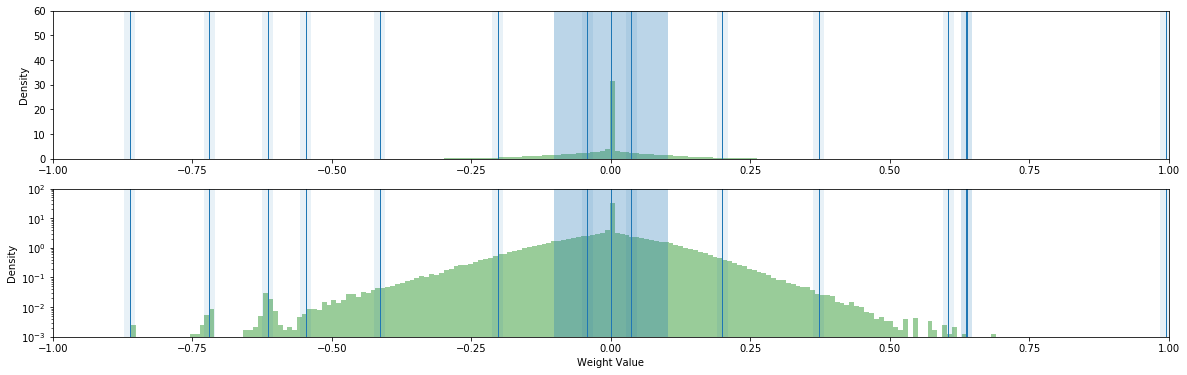

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.14
Epoch: 20. Test Accuracy: 97.98
Epoch: 30. Test Accuracy: 97.75
Epoch: 40. Test Accuracy: 98.05
Epoch: 50. Test Accuracy: 97.81
Retrain Test: 97.81, Retrain Validation: 97.64, Prune Test: 96.10, Prune Validation: 95.82, Prune Sparsity: 80.76


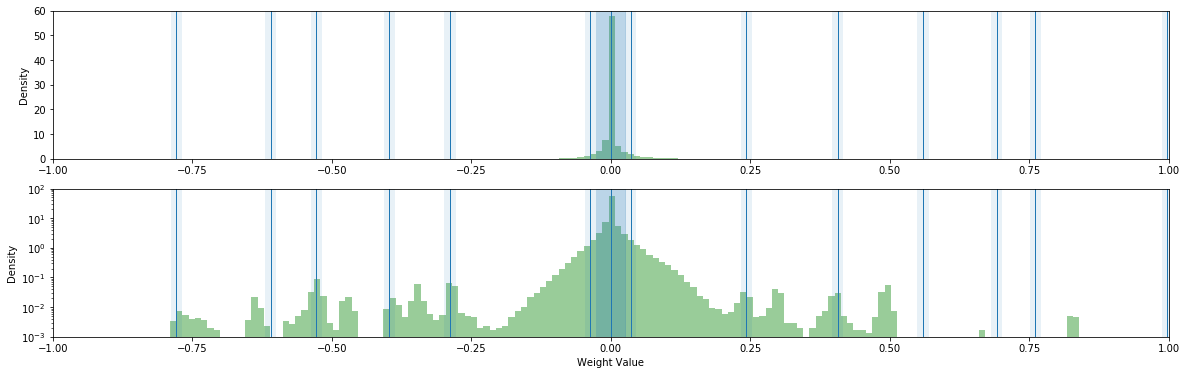

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 97.58
Epoch: 20. Test Accuracy: 97.23
Epoch: 30. Test Accuracy: 96.83
Epoch: 40. Test Accuracy: 96.54
Epoch: 50. Test Accuracy: 96.64
Retrain Test: 96.64, Retrain Validation: 96.51, Prune Test: 25.61, Prune Validation: 24.67, Prune Sparsity: 99.64


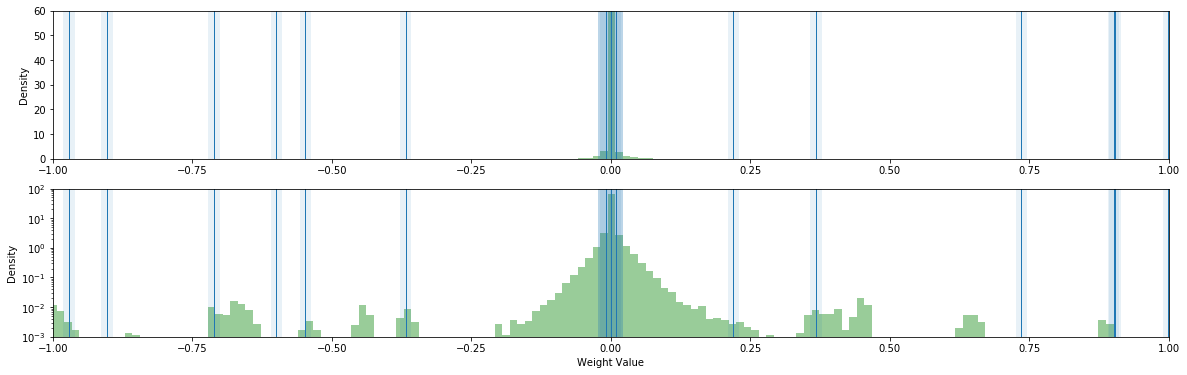

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 38.24
Epoch: 20. Test Accuracy: 56.12
Epoch: 30. Test Accuracy: 63.03
Epoch: 40. Test Accuracy: 76.43
Epoch: 50. Test Accuracy: 84.76
Retrain Test: 84.76, Retrain Validation: 85.76, Prune Test: 37.72, Prune Validation: 40.12, Prune Sparsity: 40.45


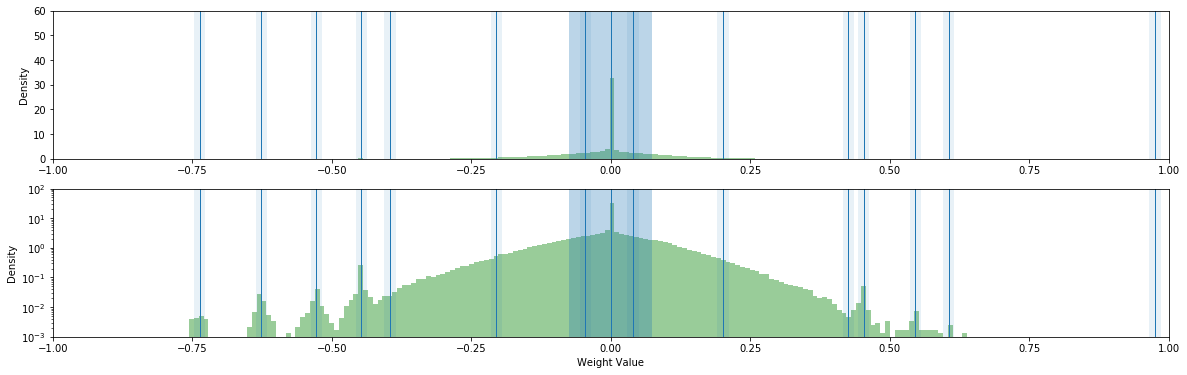

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.15
Epoch: 20. Test Accuracy: 98.01
Epoch: 30. Test Accuracy: 97.75
Epoch: 40. Test Accuracy: 97.66
Epoch: 50. Test Accuracy: 97.62
Retrain Test: 97.62, Retrain Validation: 97.34, Prune Test: 93.94, Prune Validation: 93.90, Prune Sparsity: 96.46


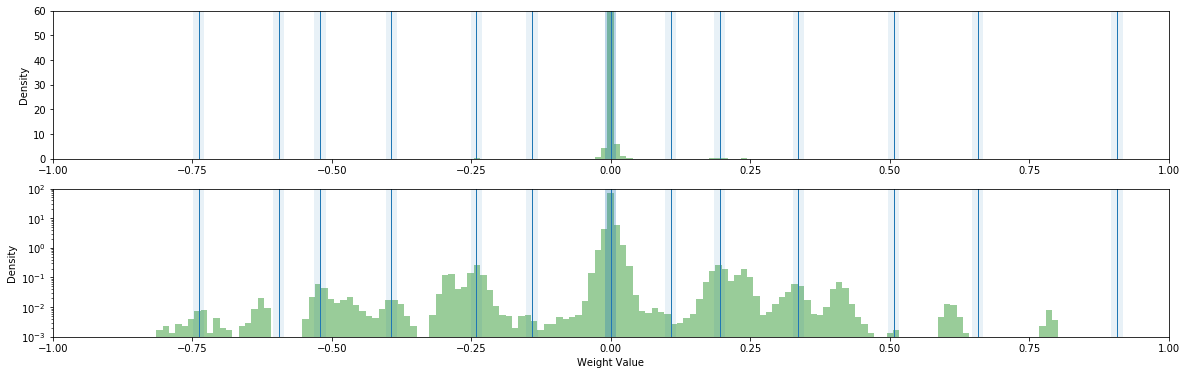

0-component Mean: 10000.0 Variance: 10.0
Non-zero component Mean: 10000.0 Variance: 2.0


In [ ]:
mixtures = 15
temp = 4
var = 2
zvar = 10

out_str = ""
for mean in [0.1, 1, 10, 100, 1000, 10000]:
    for zmean in [0.1, 1, 10, 100, 1000, 10000]:
        alpha, beta = get_ab(mean, var)
        zalpha, zbeta = get_ab(zmean, zvar)
        title = "Mean: {:.2f} ZMean: {:.2f}\n".format(mean, zmean)
        out_str += title
        '''
        model_sws, gmp_sws, res_sws = retrain_model((alpha, beta), (zalpha, zbeta), tau, int(0), mixtures, model_name, data_size, 'CESNT', "", False)
        show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
        sws_res = "CESNT - Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
        
        model_sws, gmp_sws, res_sws = retrain_model((alpha, beta), (zalpha, zbeta), tau, int(0), mixtures, model_name, data_size, 'MSESNT', "", False)
        show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
        sws_res = "MSESNT Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
        '''
        
        model_sws, gmp_sws, res_sws = retrain_model((alpha, beta), (zalpha, zbeta), tau, temp, mixtures, model_name, data_size, 'CEST', "", True)
        show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
        sws_res = "CEST - Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
        
        model_sws, gmp_sws, res_sws = retrain_model((alpha, beta), (zalpha, zbeta), tau, temp, mixtures, model_name, data_size, 'MSEST', "", True)
        show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
        sws_res = "MSEST - Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
        
        model_sws, gmp_sws, res_sws = retrain_model((alpha, beta), (zalpha, zbeta), tau, temp, mixtures, model_name, data_size, 'MSEL', "", True)
        show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
        sws_res = "MSEL - Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
        out_str += sws_res
print(out_str)